In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels \
    import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared, ConstantKernel
from astropy.convolution import convolve, Gaussian1DKernel, Box1DKernel

import os
import pickle
from time import time
from sklearn.decomposition import PCA

from time import time
import pandas as pd
import pdspy.modeling as modeling

%matplotlib inline

In [100]:
param_names = ["Tstar","logL_star","logM_disk","logR_disk","h_0","logR_in",\
          "gamma","beta","logM_env","logR_env","f_cav","ksi","loga_max","p","incl"]

params=[]
for i in range(len(param_names)):
    filename="../grid_metadata/param"+str(i)+".txt"
    with open (filename, 'rb') as fp:
        params.append(pickle.load(fp))

ranges = [[3000.,5000.], [-1,3.],[-8.,-2.], [0.,3.],[0.01,0.5],[-1.,2.5],[0.0,2.0],\
        [0.5,2.0],[-8.,-2.],[2.5,4.], [0.,1.], [0.5,1.5],[0.,5.],[2.5,4.5],[0.,90.]]
steps=[]
bases=[]
for i in range(len(ranges)):
    steps.append(np.linspace(ranges[i][0],ranges[i][1],11))
    bases.append(steps[i][5])

# get all model data
with open ('../grid_metadata/corefull.txt', 'rb') as fp:
    core= pickle.load(fp)
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    cube = np.array(pickle.load(fp))
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    nancube = np.array(pickle.load(fp))
    
# x values (wavelengths) - 500 values, in normal space
with open ('../grid_metadata/xvals.txt', 'rb') as fp:
    xvals = pickle.load(fp)   
    
# fix -infs: powerlaw cutoff
for i in range(len(cube)):
    if -np.inf in cube[i]:
        a = cube[i].tolist()
        a.reverse()
        ind = len(a)-a.index(-np.inf)
        x1 = xvals[ind]
        y1 = cube[i][ind]
        for j in range(ind):
            cube[i][j]=(100*(np.log10(xvals[j]/x1)))+y1
            
# nan cutoff for means            
nancube[nancube<-20]=np.nan

In [3]:
dropped=[[3723, 1222, 3130, 3550, 3293, 3224, 590, 2829, 2876, 189],
 [2818, 3588, 1664, 3471, 1107, 1551, 150, 471, 3172, 1333],
 [2300, 223, 2590, 1620, 3465, 1841, 2885, 2009, 1607, 2147],
 [933, 2104, 948, 3554, 1739, 2838, 3459, 2004, 1915, 3703],
 [3641, 3667, 2842, 1279, 3792, 3487, 1619, 3810, 1672, 3648],
 [2477, 2467, 3785, 2916, 871, 3569, 1668, 1622, 3039, 2642],
 [2188, 2163, 405, 449, 999, 2351, 3785, 3707, 3687, 320],
 [2882, 3565, 3696, 1346, 1194, 1131, 1684, 441, 1532, 2965],
 [3434, 2495, 1136, 507, 443, 1653, 2533, 3081, 1550, 1172],
 [2350, 745, 3692, 3809, 416, 2070, 2151, 968, 133, 3032]]

In [4]:
cubes_cut=[]
nancubes_cut=[]
indices=[]
for i in range(10):
    data=[]
    ind=[]
    nan=[]
    for j in range(3850):
        if not j in dropped[i]:
            data.append(cube[j])
            ind.append(j)
            nan.append(nancube[j])
    cubes_cut.append(data)
    indices.append(ind)
    nancubes_cut.append(nan)

In [76]:
def sedcomp_5_10_15(model, nfeat0=100,nfeat1=500):
    fig,ax=plt.subplots(1,figsize=(12,9))
    sed_msub=cube[dropped[which][model]]-np.nanmean(nancube[dropped[which][model]])
    coeffs=pca.transform(sed_msub.reshape(1,-1))
    reconst5=np.dot(coeffs[0][0:5],eigenseds[0:5,nfeat0:nfeat1]) \
            +pca.mean_[nfeat0:nfeat1]+np.nanmean(nancube[dropped[which][model]])    
    reconst10=np.dot(coeffs[0][0:10],eigenseds[0:10,nfeat0:nfeat1]) \
        +pca.mean_[nfeat0:nfeat1]+np.nanmean(nancube[dropped[which][model]])       
    reconst15=np.dot(coeffs[0][0:15],eigenseds[0:15,nfeat0:nfeat1]) \
        +pca.mean_[nfeat0:nfeat1]+np.nanmean(nancube[dropped[which][model]])    
    ax.plot(np.log10(xvals)[nfeat0:nfeat1], cube[dropped[which][model]][nfeat0:nfeat1], c='black',label="pdspy SED",alpha=.9)
    ax.plot(np.log10(xvals)[nfeat0:nfeat1], reconst5, c='y',label="reconstructed SED, ncomp="+str(5),alpha=.8)
    ax.plot(np.log10(xvals)[nfeat0:nfeat1], reconst10, c='g',label="reconstructed SED, ncomp="+str(10),alpha=0.5)
    ax.plot(np.log10(xvals)[nfeat0:nfeat1], reconst15, c='b',label="reconstructed SED, ncomp="+str(5),alpha=0.7)
    plt.legend()
    plt.title("reconstructed SED of model "+str(dropped[which][model])+" against pdspy SED")
    plt.ylabel("log of Flux Density (mJy)",fontsize=16)
    plt.xlabel("log of λ (μm)",fontsize=16)
    plt.show()

done in 0.067s
3723


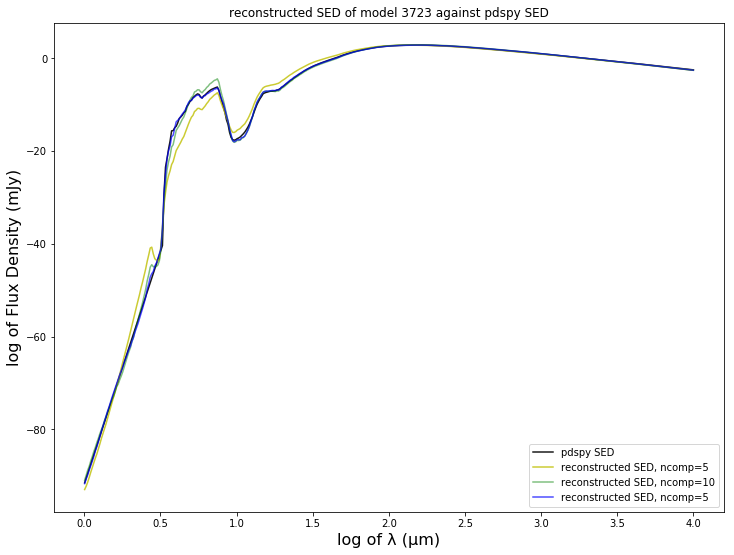

1222


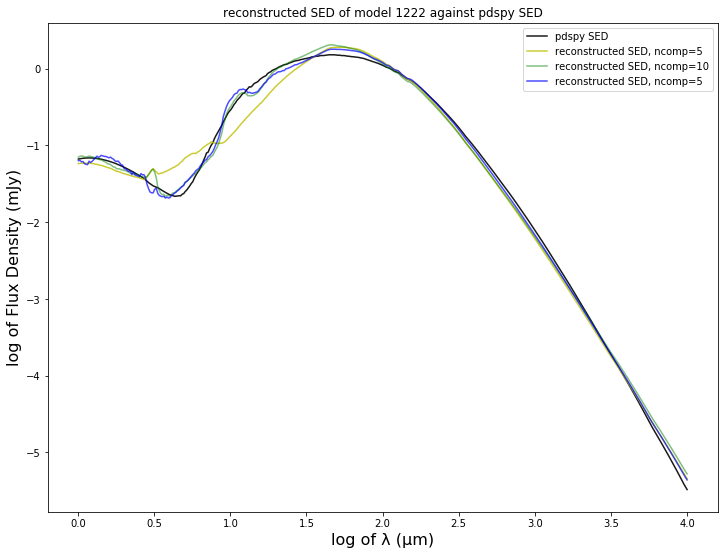

3130


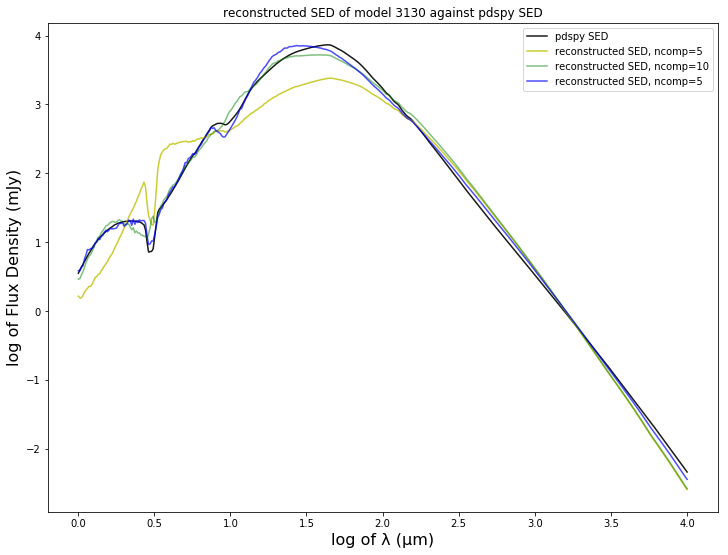

3550


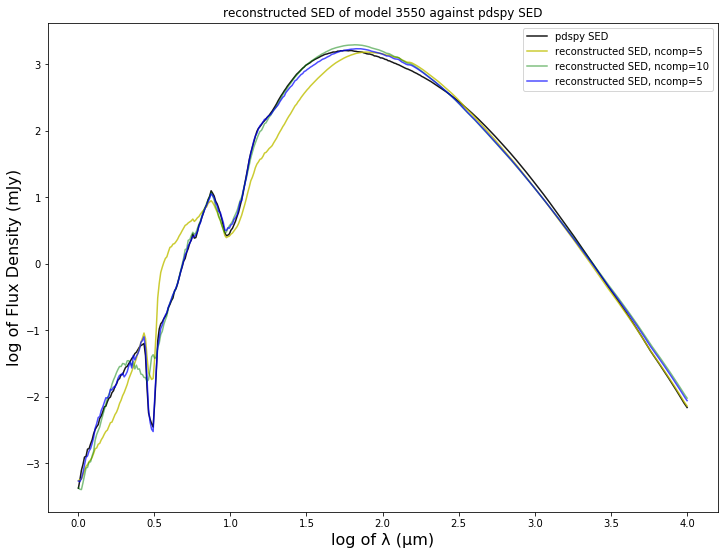

3293


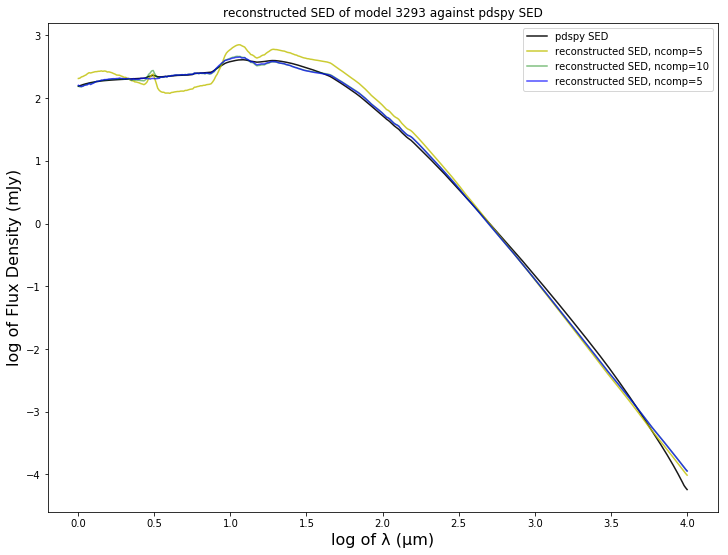

3224


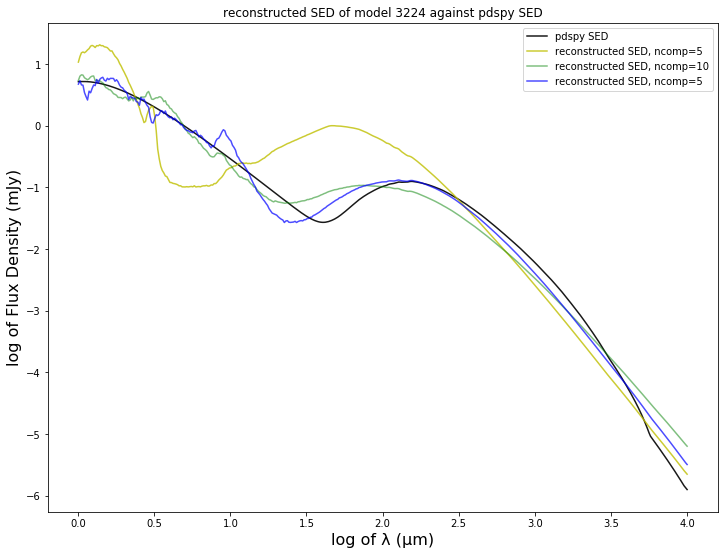

590


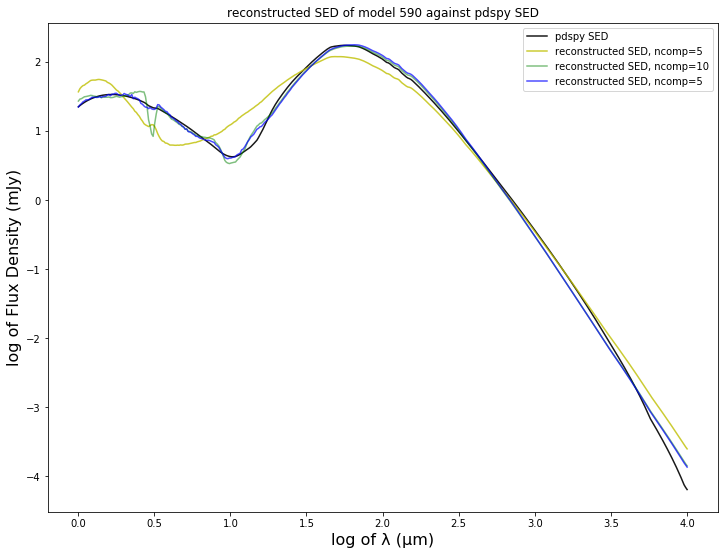

2829


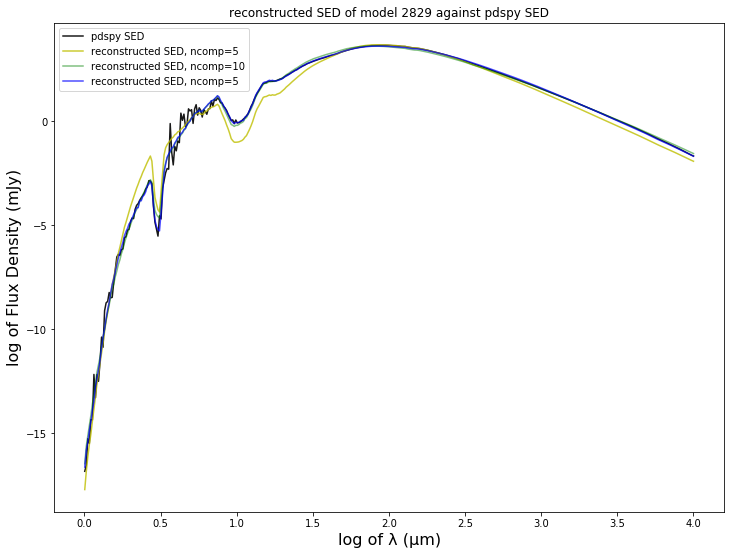

2876


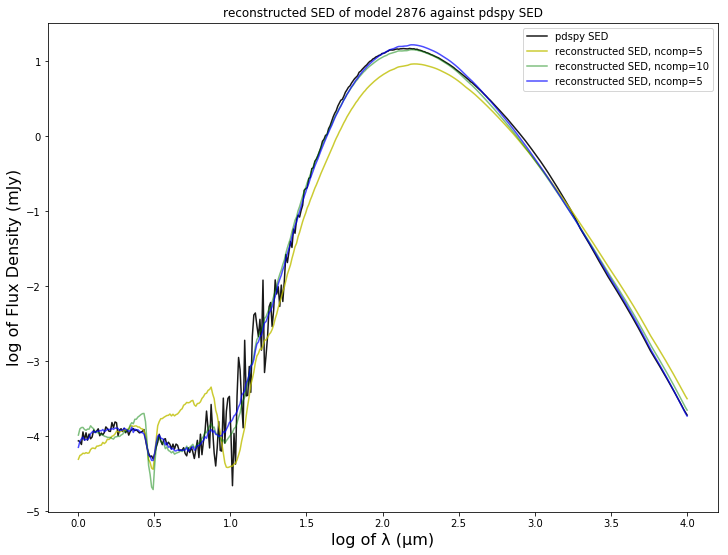

189


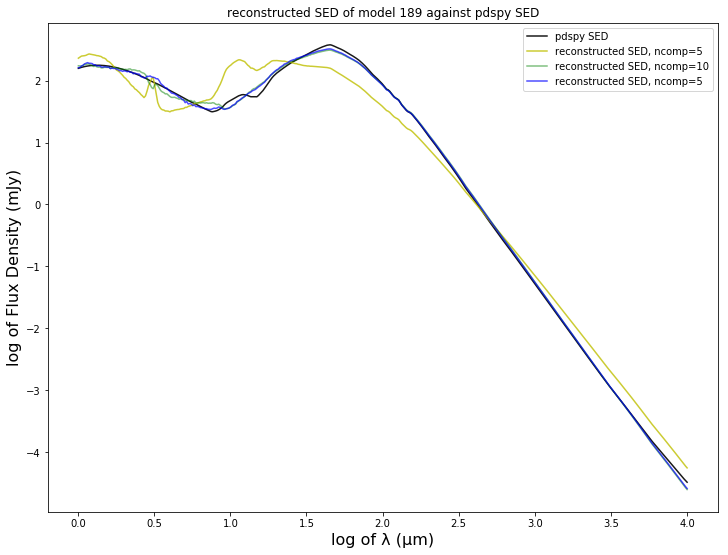

In [77]:
which=0
cube=cubes_cut[which]
nancube=nancubes_cut[which]

seds_msub = cube - np.nanmean(nancube,axis=1)[:,np.newaxis]

t0 = time()
pca = PCA(n_components=40).fit(seds_msub)
print("done in %0.3fs" % (time() - t0))

eigenseds=np.array(pca.components_)

for j in range(10):
    print(dropped[which][j])
    sedcomp_5_10_15(j,100,500)

done in 0.040s
2818


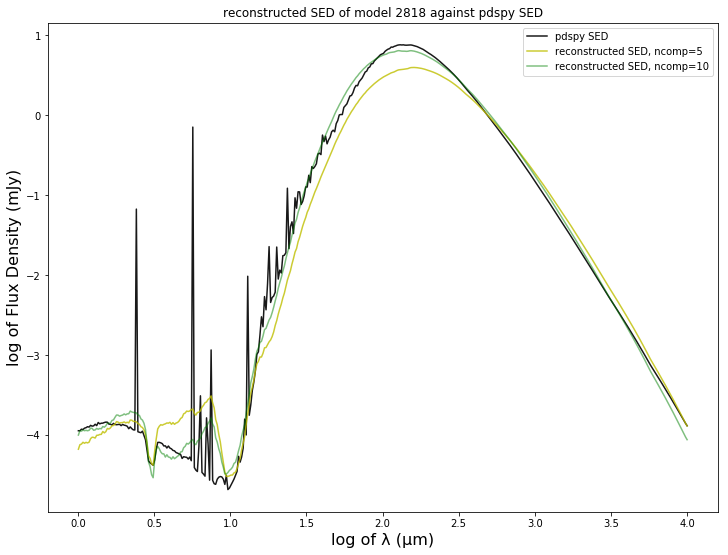

3588


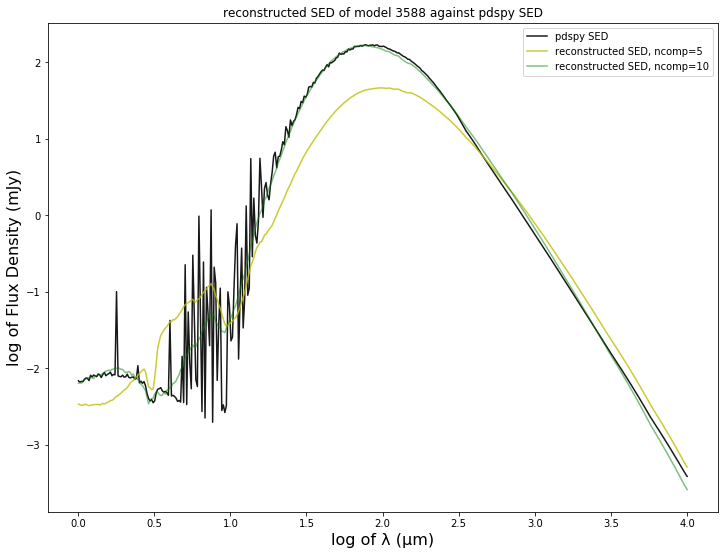

1664


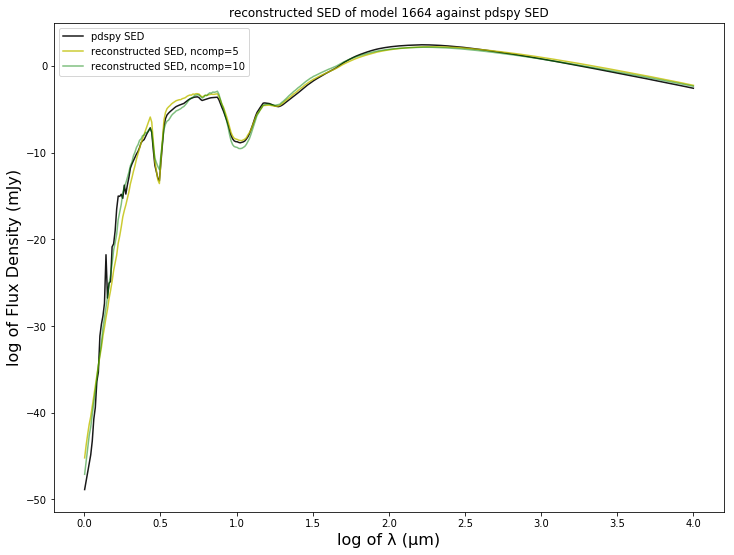

3471


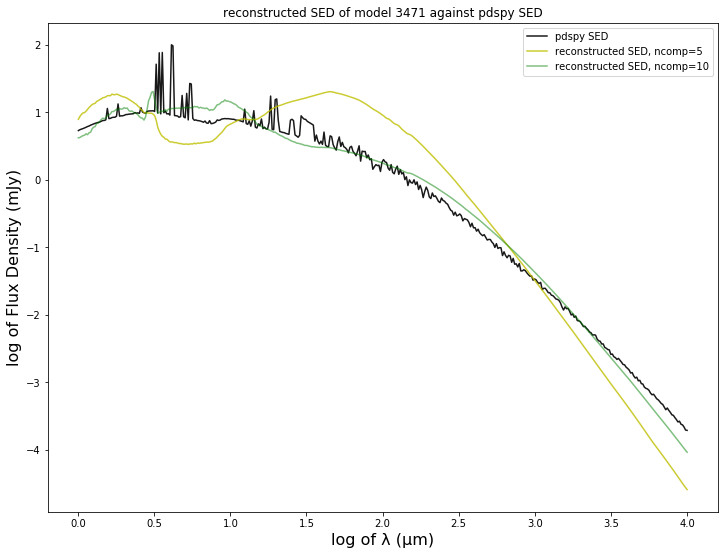

1107


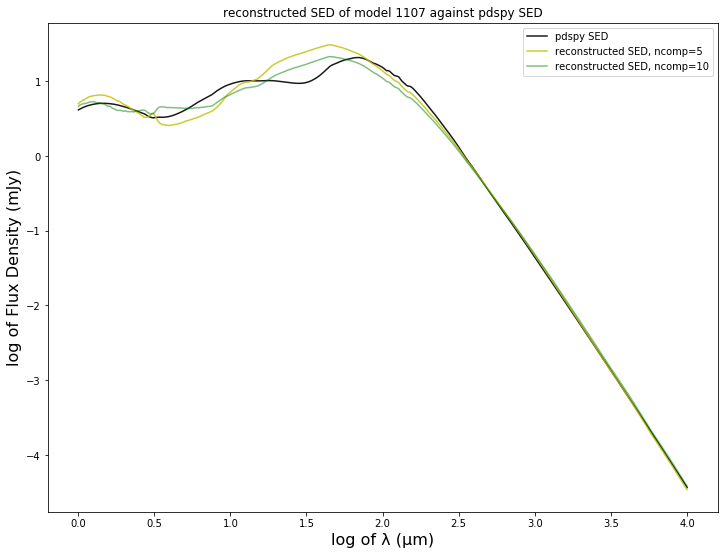

1551


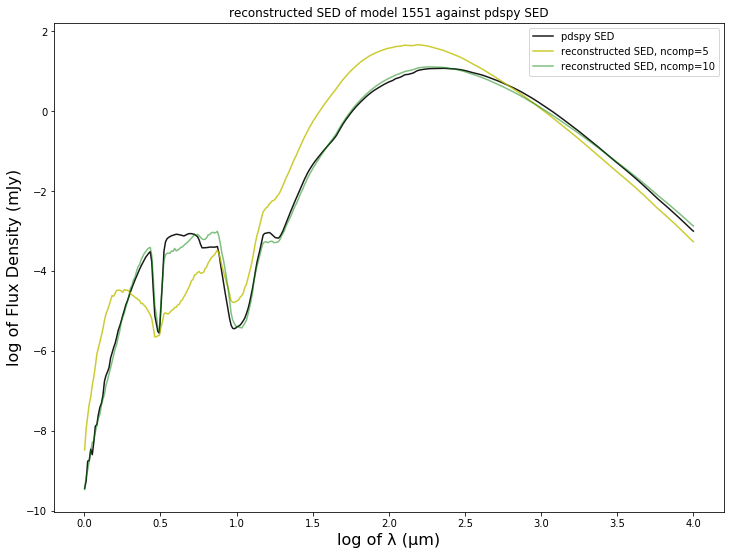

150


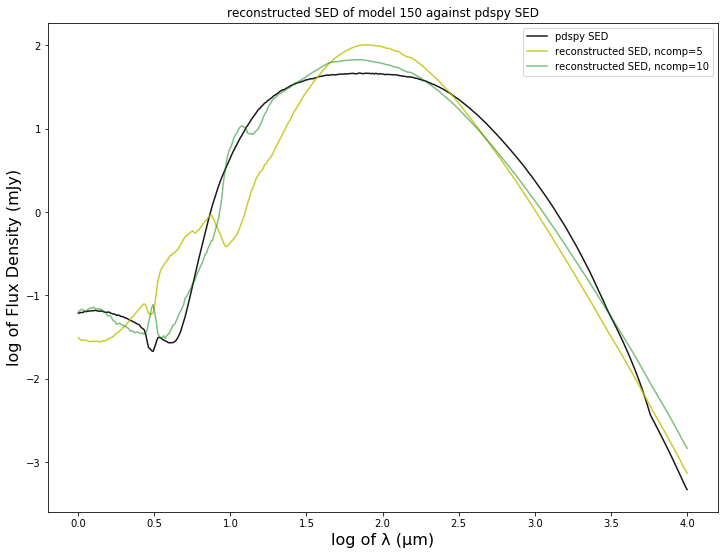

471


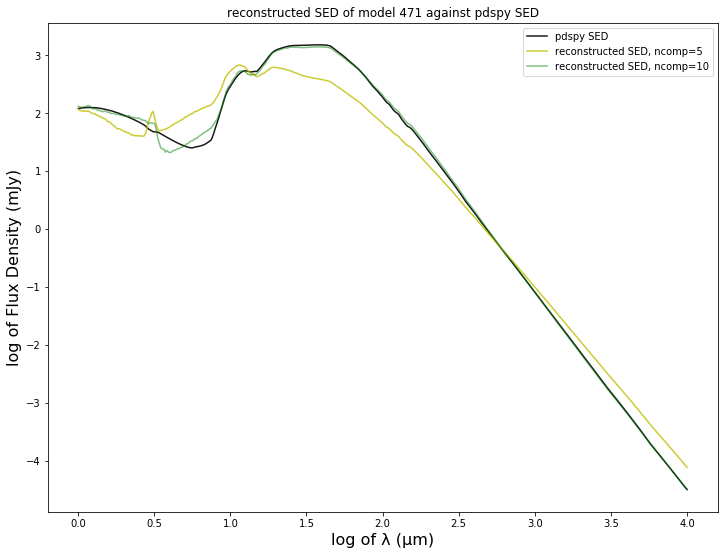

3172


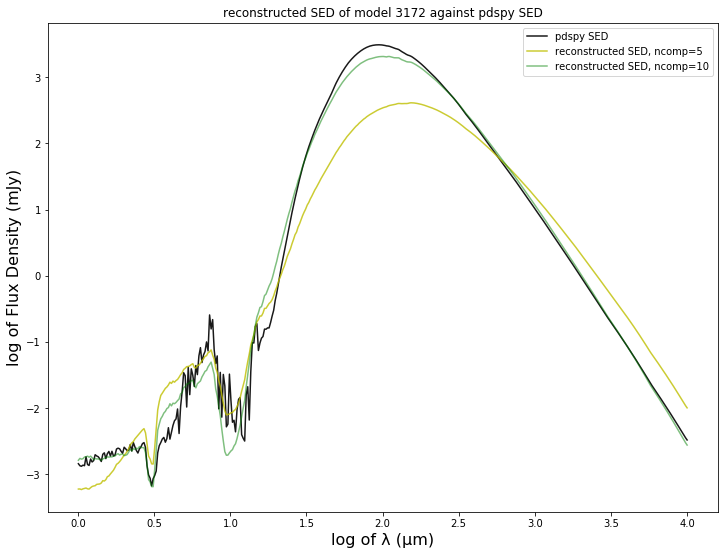

1333


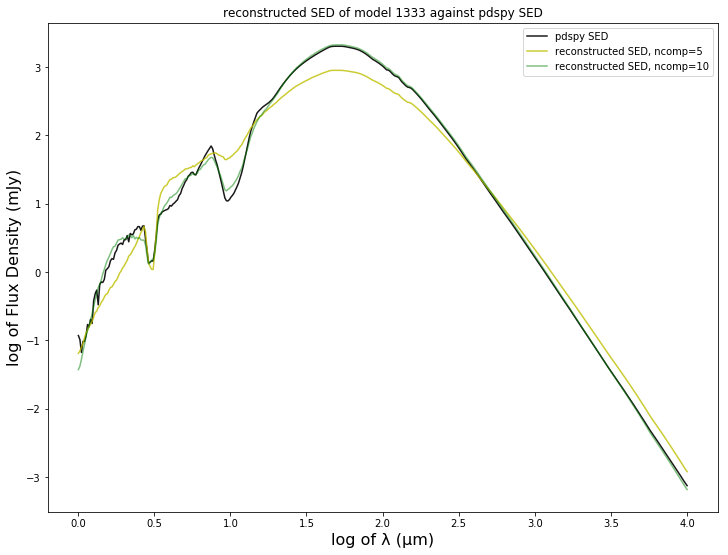

In [74]:
which=1
cube=cubes_cut[which]
nancube=nancubes_cut[which]

seds_msub = cube - np.nanmean(nancube,axis=1)[:,np.newaxis]

t0 = time()
pca = PCA(n_components=40).fit(seds_msub)
print("done in %0.3fs" % (time() - t0))

eigenseds=np.array(pca.components_)

for j in range(10):
    print(dropped[which][j])
    sedcomp_5_10_15(j,100,500)

done in 0.101s
2300


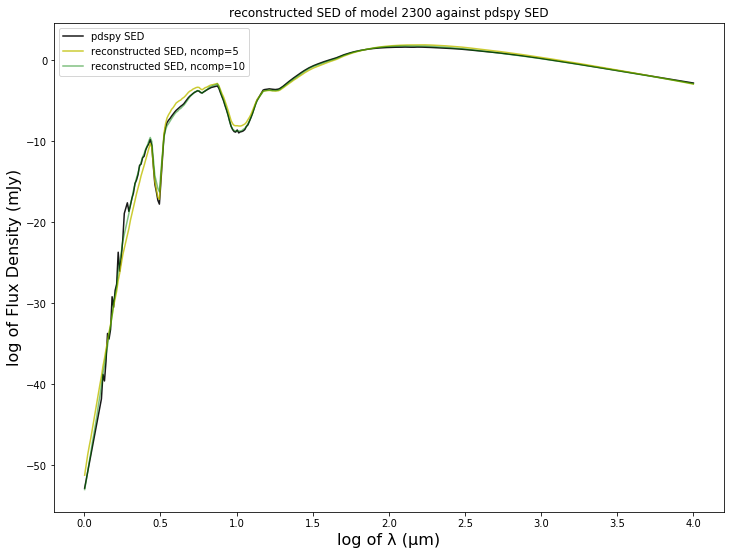

223


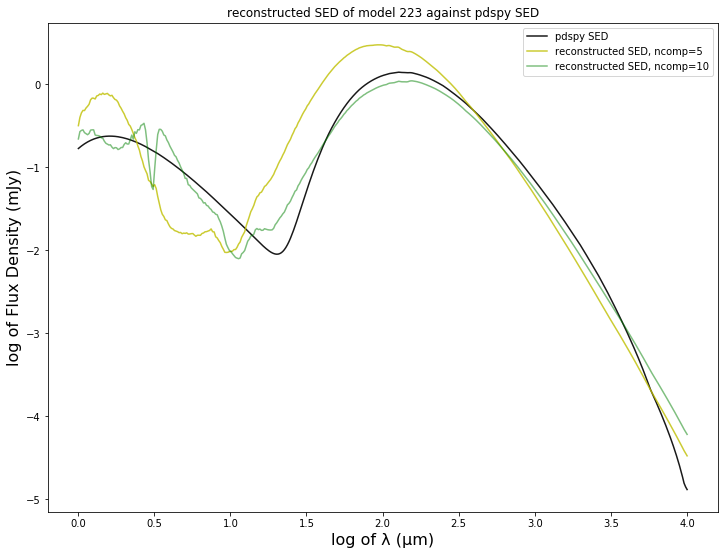

2590


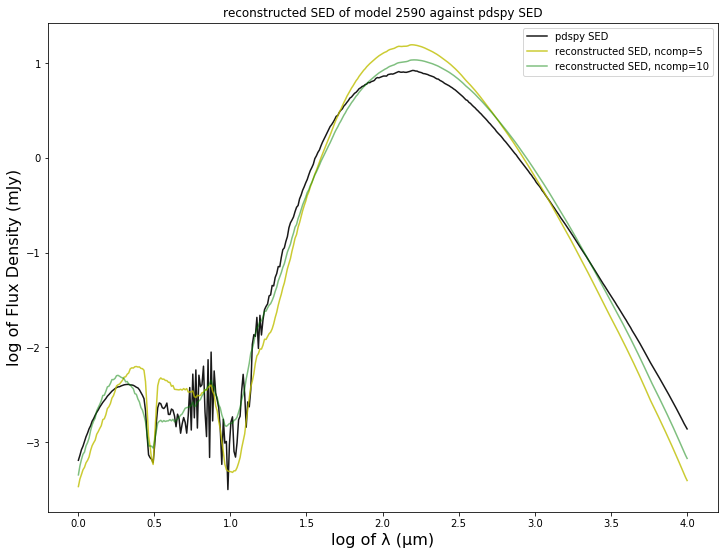

1620


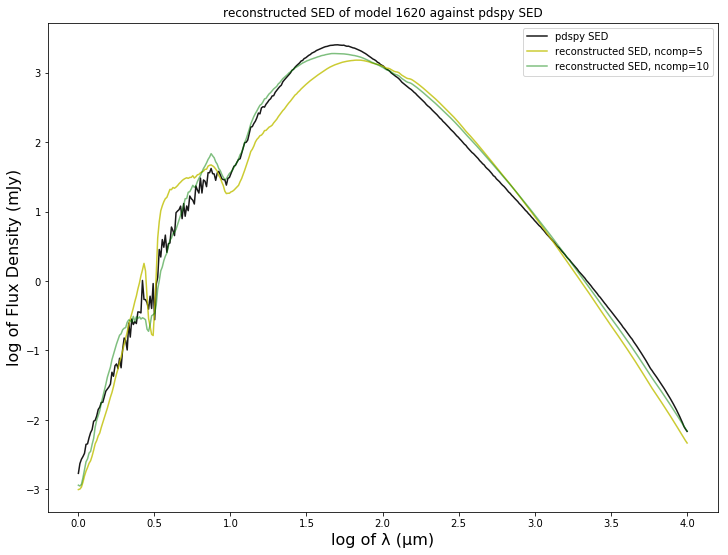

3465


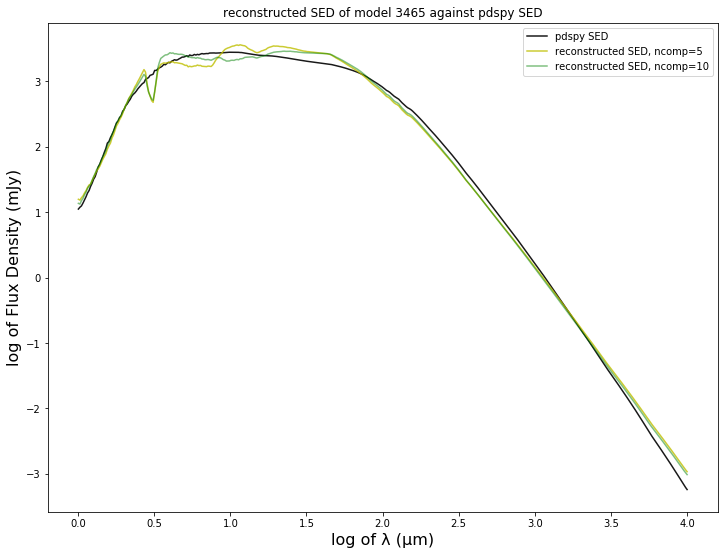

1841


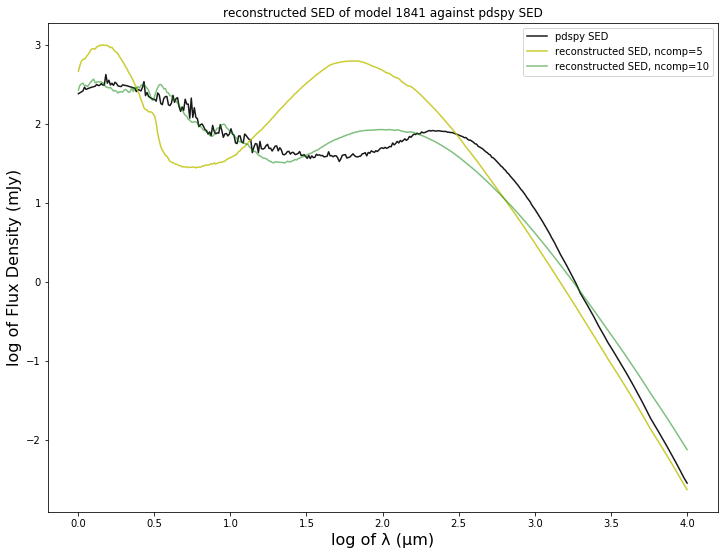

2885


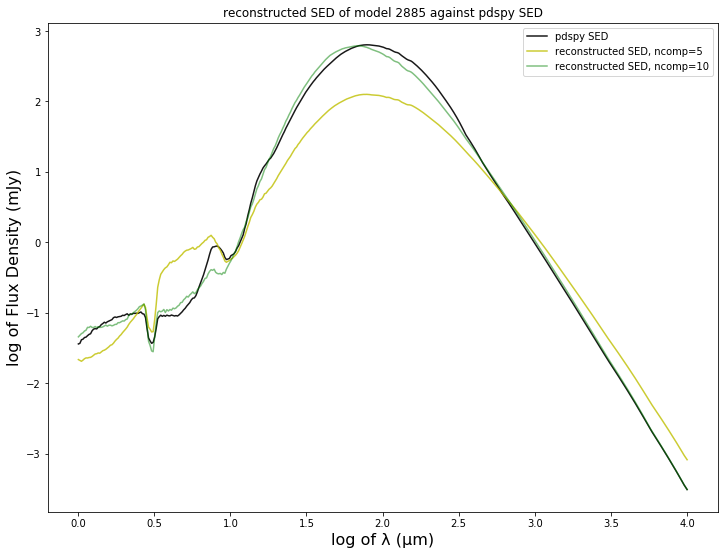

2009


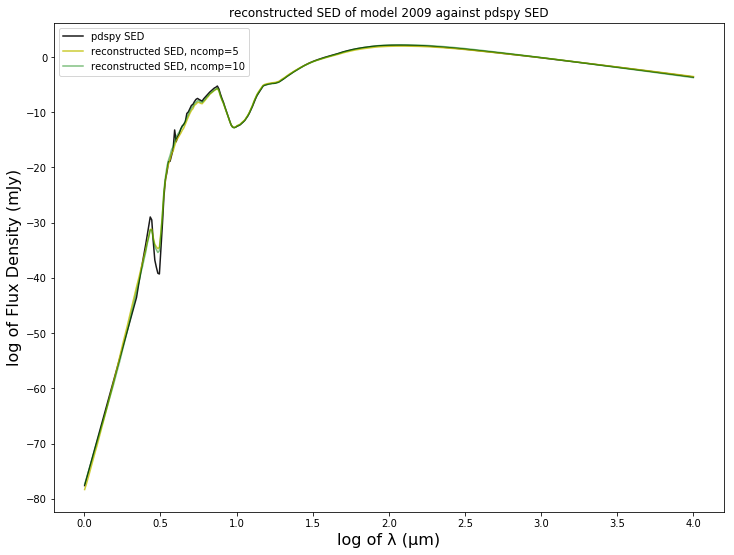

1607


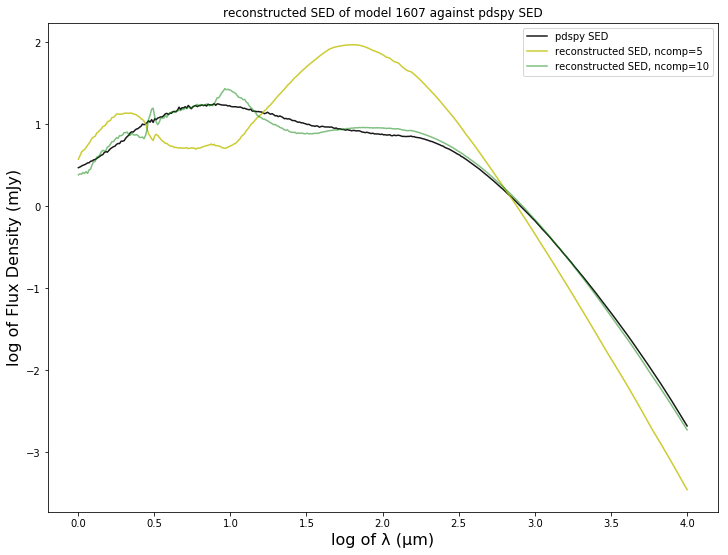

2147


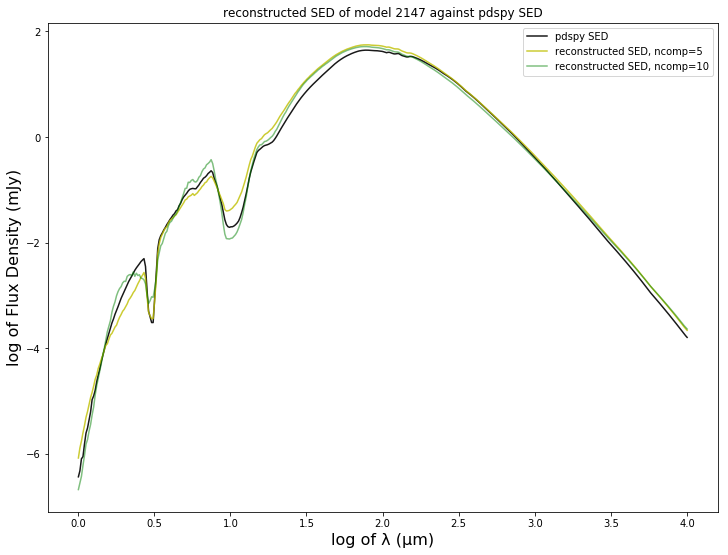

In [75]:
which=2
cube=cubes_cut[which]
nancube=nancubes_cut[which]

seds_msub = cube - np.nanmean(nancube,axis=1)[:,np.newaxis]

t0 = time()
pca = PCA(n_components=40).fit(seds_msub)
print("done in %0.3fs" % (time() - t0))

eigenseds=np.array(pca.components_)

for j in range(10):
    print(dropped[which][j])
    sedcomp_5_10_15(j)

done in 0.052s


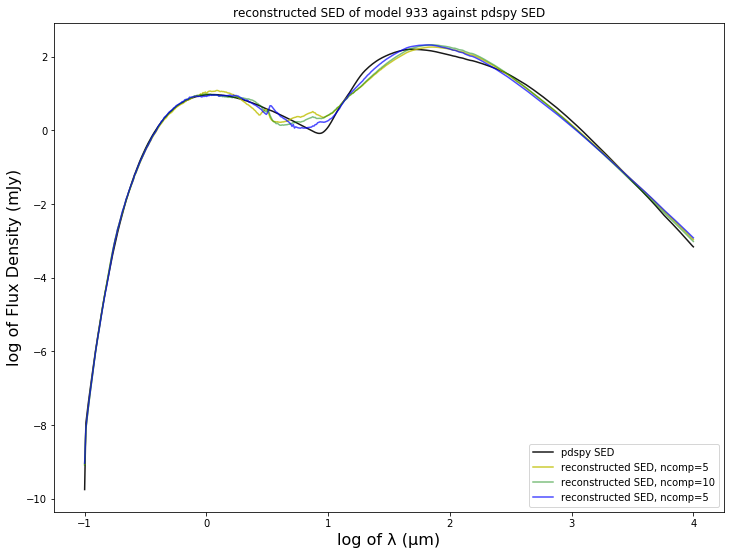

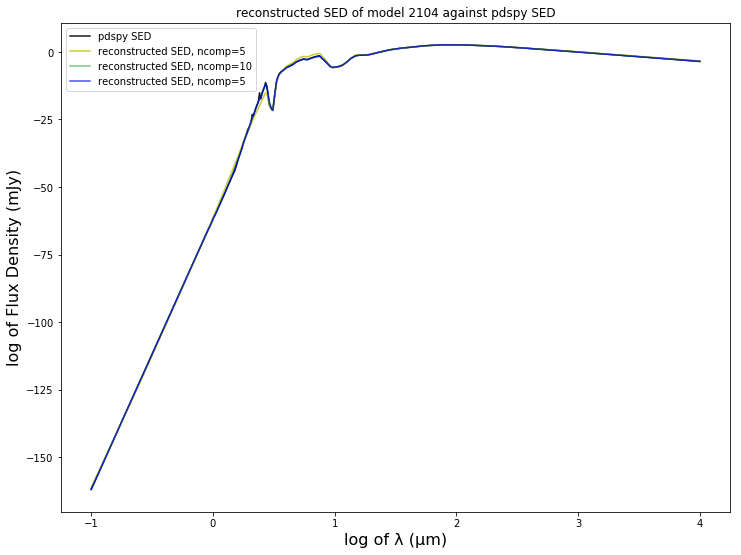

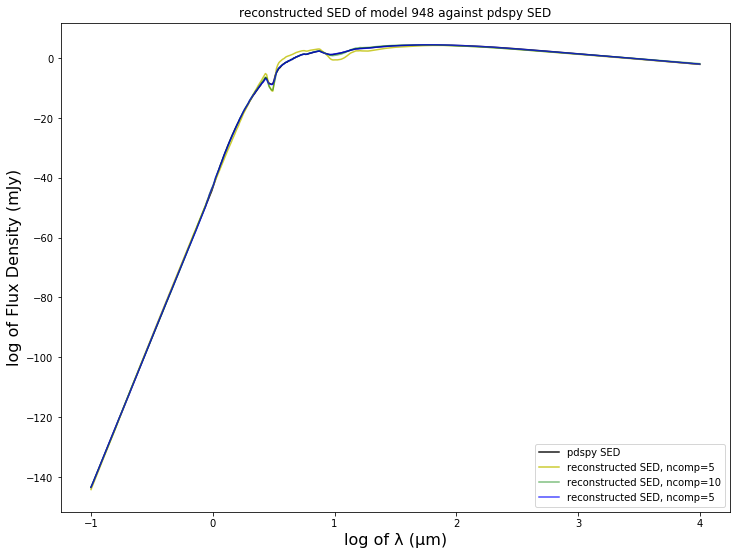

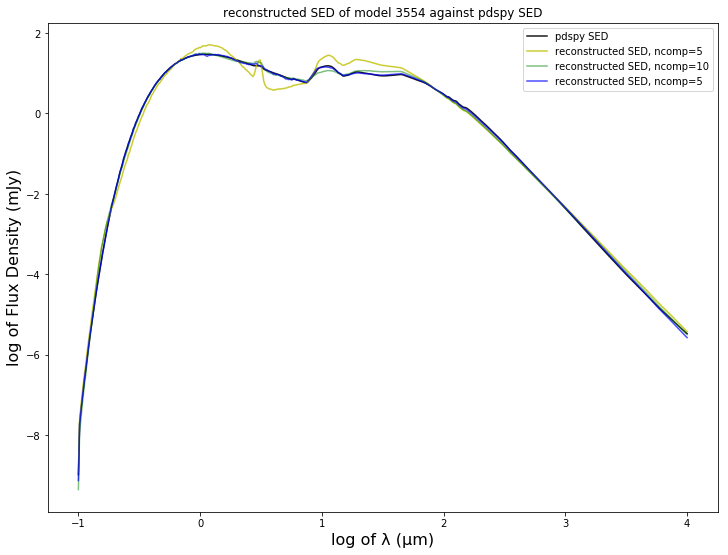

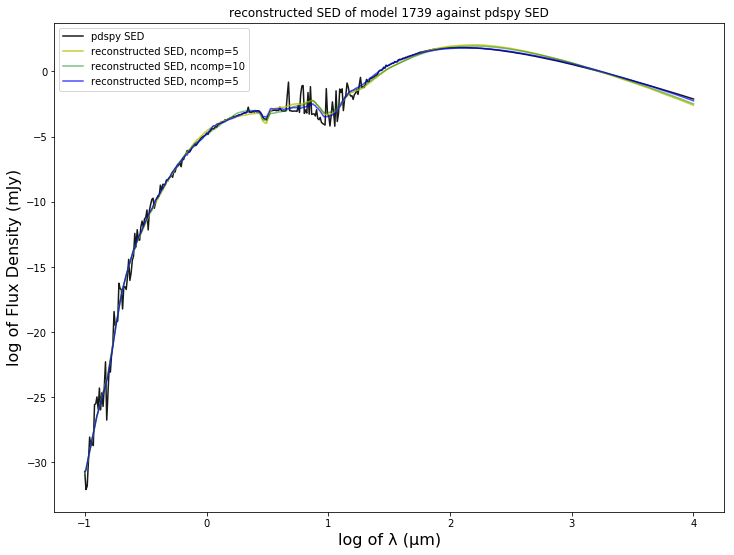

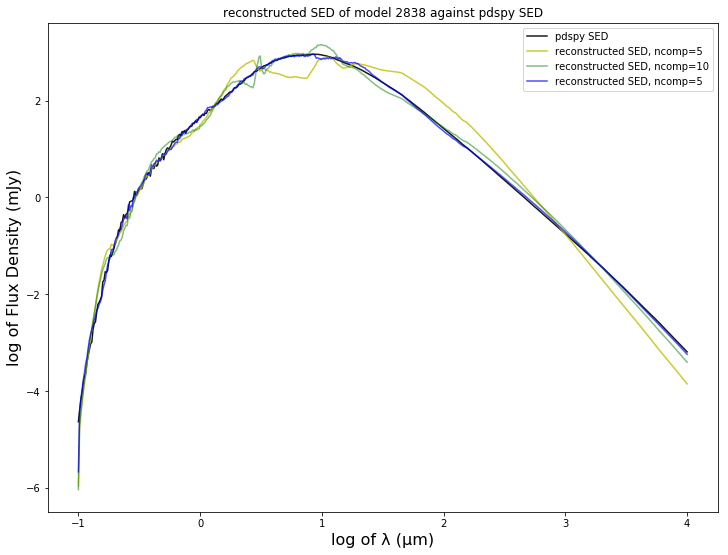

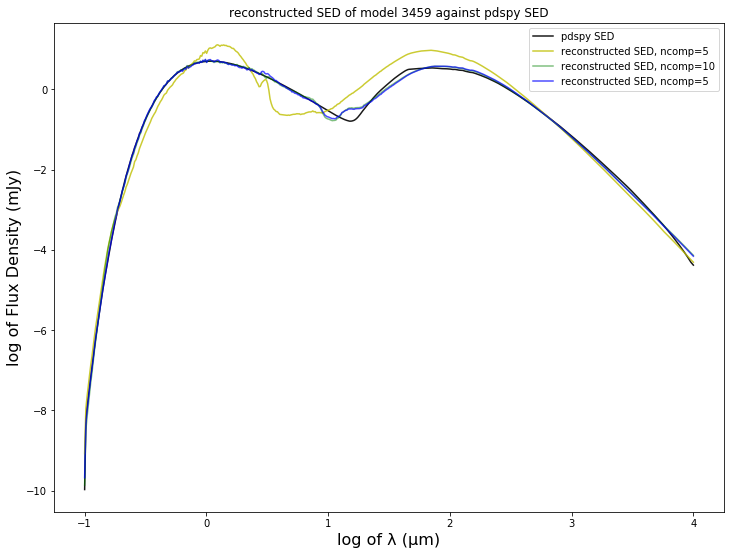

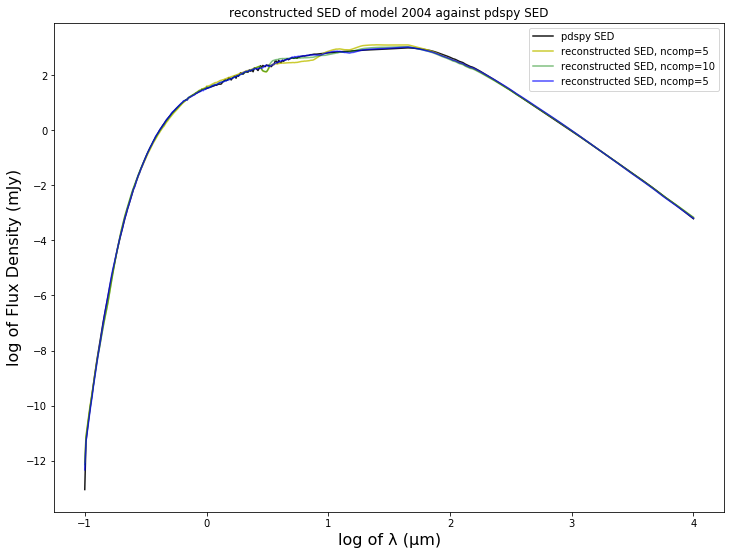

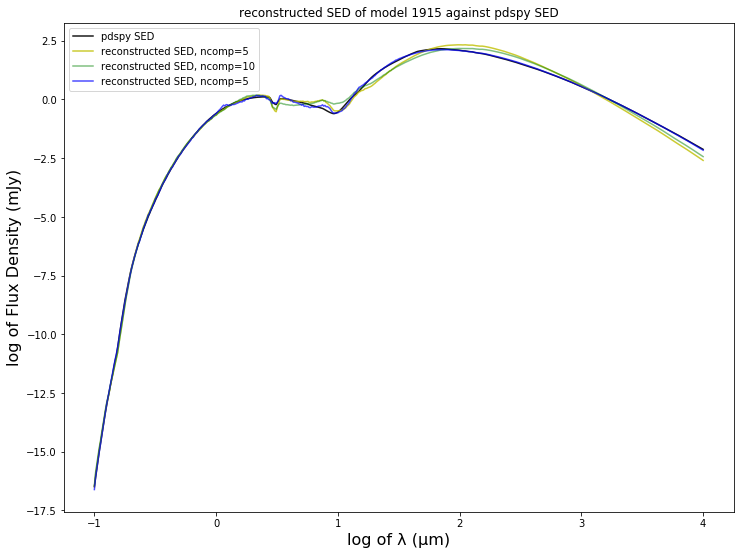

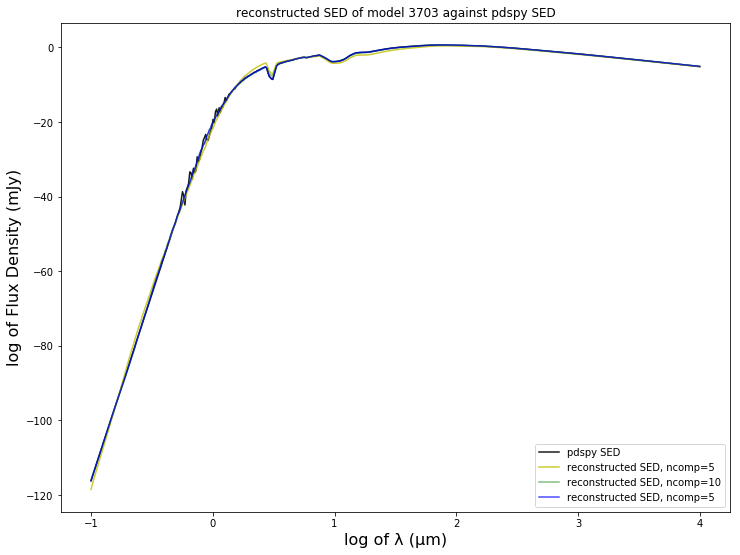

In [16]:
which=3
cube=cubes_cut[which]
nancube=nancubes_cut[which]

seds_msub = cube - np.nanmean(nancube,axis=1)[:,np.newaxis]

t0 = time()
pca = PCA(n_components=40).fit(seds_msub)
print("done in %0.3fs" % (time() - t0))

eigenseds=np.array(pca.components_)

for j in range(10):
    print()
    sedcomp_5_10_15(j)

done in 0.049s
3641


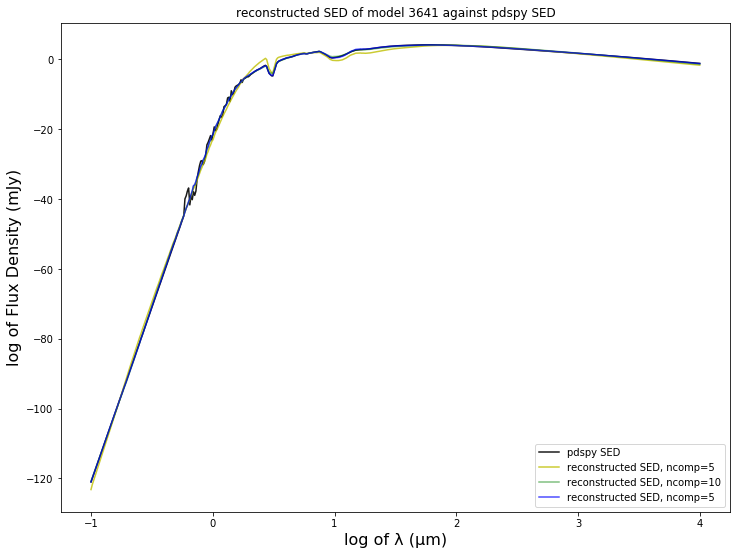

3667


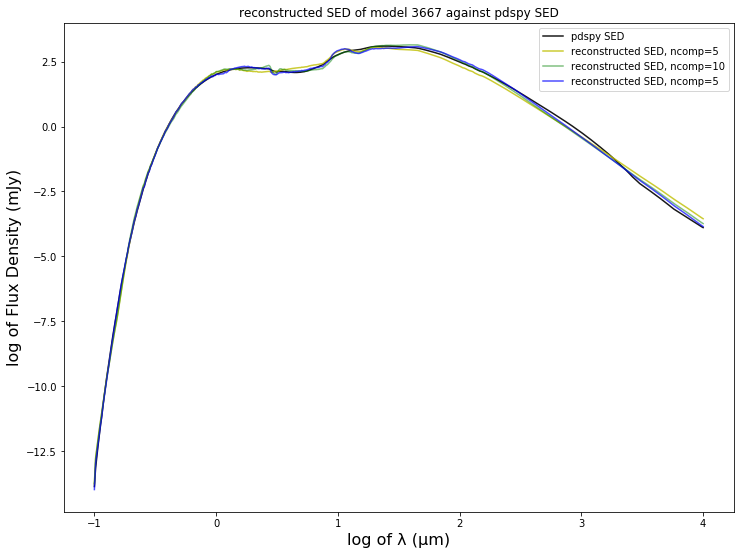

2842


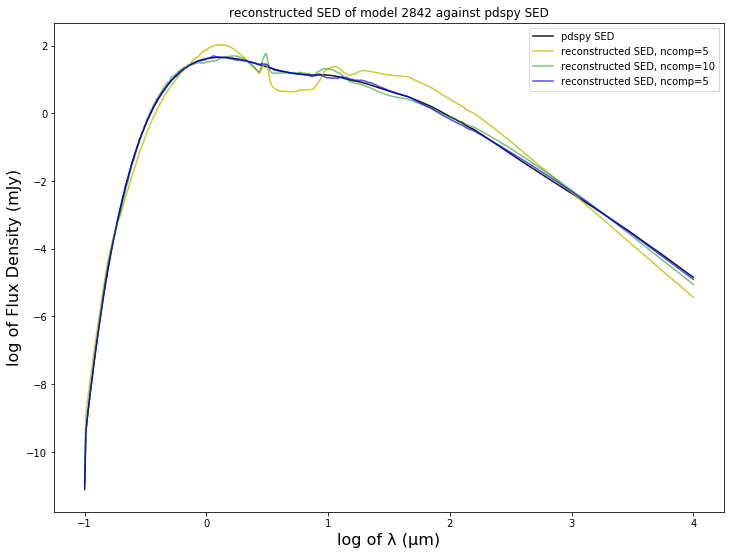

1279


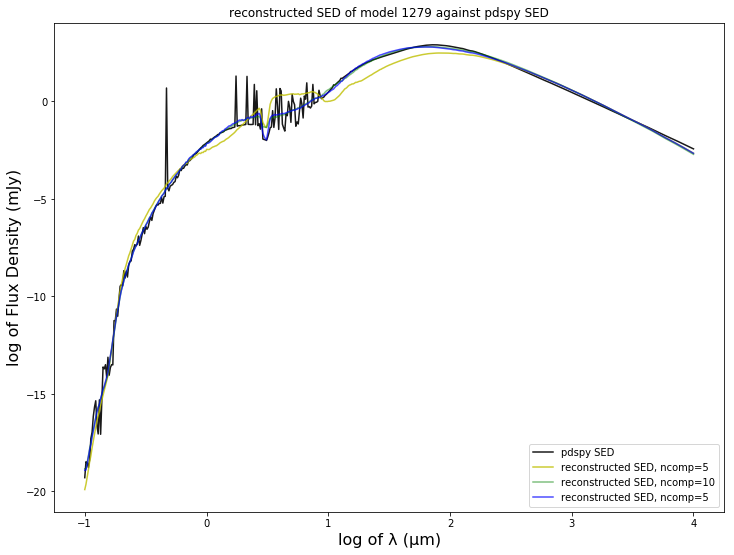

3792


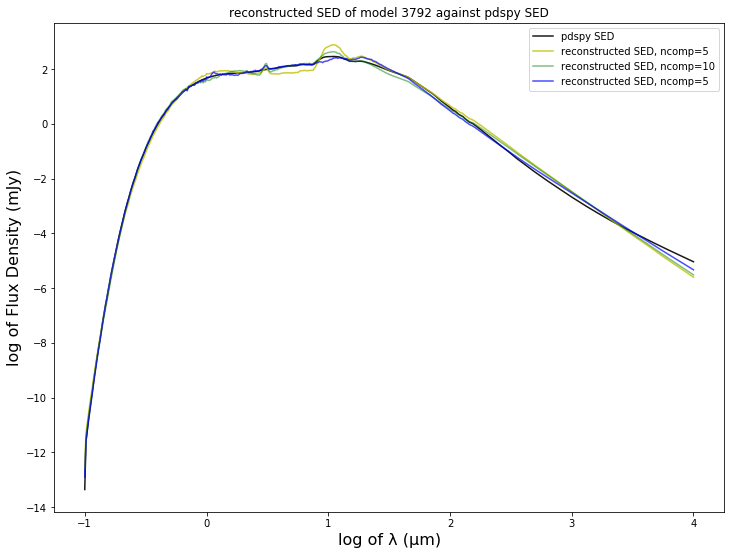

3487


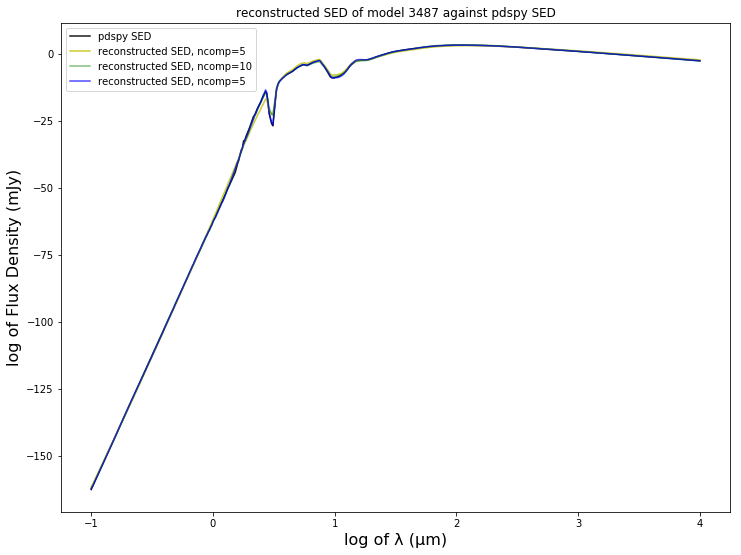

1619


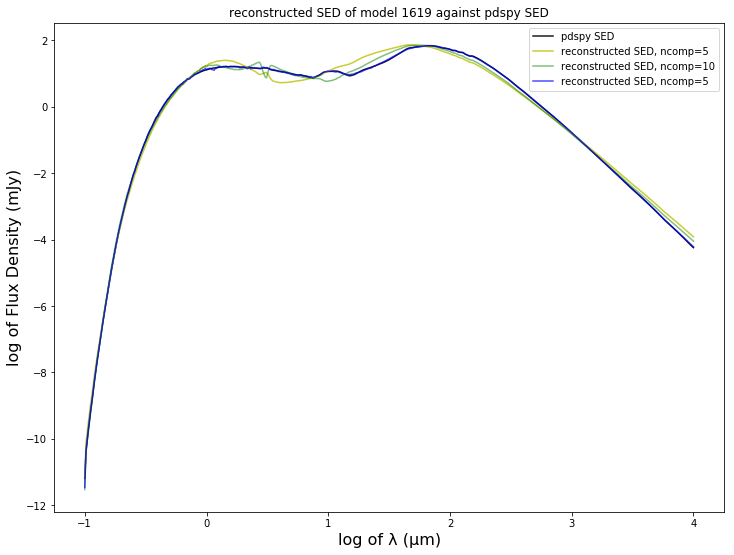

3810


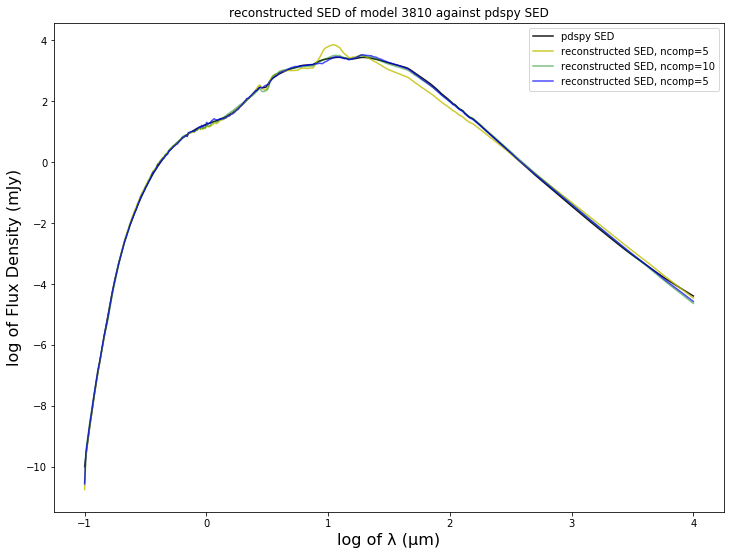

1672


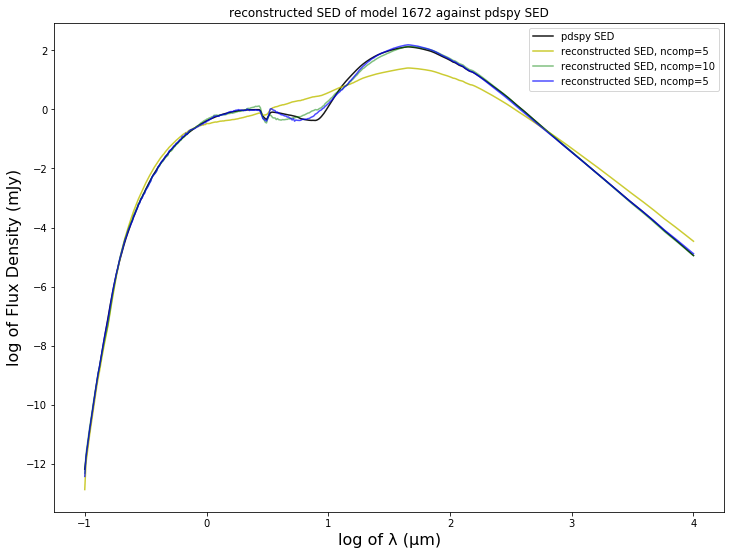

3648


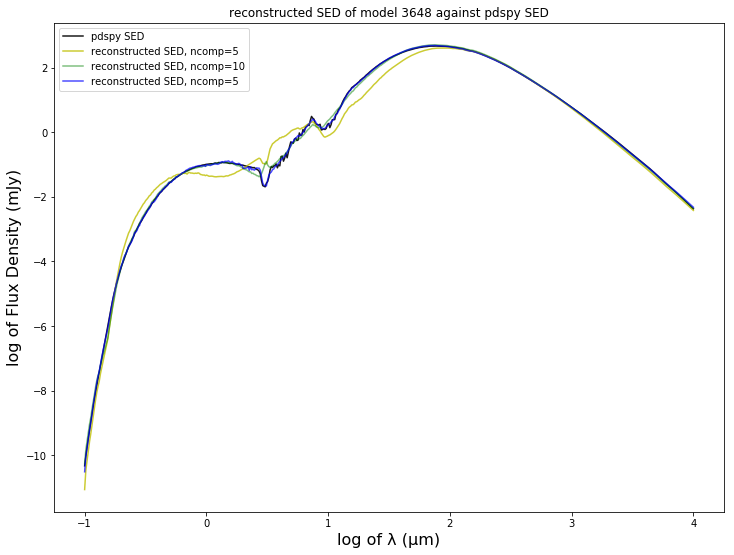

In [20]:
which=4
cube=cubes_cut[which]
nancube=nancubes_cut[which]

seds_msub = cube - np.nanmean(nancube,axis=1)[:,np.newaxis]

t0 = time()
pca = PCA(n_components=40).fit(seds_msub)
print("done in %0.3fs" % (time() - t0))

eigenseds=np.array(pca.components_)

for j in range(10):
    print(dropped[which][j])
    sedcomp_5_10_15(j)

done in 0.042s
2477


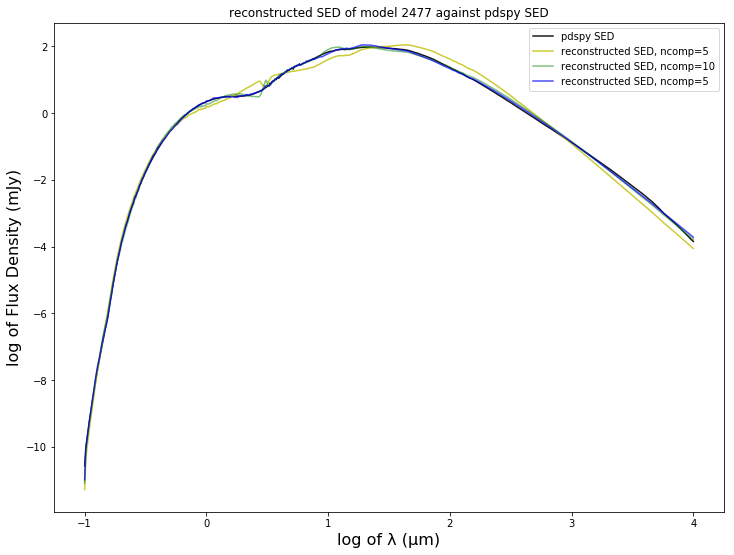

2467


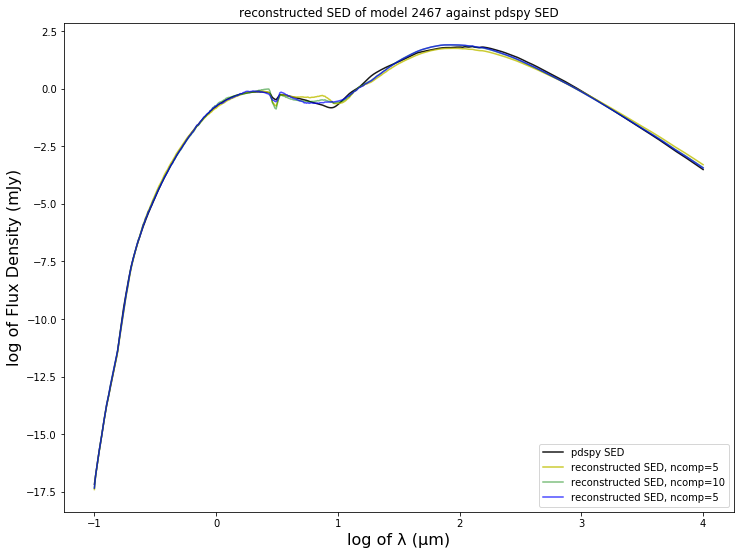

3785


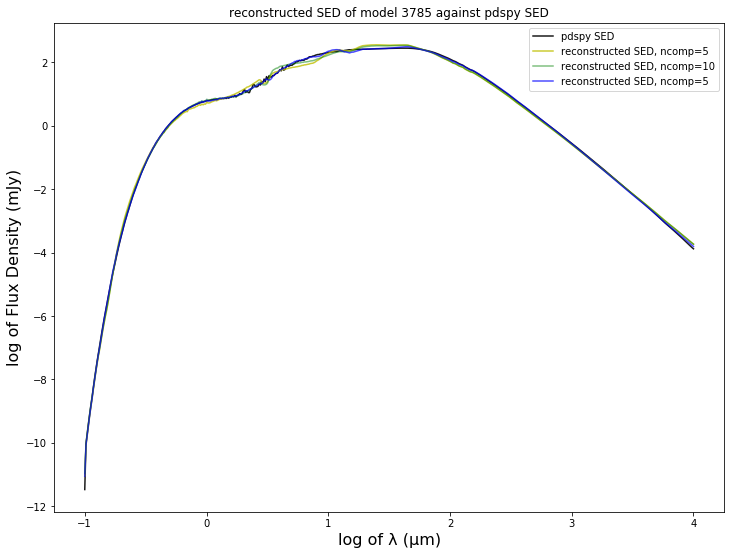

2916


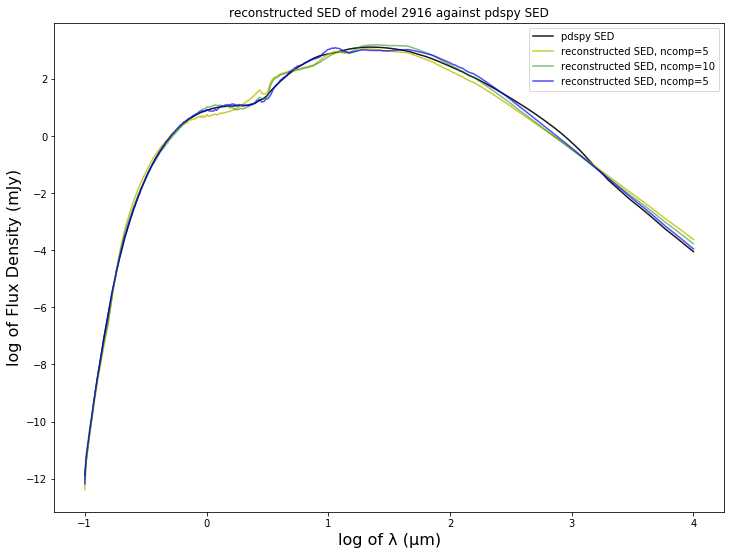

871


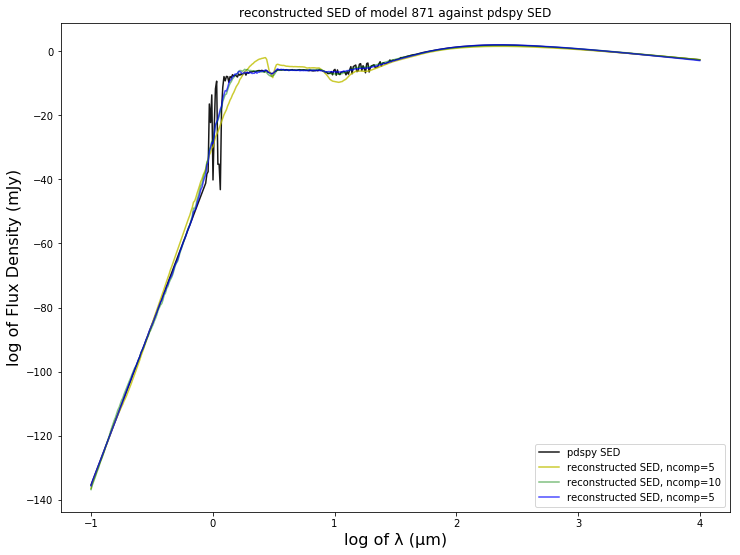

3569


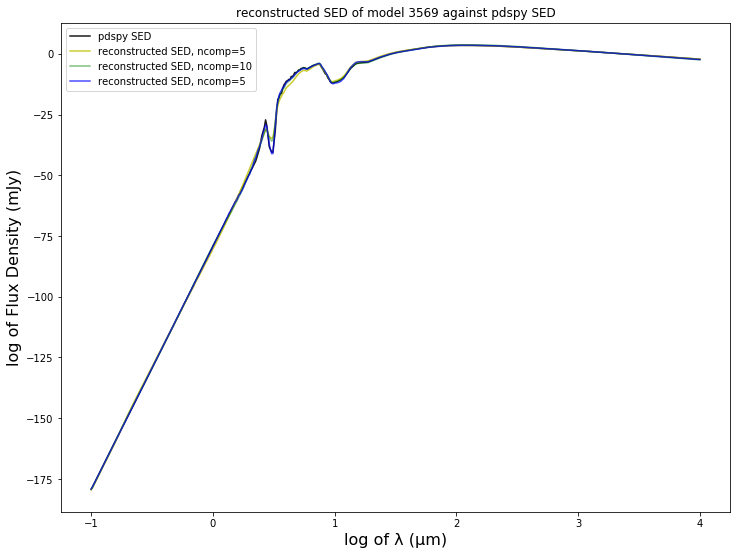

1668


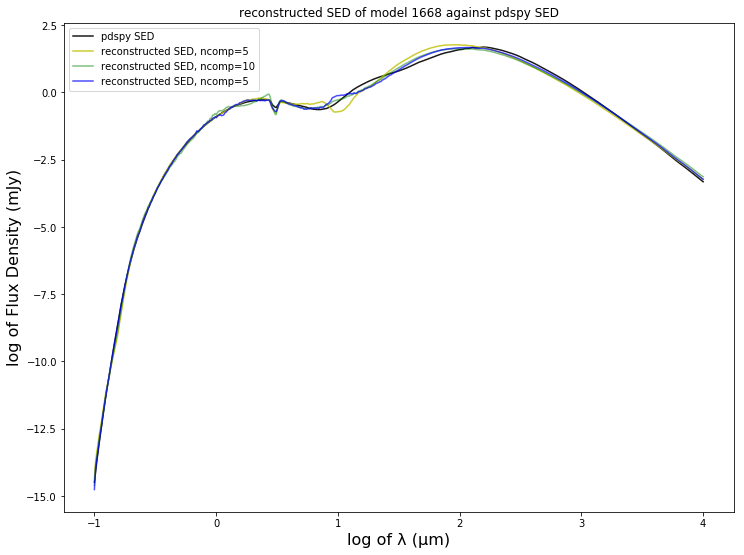

1622


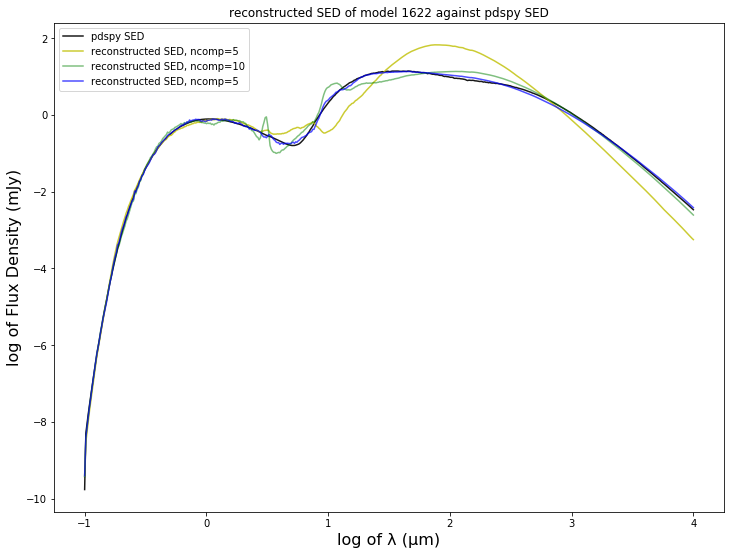

3039


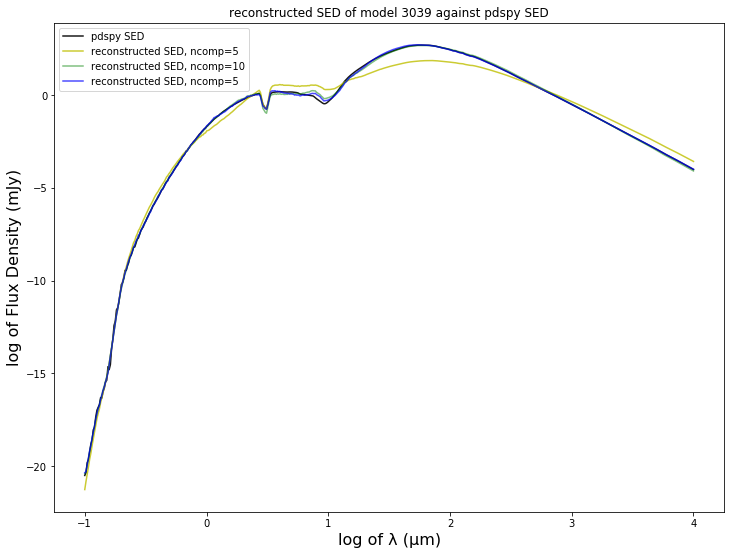

2642


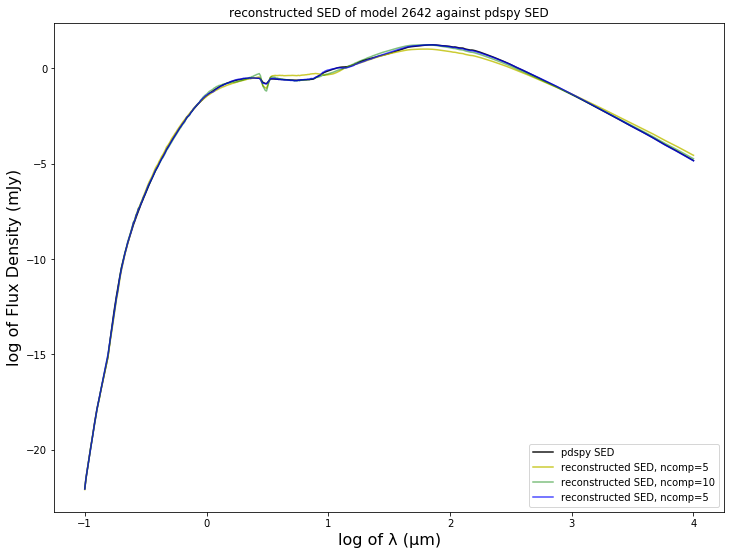

done in 0.043s
2188


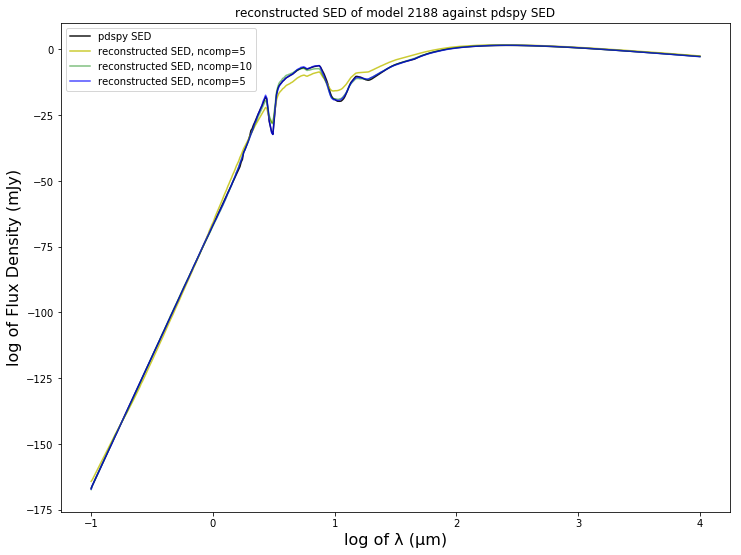

2163


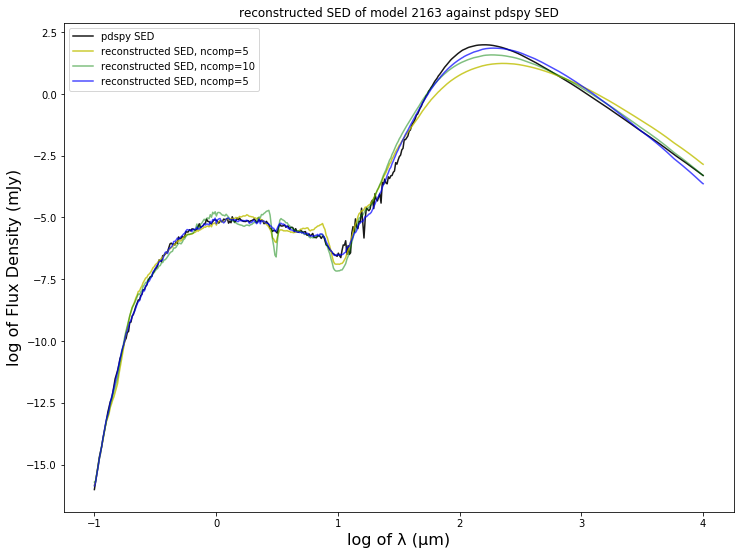

405


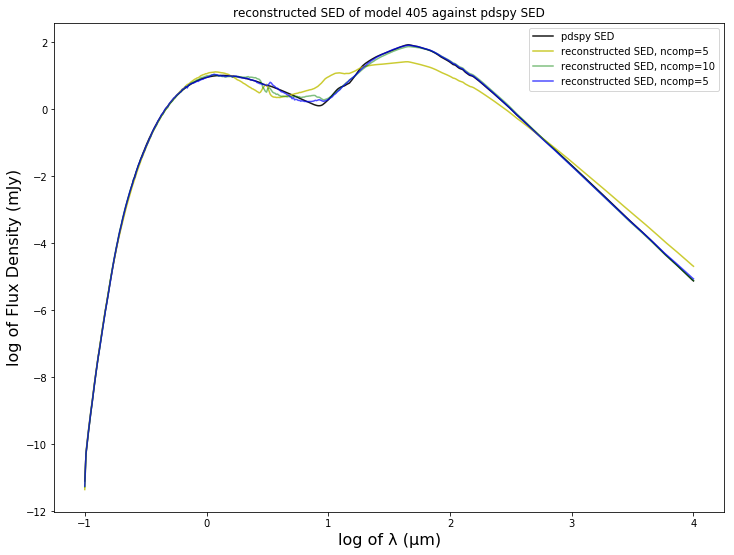

449


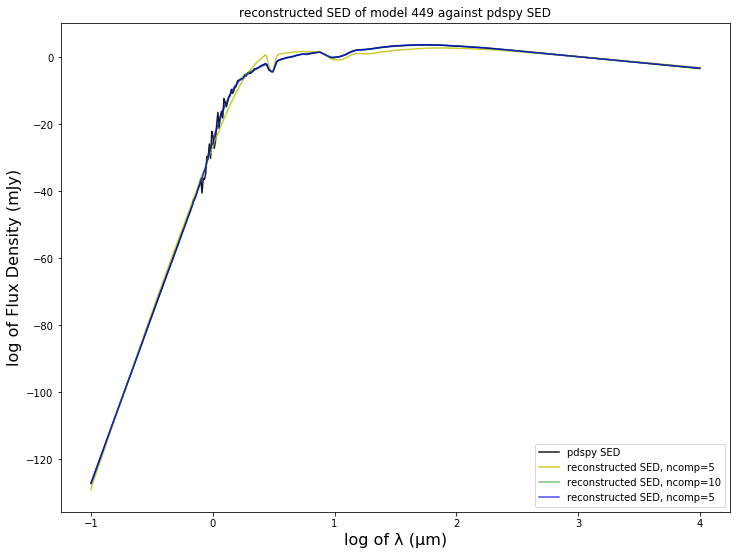

999


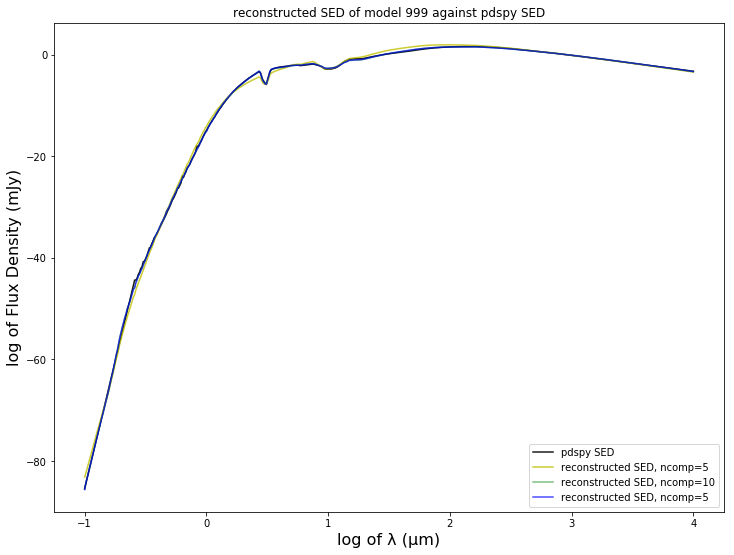

2351


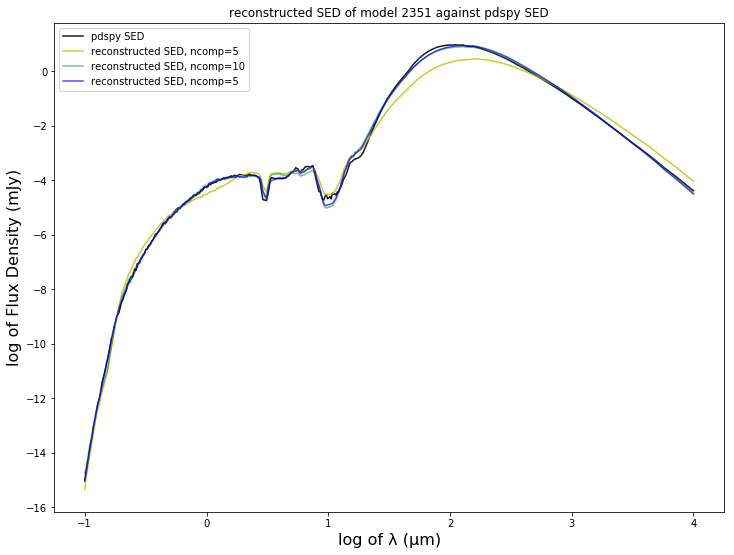

3785


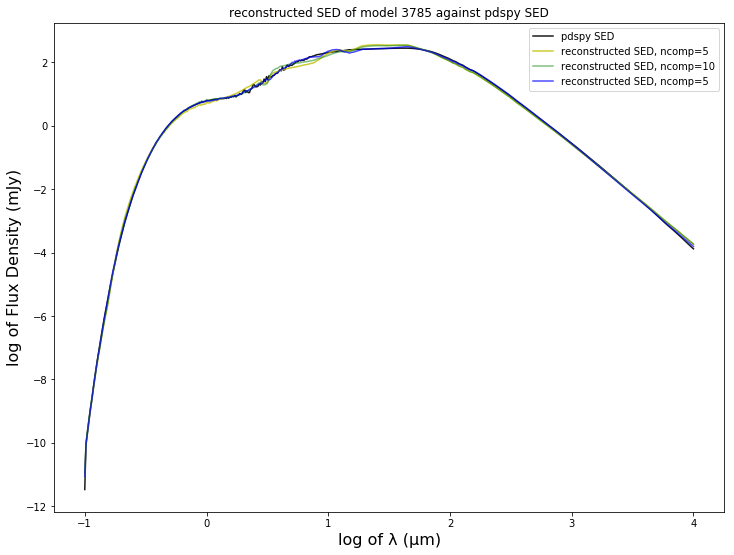

3707


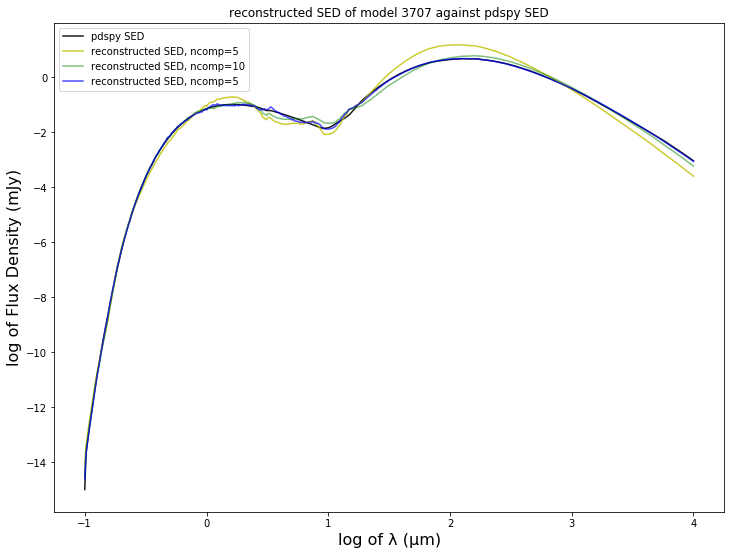

3687


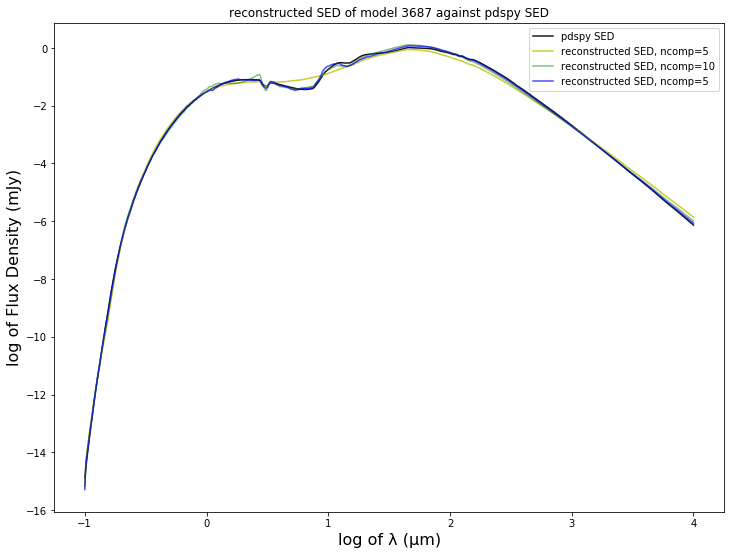

320


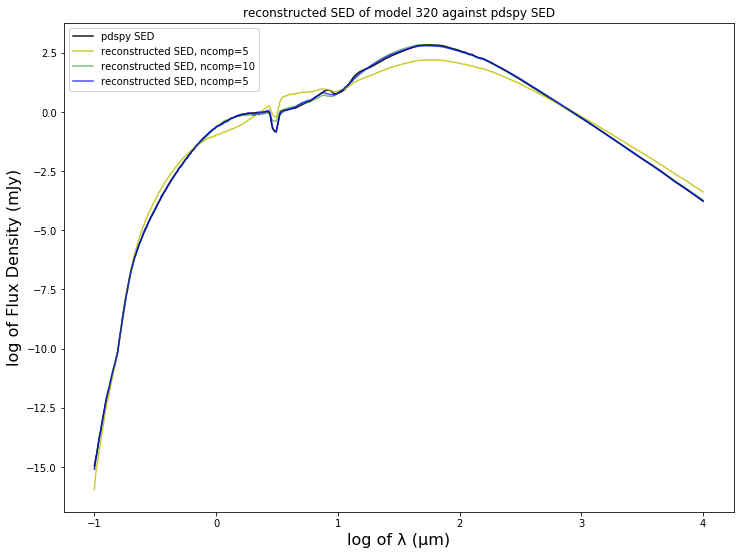

done in 0.039s
2882


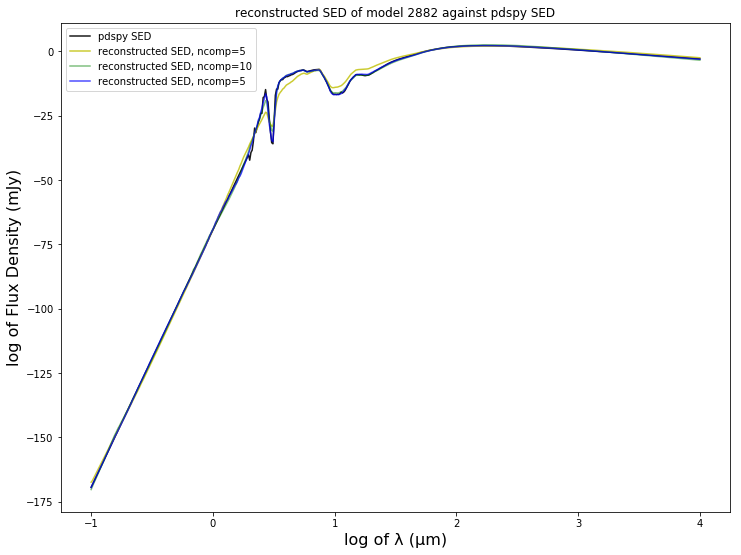

3565


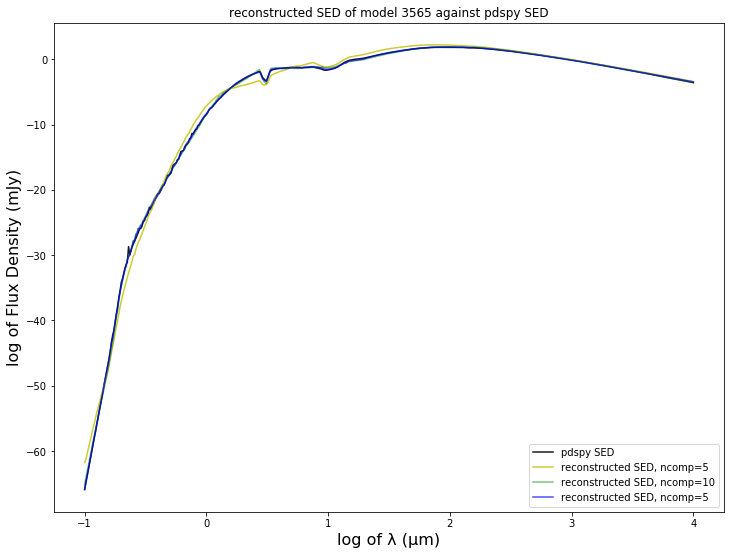

3696


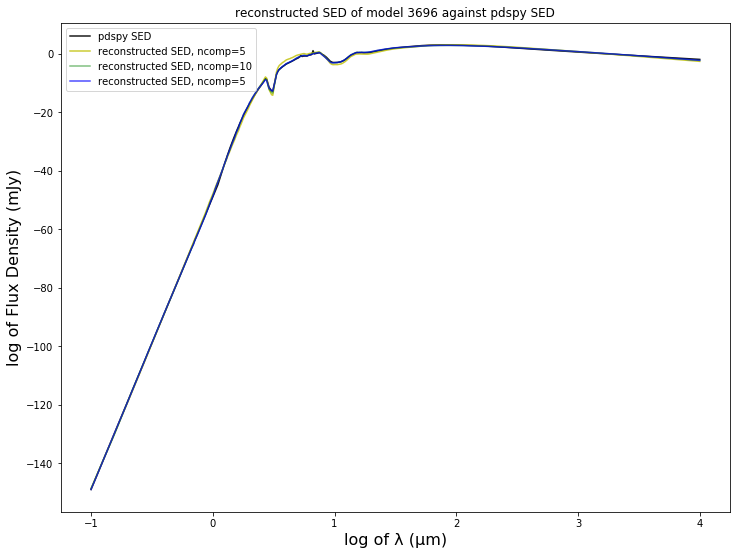

1346


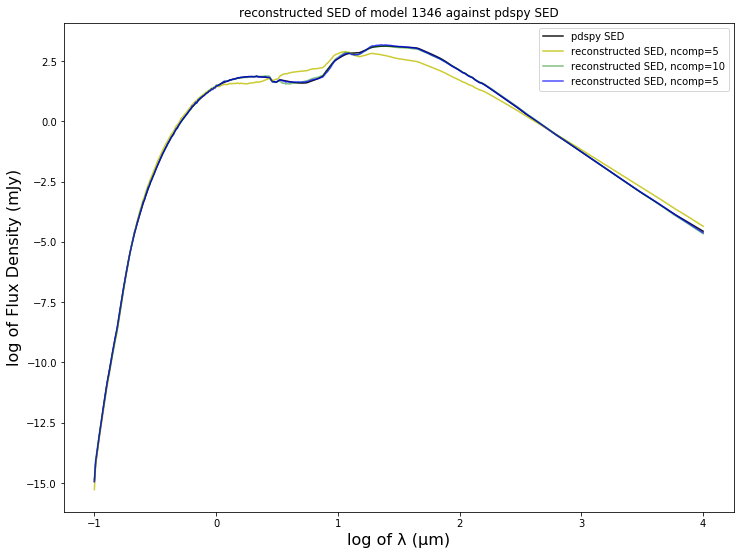

1194


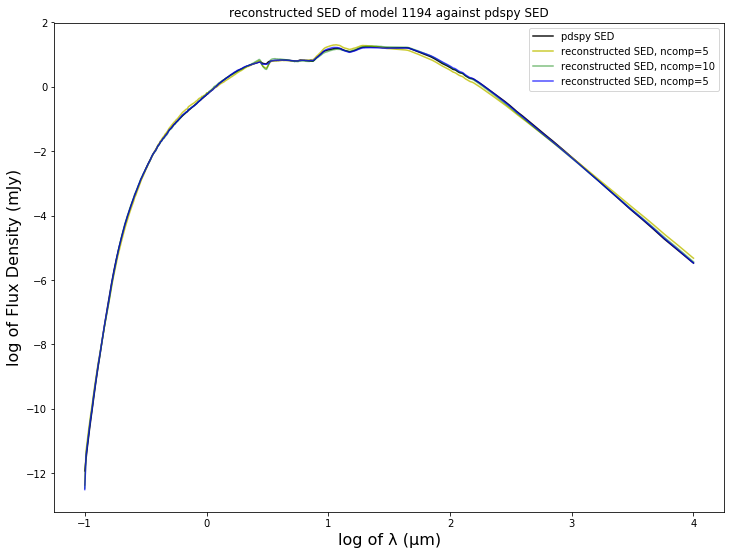

1131


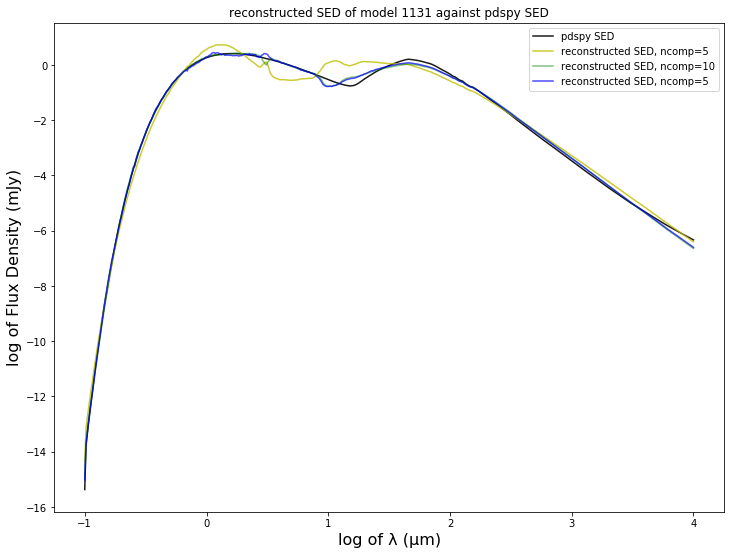

1684


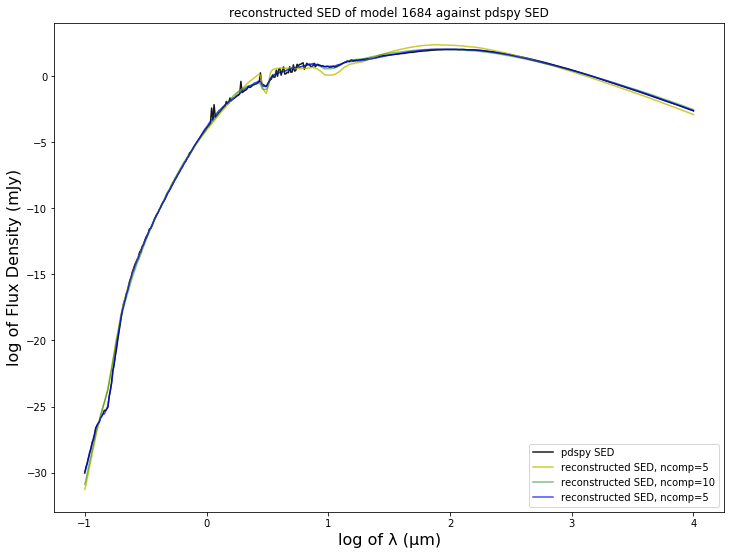

441


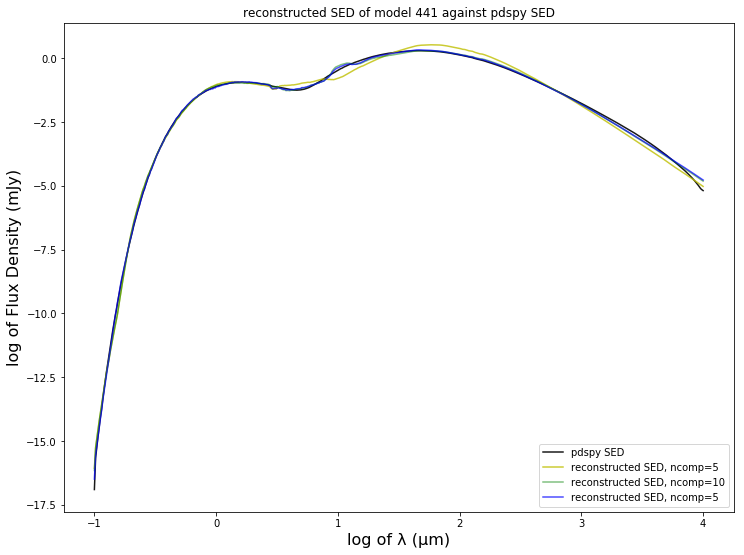

1532


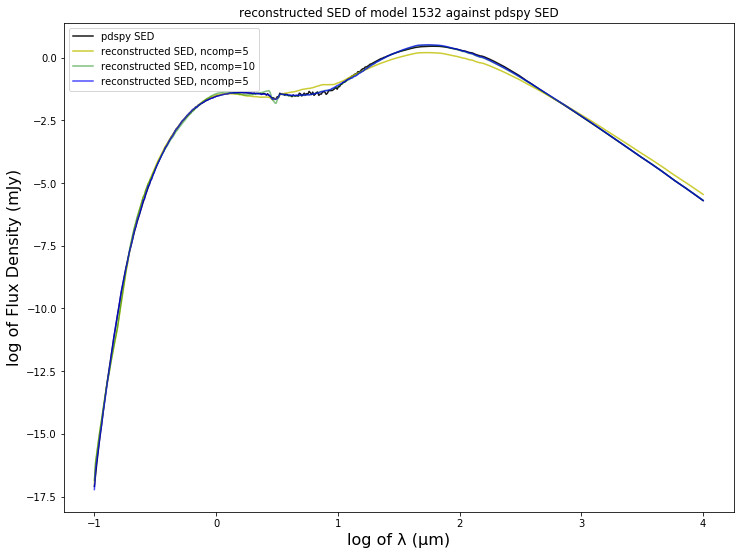

2965


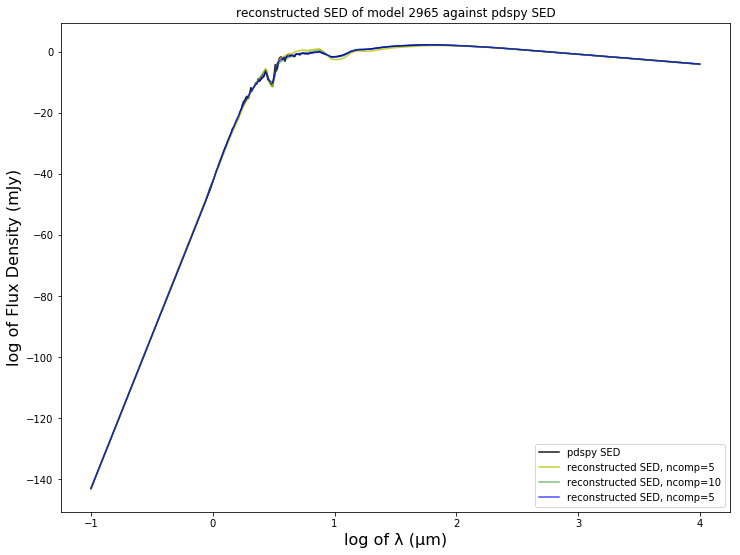

done in 0.039s
3434


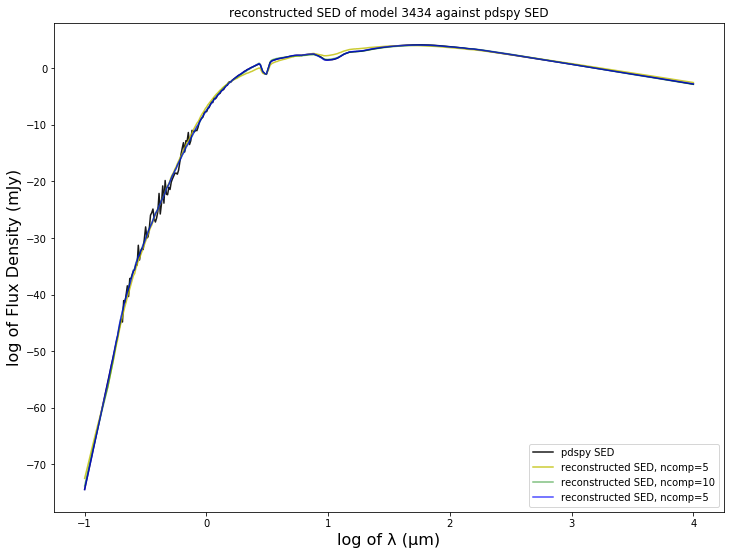

2495


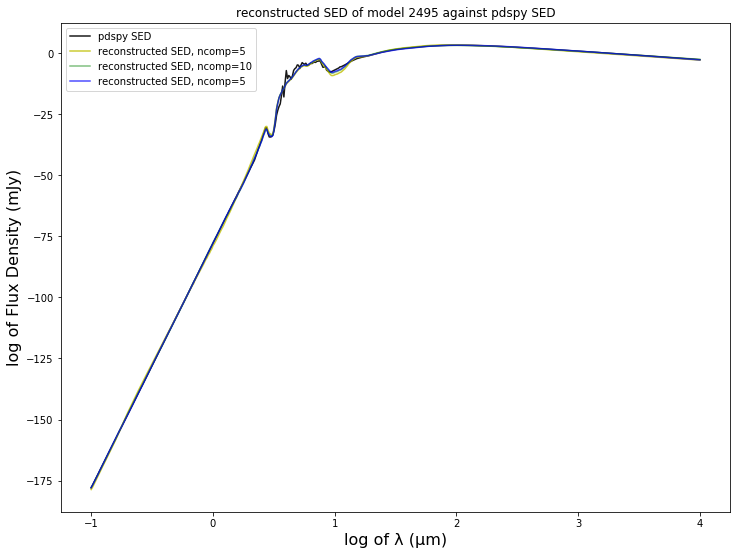

1136


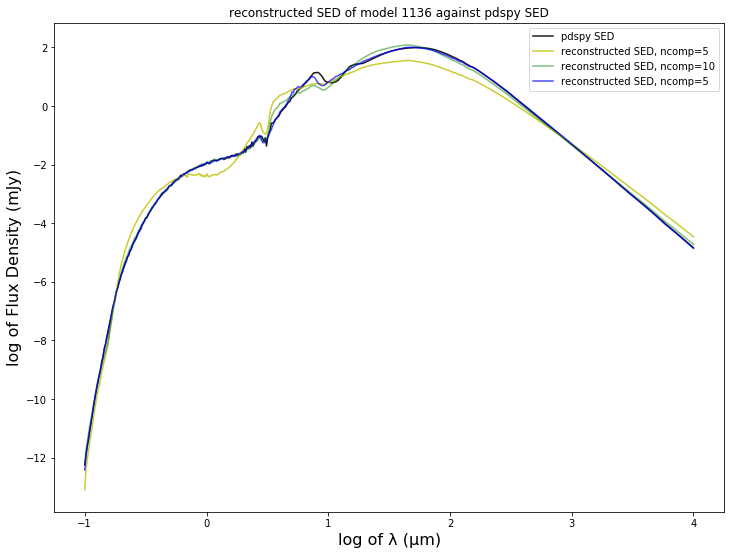

507


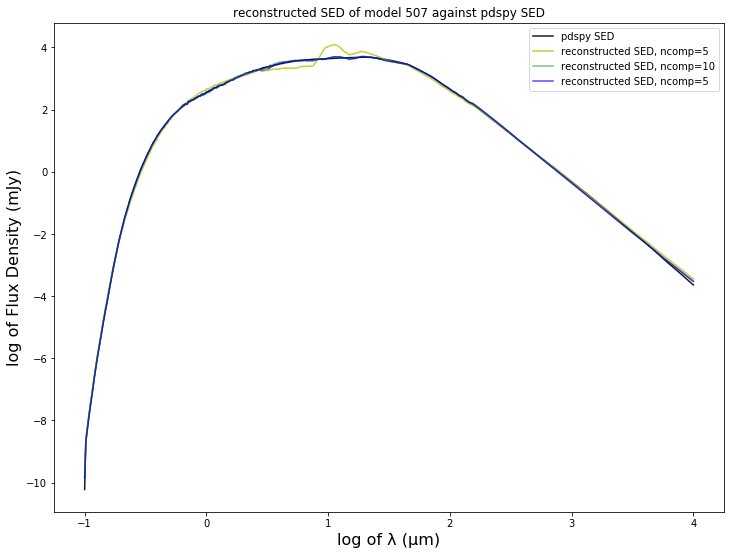

443


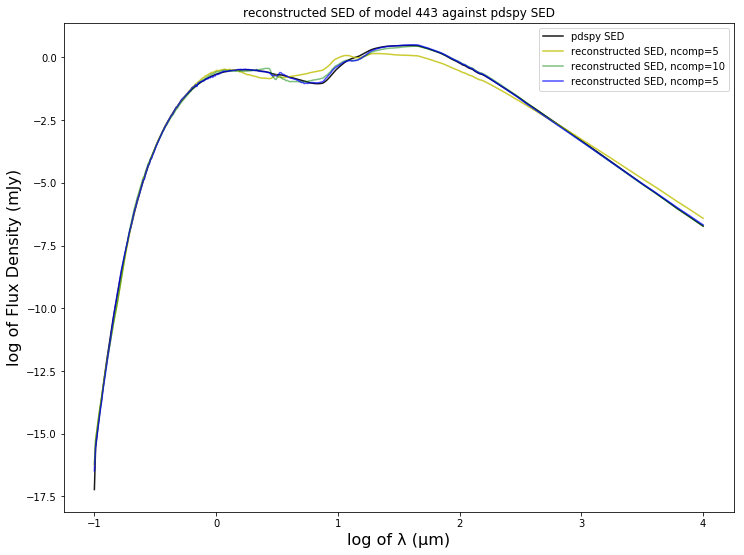

1653


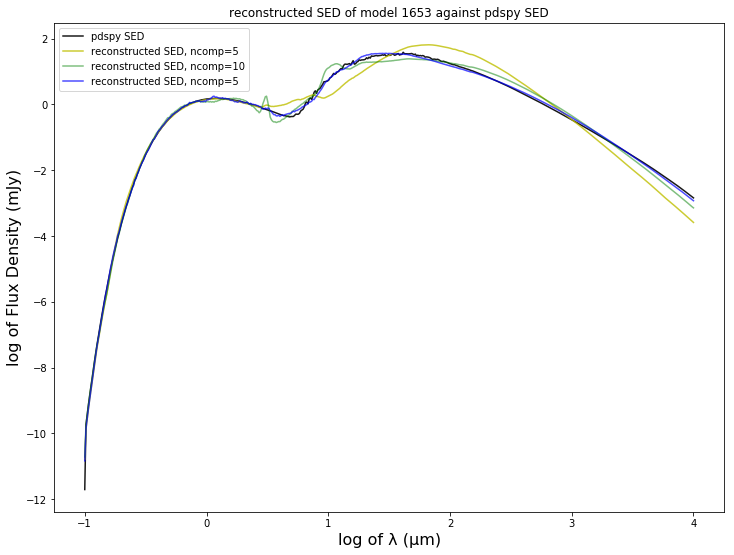

2533


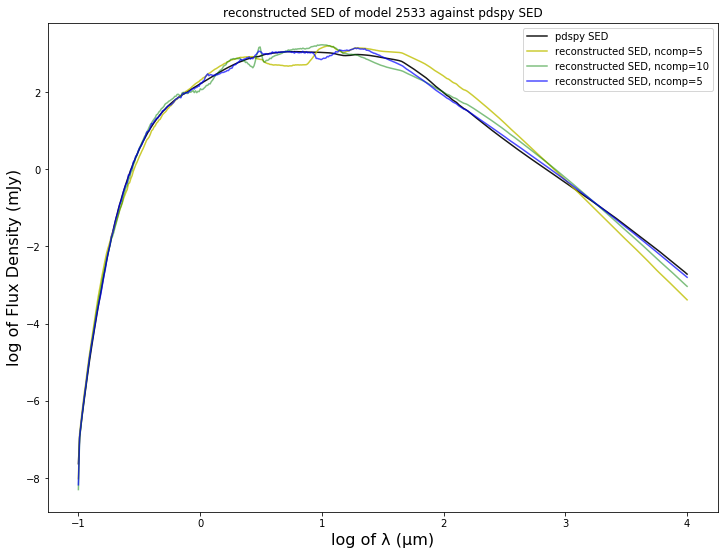

3081


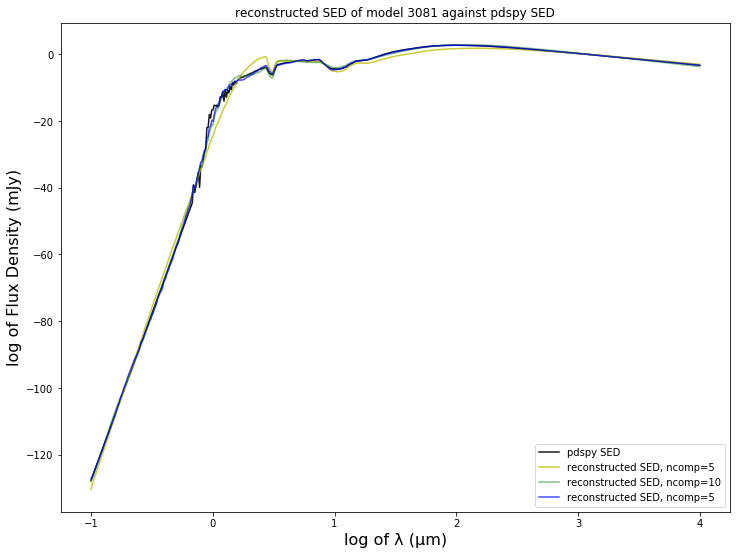

1550


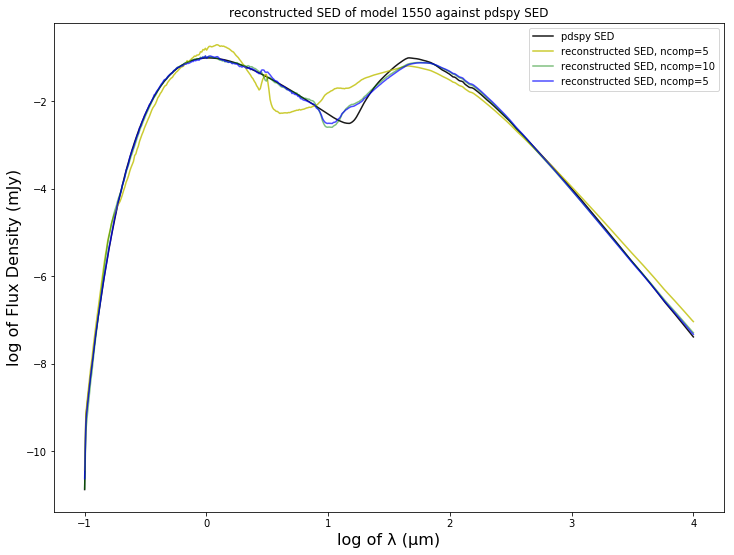

1172


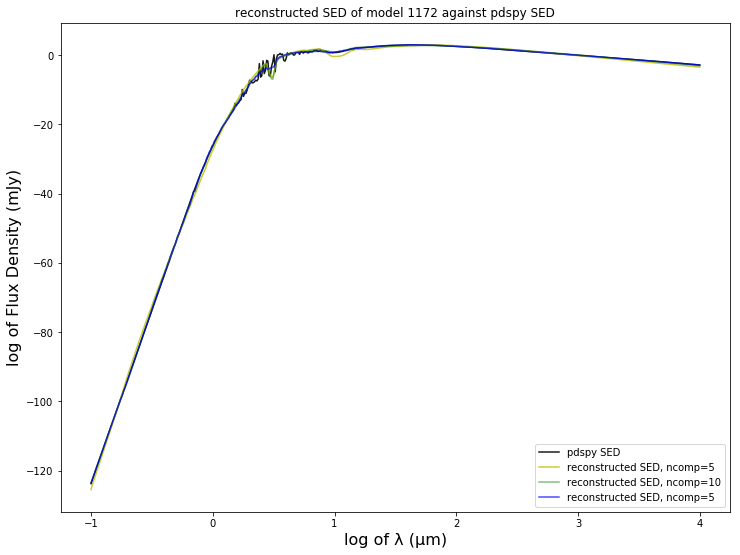

done in 0.041s
2350


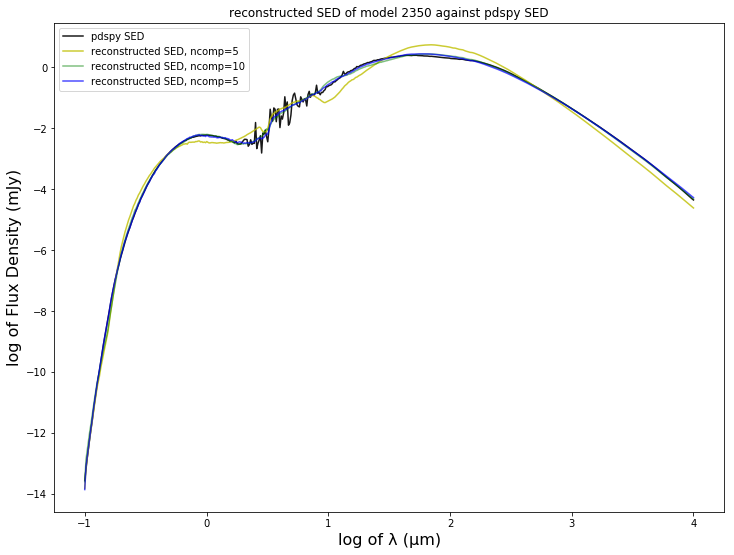

745


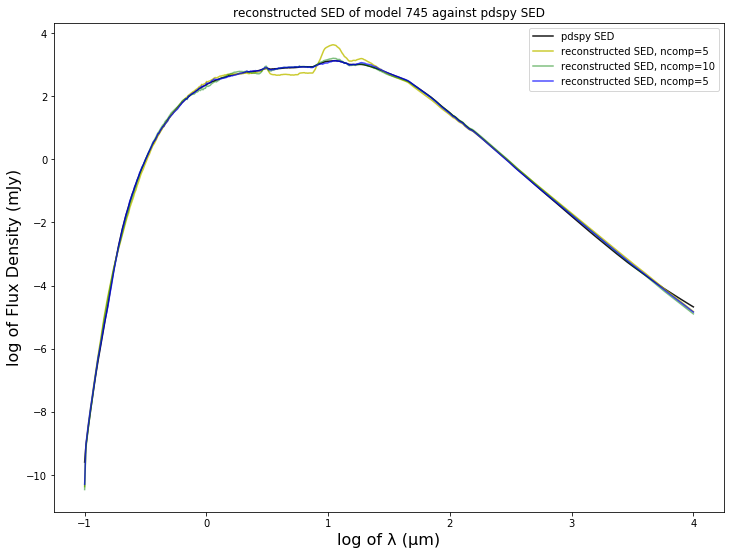

3692


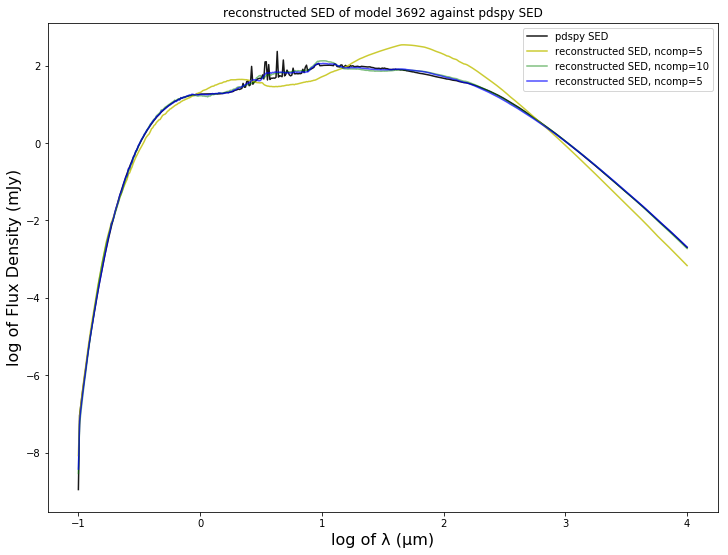

3809


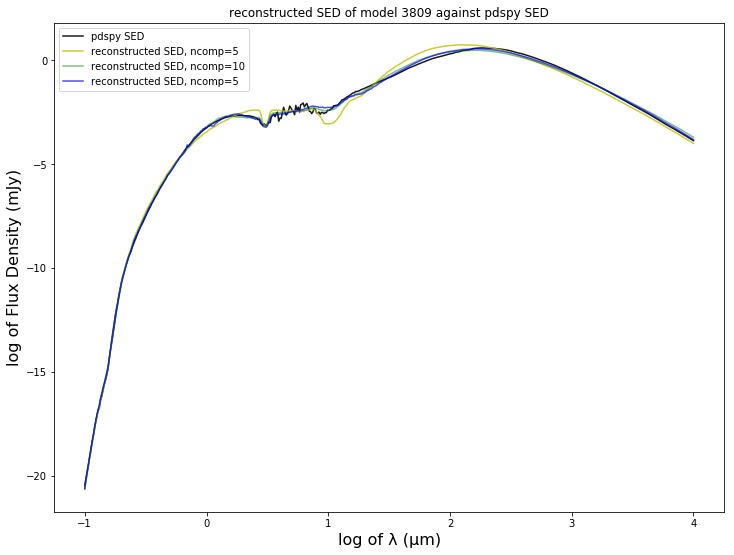

416


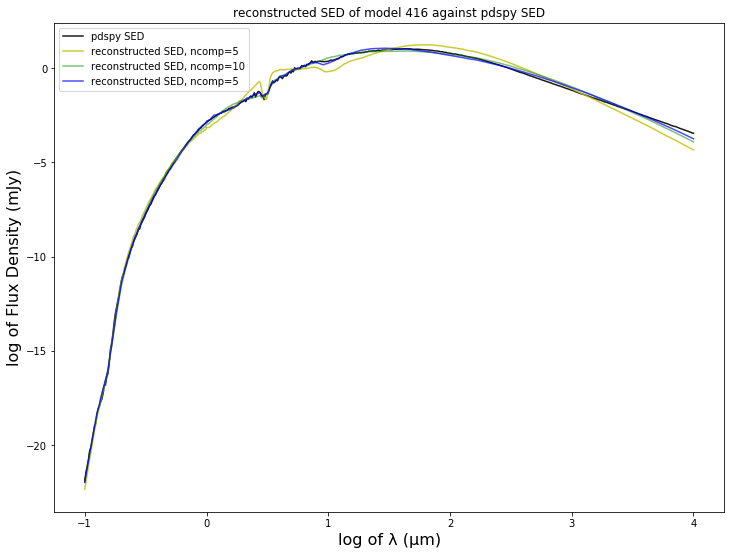

2070


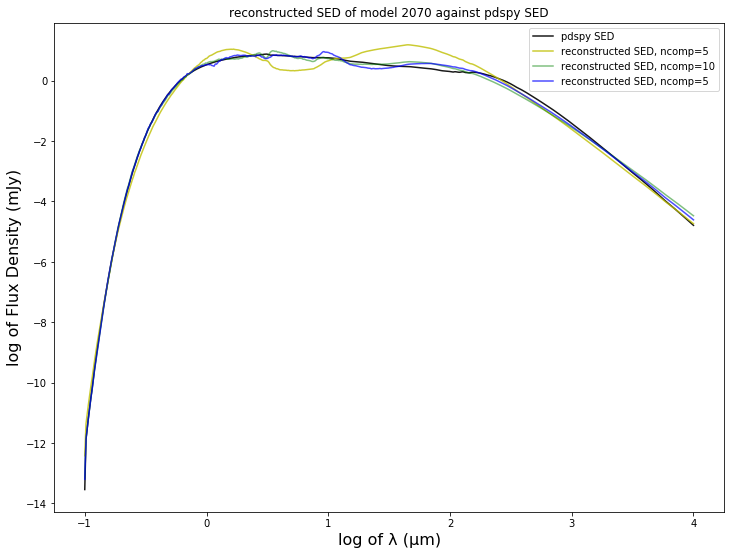

2151


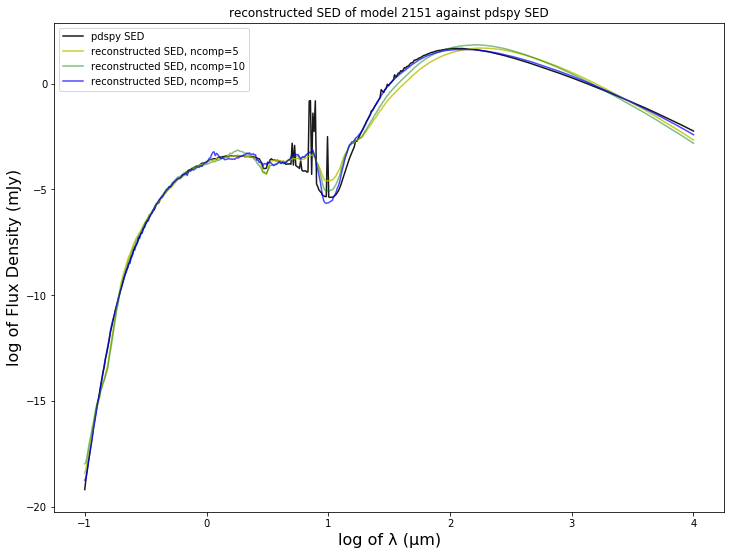

968


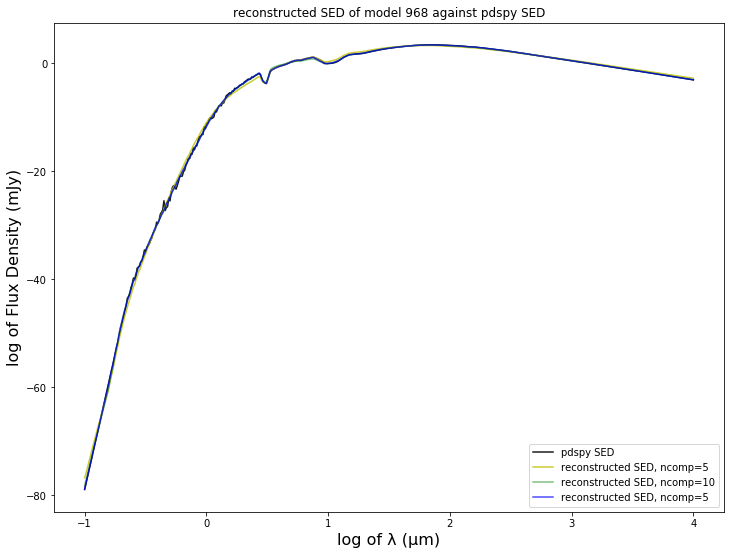

133


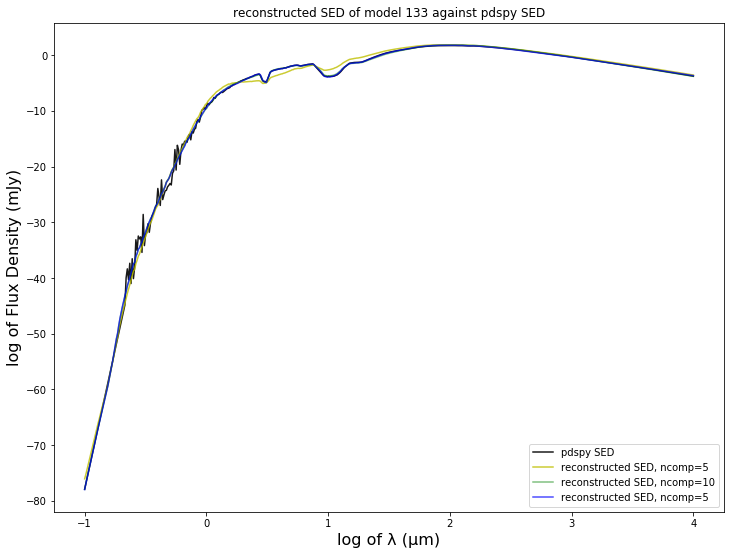

3032


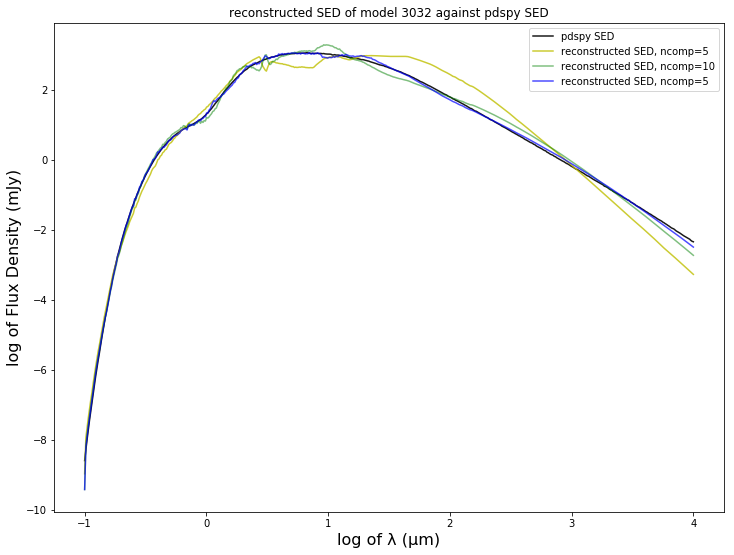

In [21]:
for i in range(5,10):
    which=i
    cube=cubes_cut[which]
    nancube=nancubes_cut[which]

    seds_msub = cube - np.nanmean(nancube,axis=1)[:,np.newaxis]

    t0 = time()
    pca = PCA(n_components=40).fit(seds_msub)
    print("done in %0.3fs" % (time() - t0))

    eigenseds=np.array(pca.components_)

    for j in range(10):
        print(dropped[which][j])
        sedcomp_5_10_15(j)

In [29]:
smooth=[3293,189,223,1841,3667,1619,2471,3785,2916]

3293


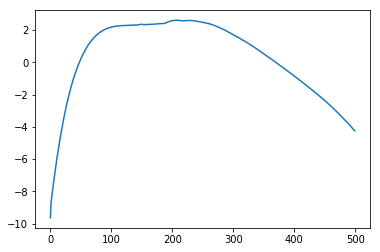

189


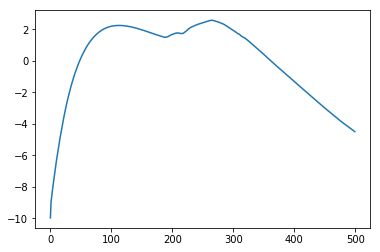

223


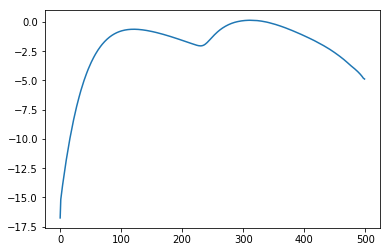

1841


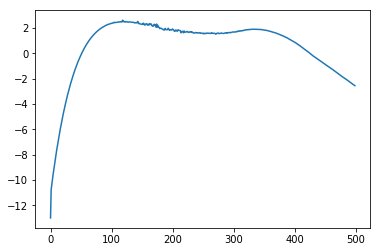

3667


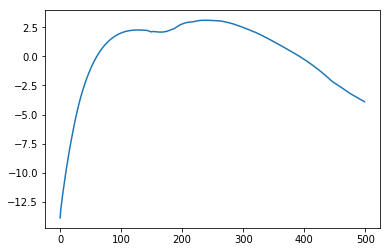

1619


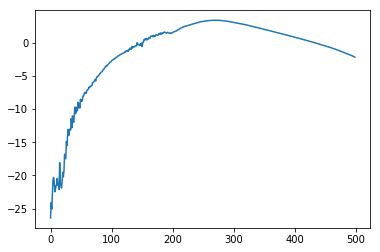

2471


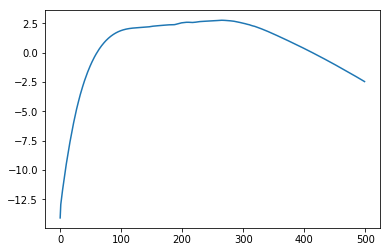

3785


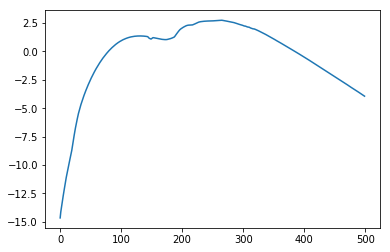

2916


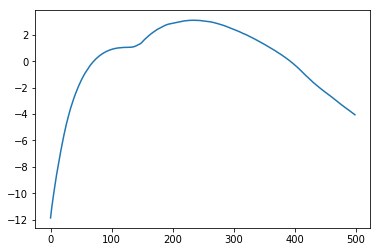

In [30]:
for i in range(len(smooth)):
    print(smooth[i])
    plt.plot(cube[smooth[i]])
    plt.show()

In [80]:
def sedcomp(model, ncomp=40,nfeat0=100,nfeat1=500):
    fig,ax=plt.subplots(1,figsize=(12,9))
    sed_msub=cube[model]-np.nanmean(nancube[model])
    coeffs=pca.transform(sed_msub.reshape(1,-1))
    reconst=np.dot(coeffs[0][0:ncomp],eigenseds[0:ncomp,nfeat0:nfeat1]) \
            +pca.mean_[nfeat0:nfeat1]+np.nanmean(nancube[model])    
    ax.plot(np.log10(xvals)[nfeat0:nfeat1], cube[model][nfeat0:nfeat1], c='black',label="pdspy SED",alpha=.9)
    ax.plot(np.log10(xvals)[nfeat0:nfeat1], reconst, c='r',label="reconstructed SED, ncomp="+str(ncomp),alpha=.6)
    plt.legend()
    plt.title("reconstructed SED of model "+str(model)+" against pdspy SED")
    plt.ylabel("log of Flux Density (mJy)",fontsize=16)
    plt.xlabel("log of λ (μm)",fontsize=16)
    plt.show()

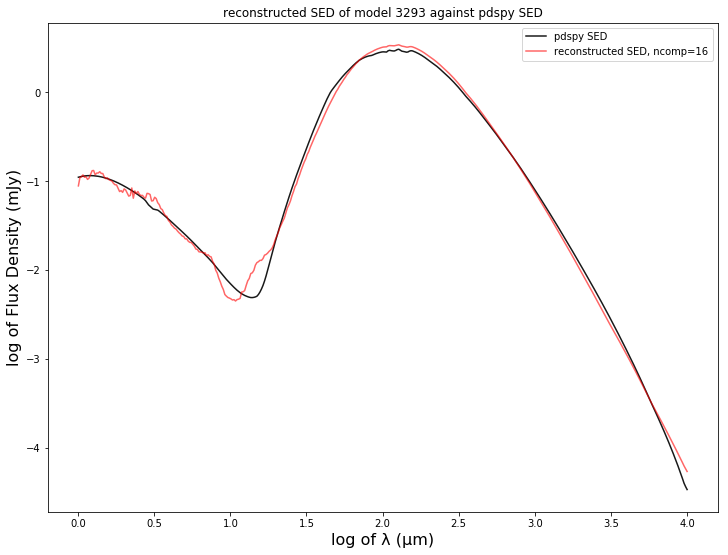

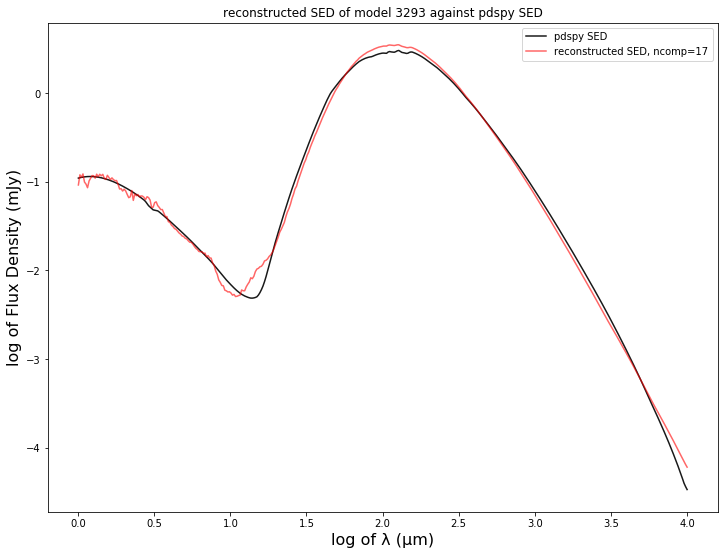

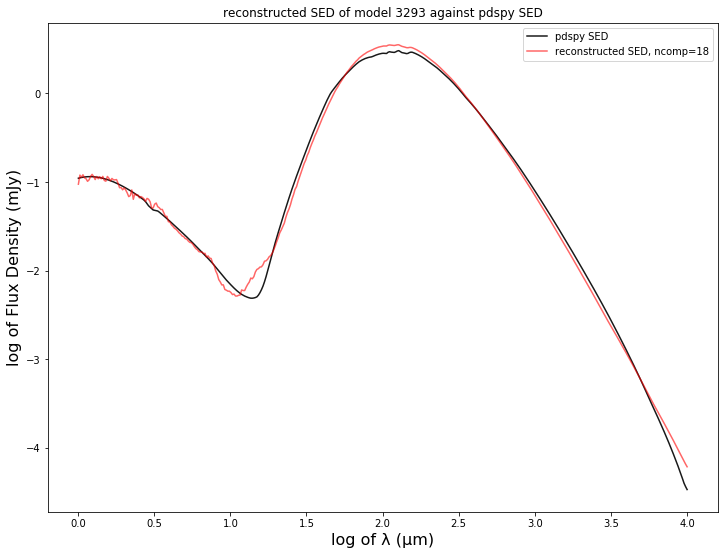

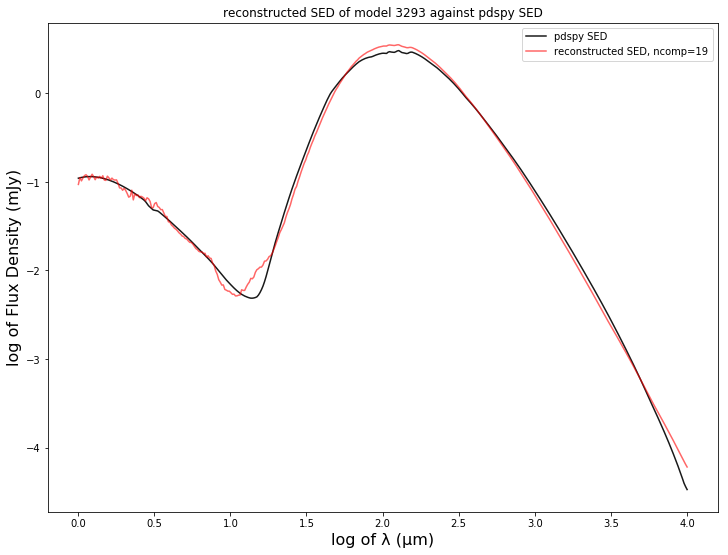

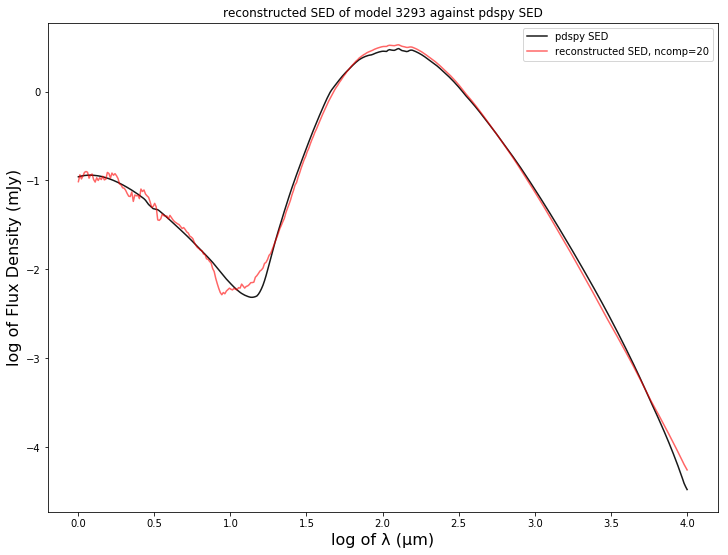

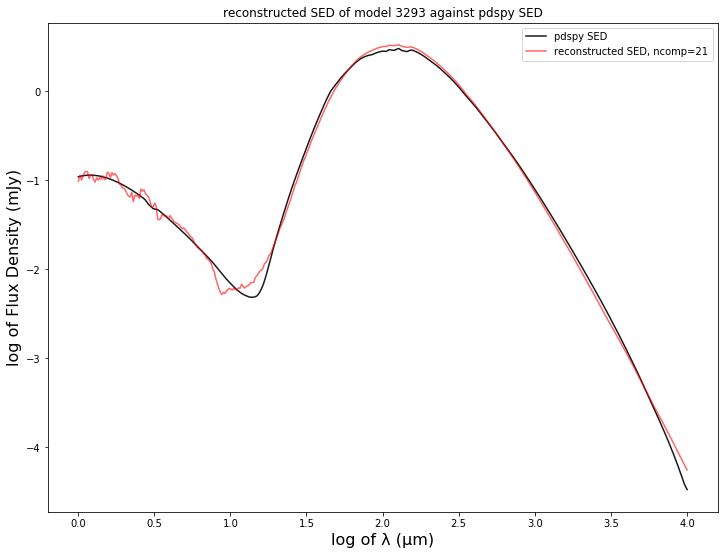

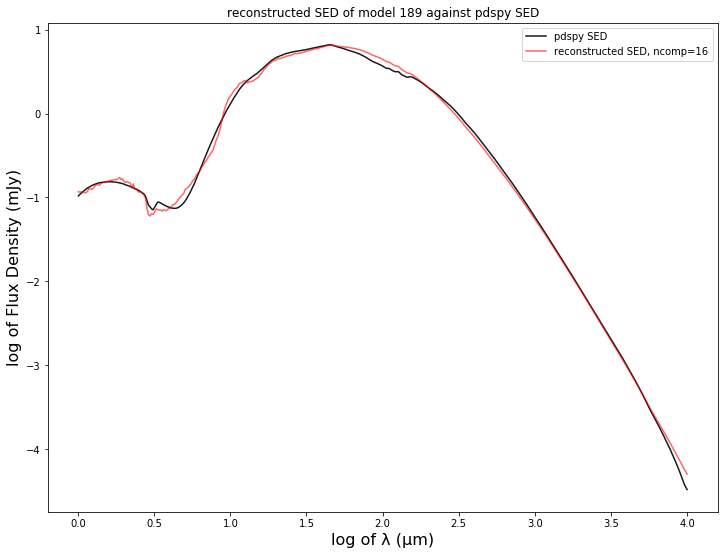

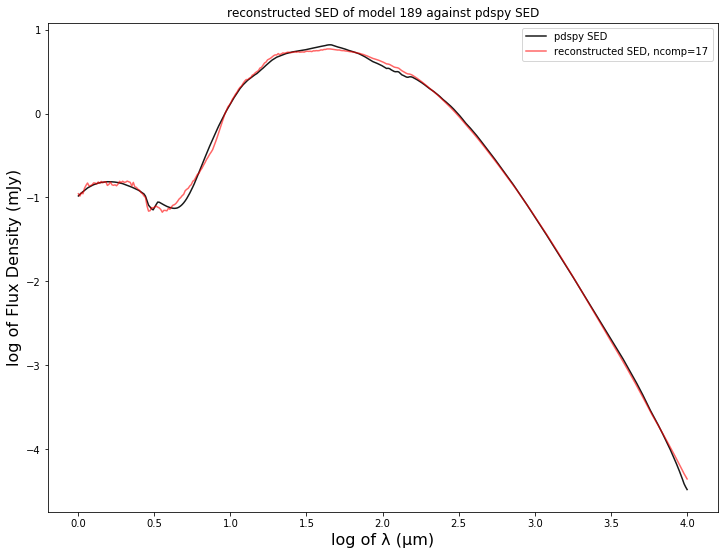

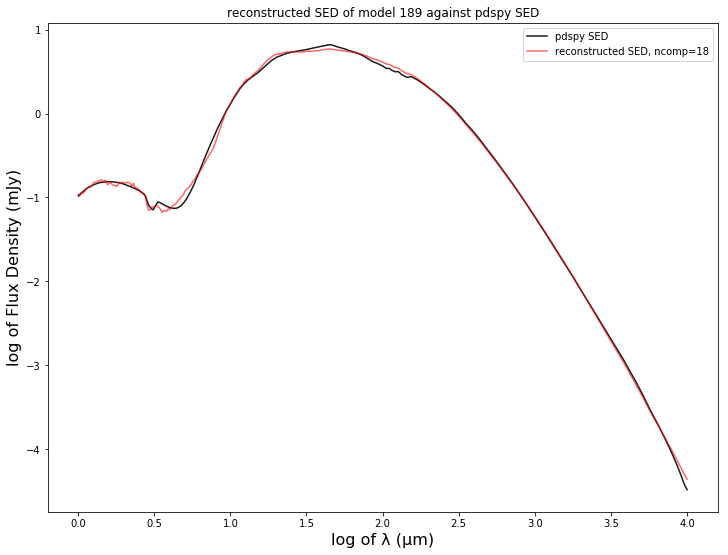

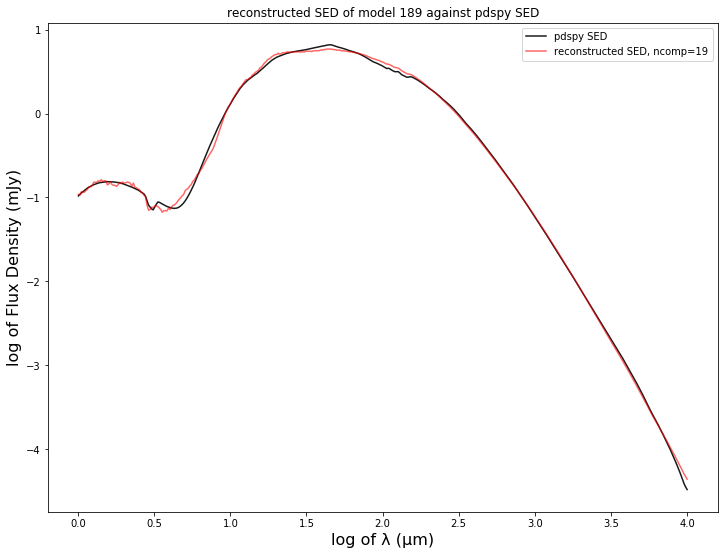

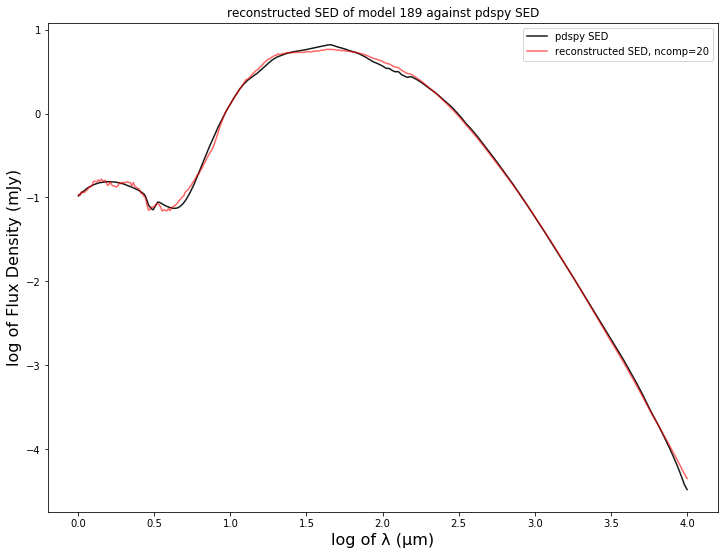

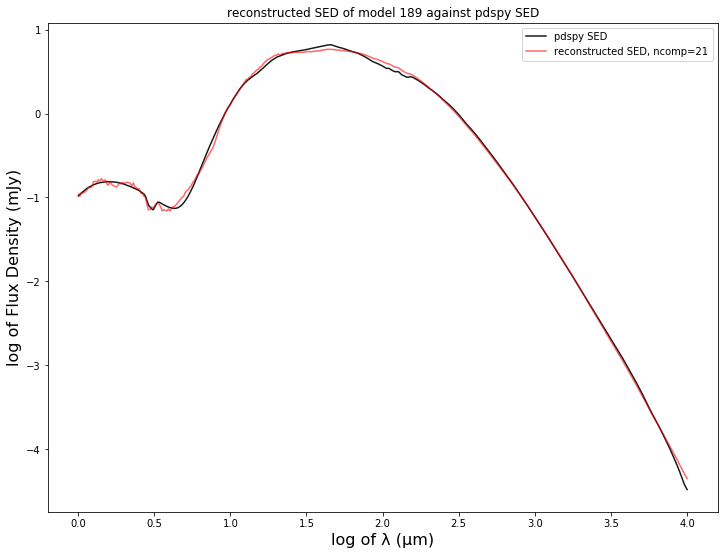

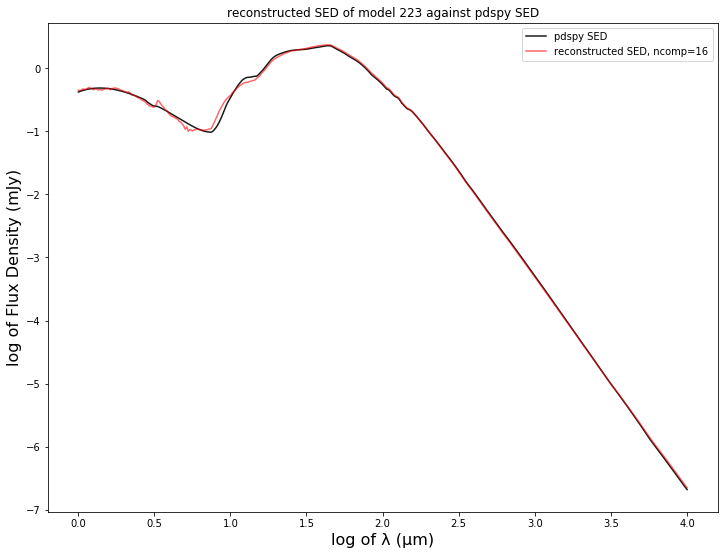

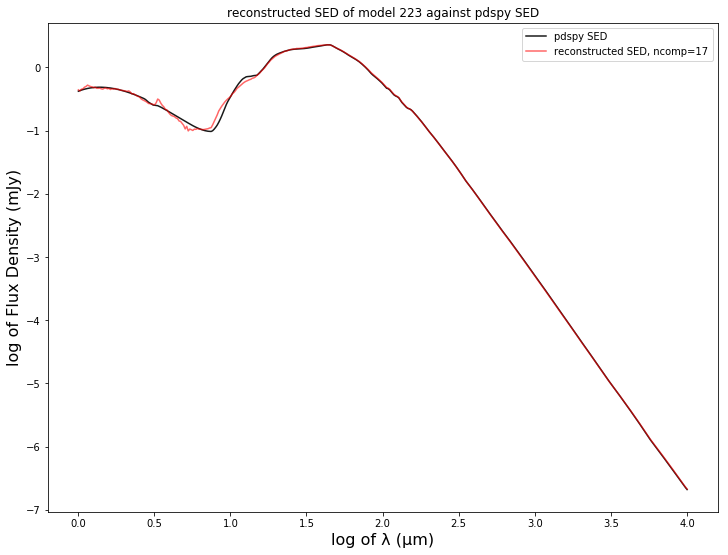

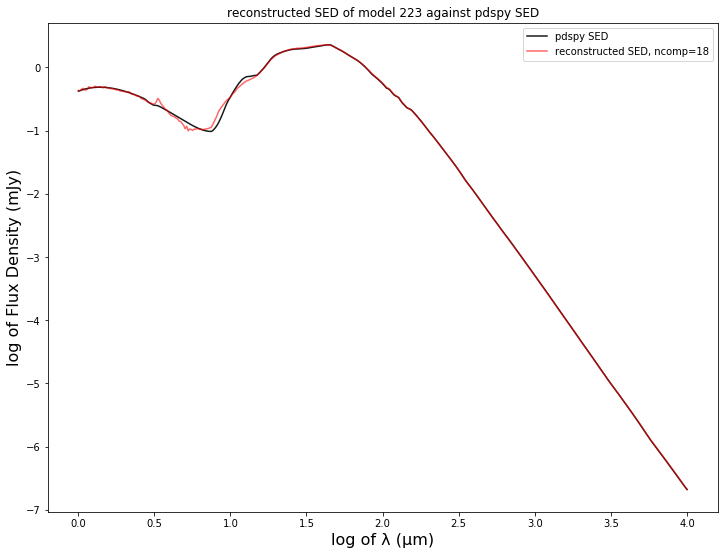

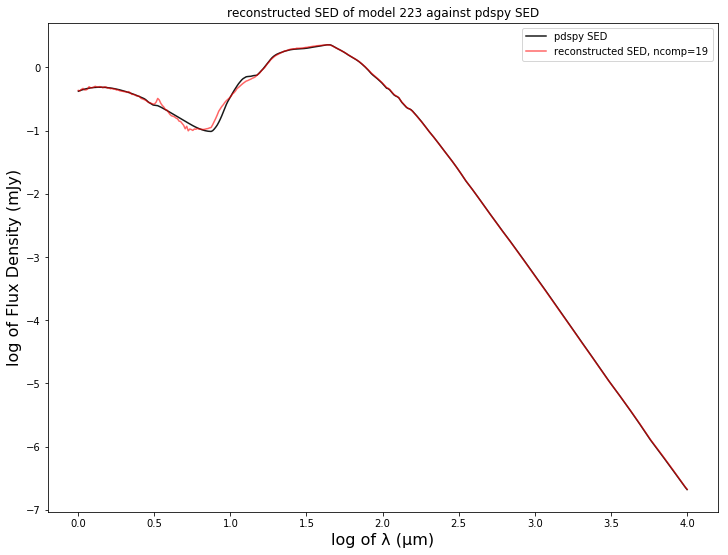

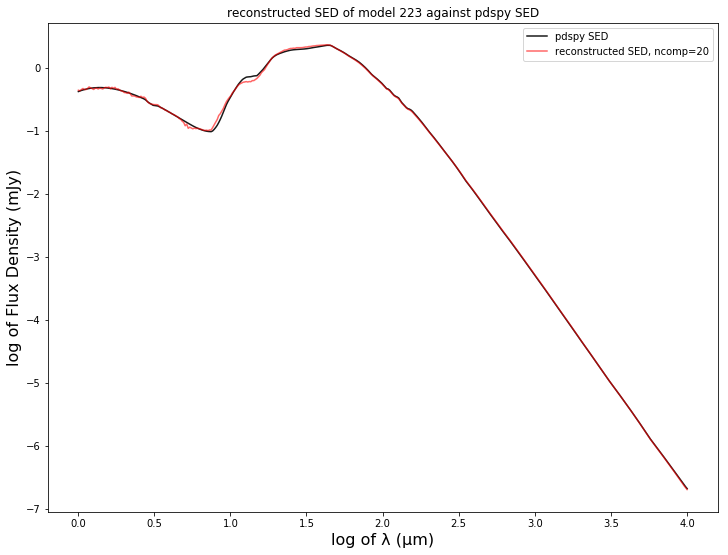

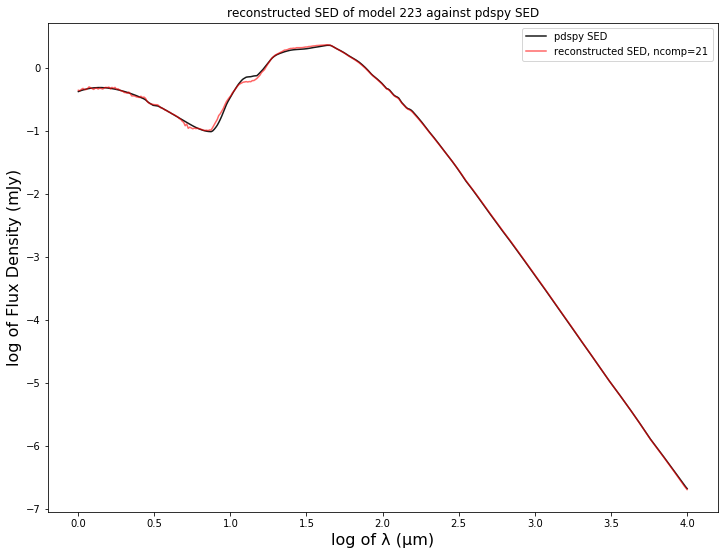

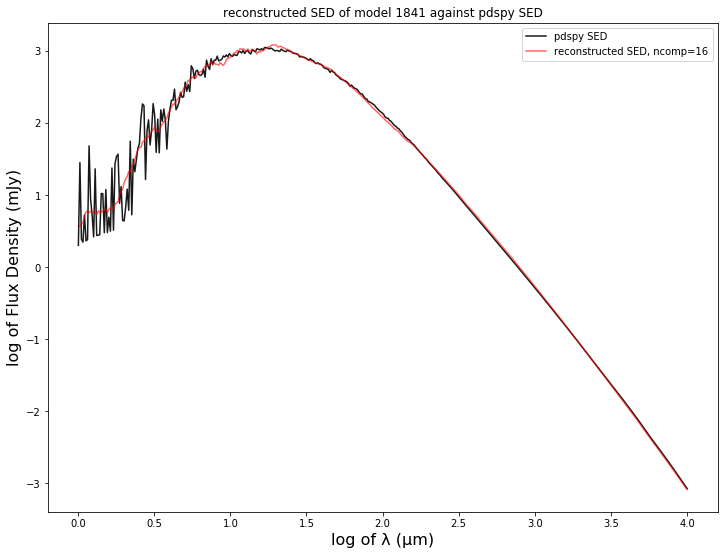

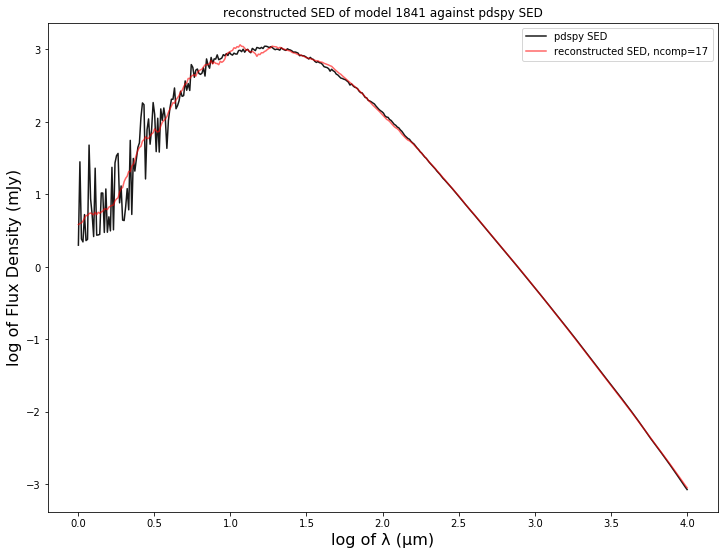

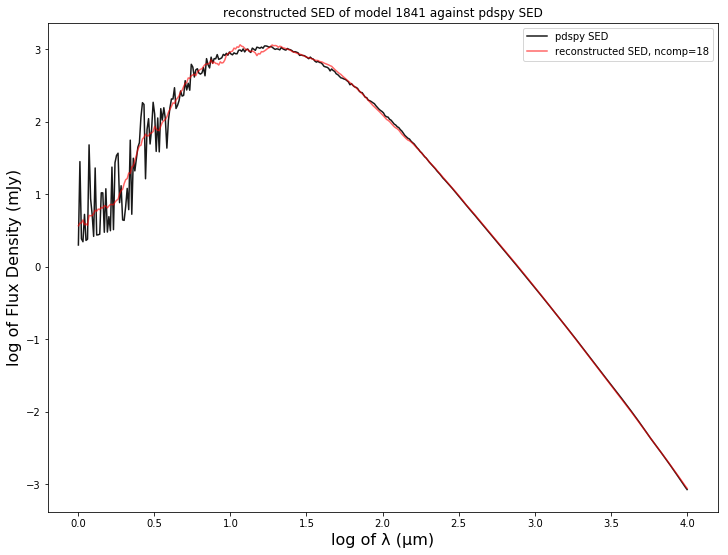

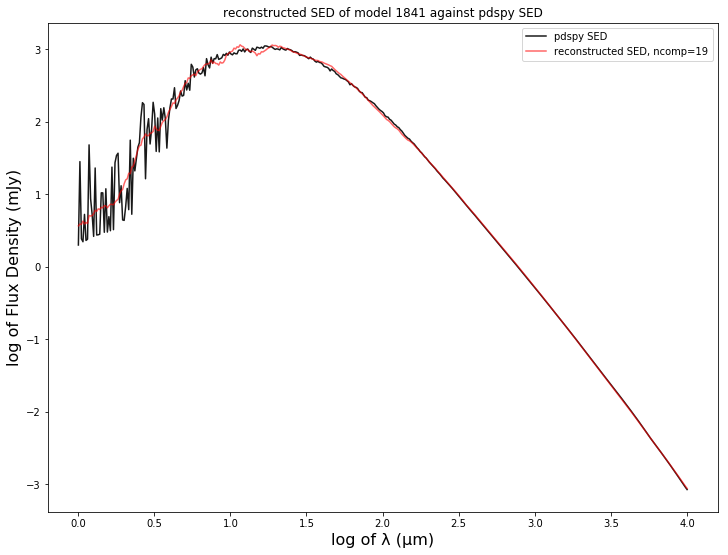

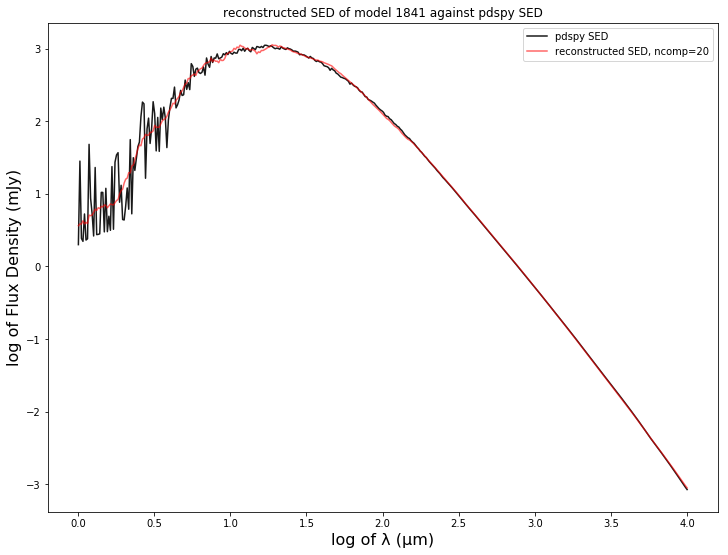

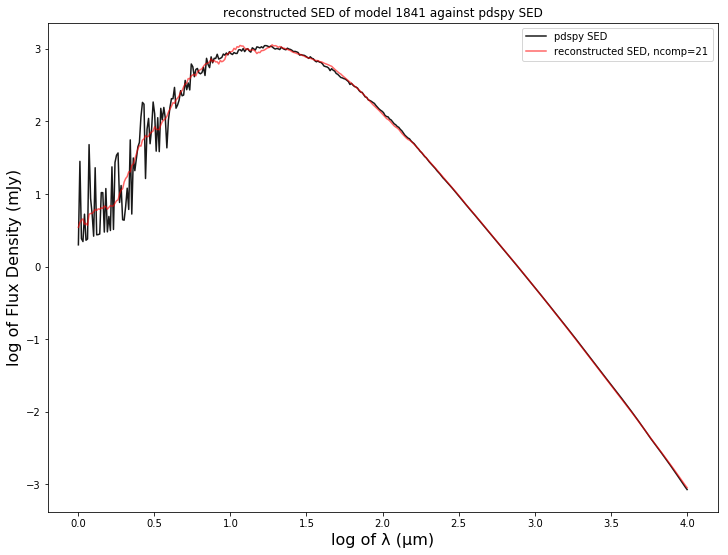

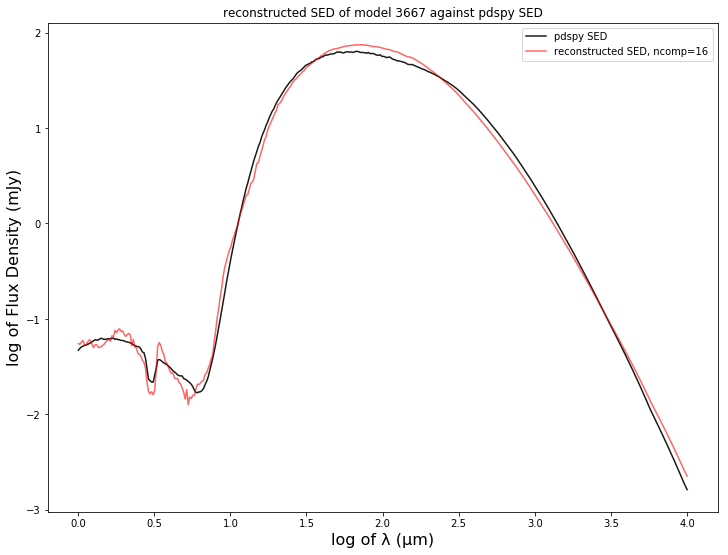

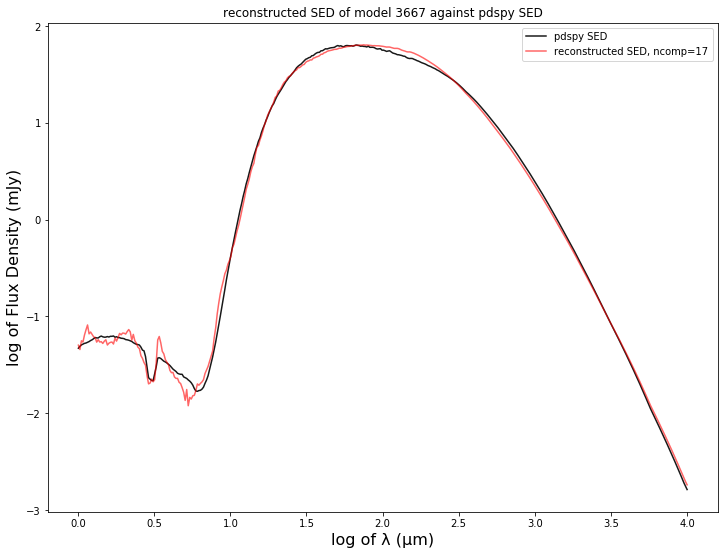

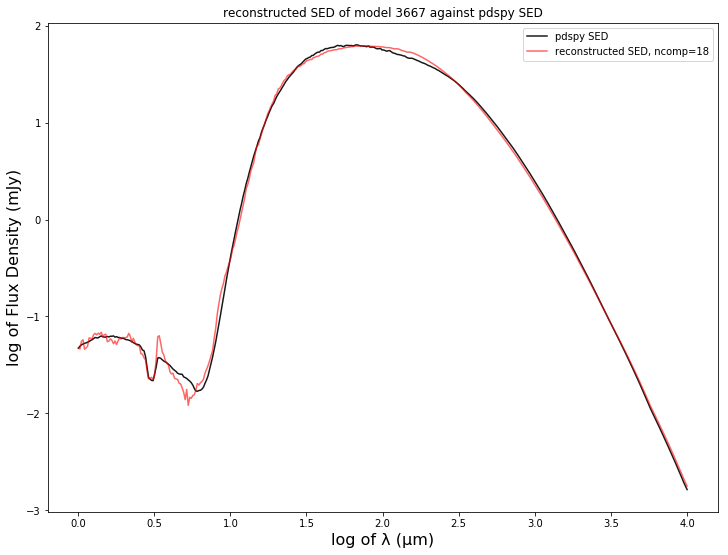

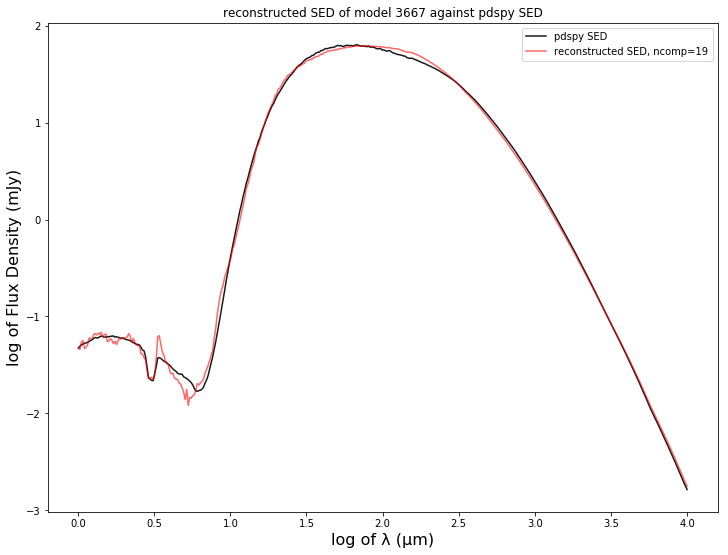

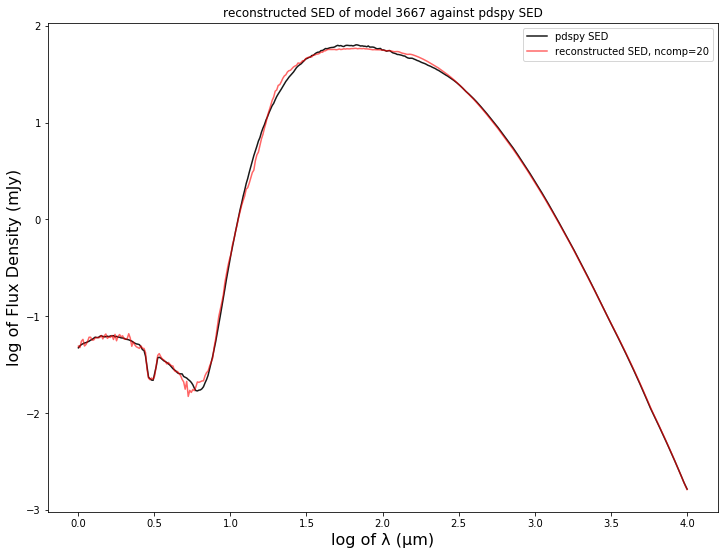

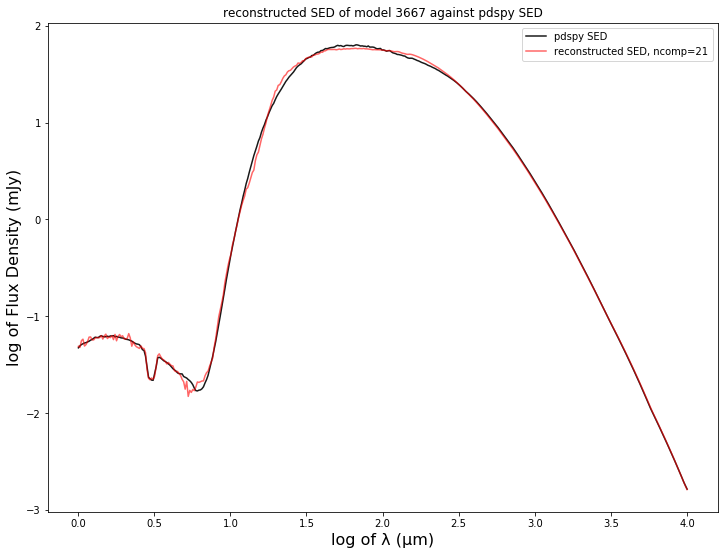

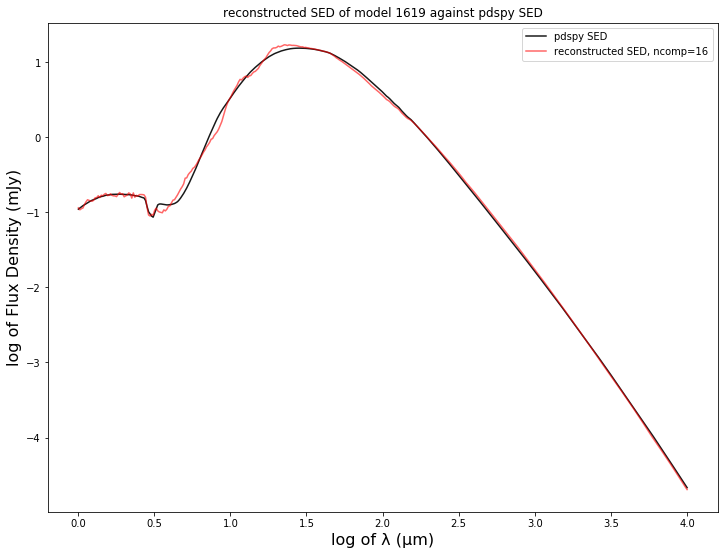

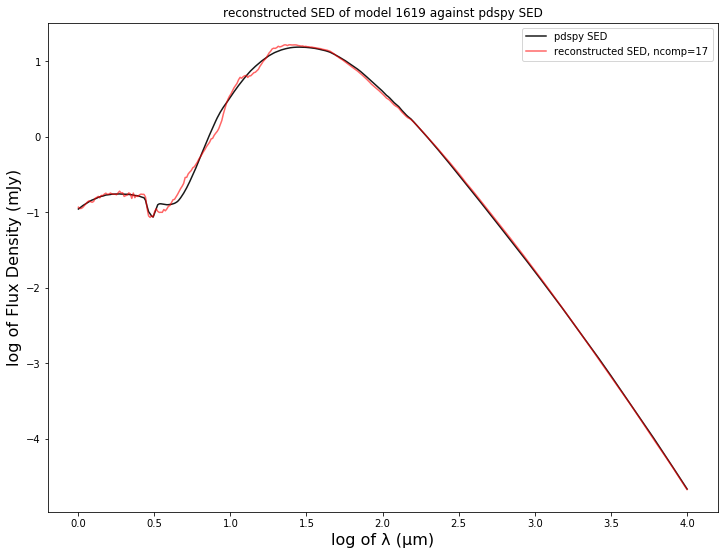

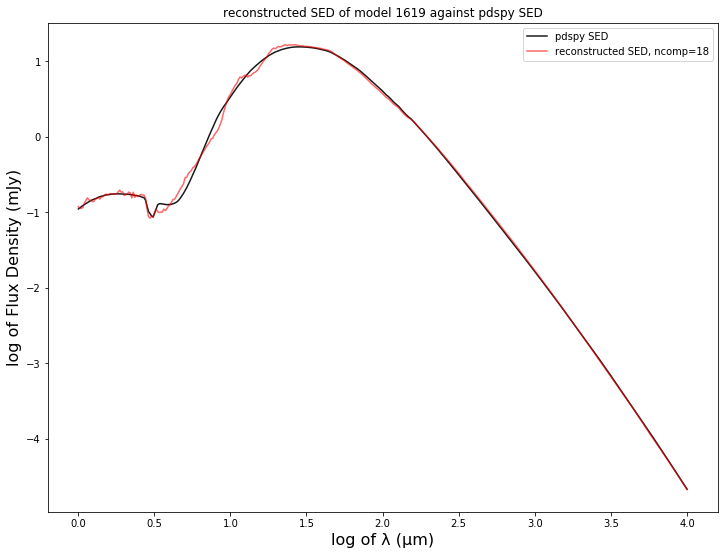

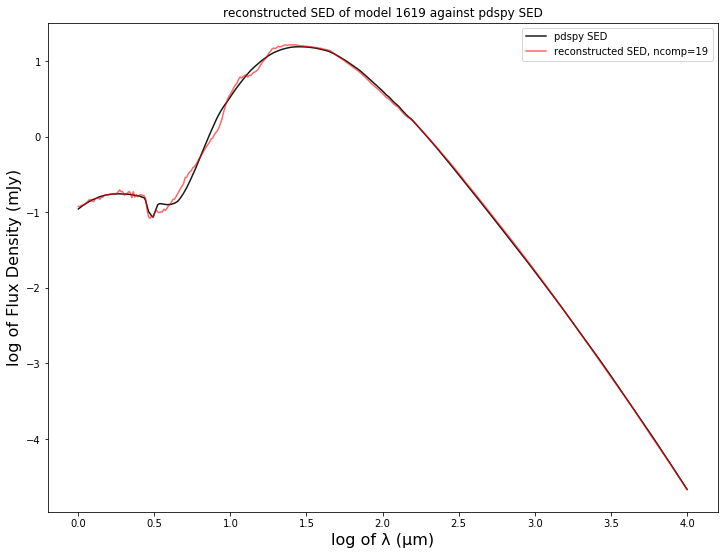

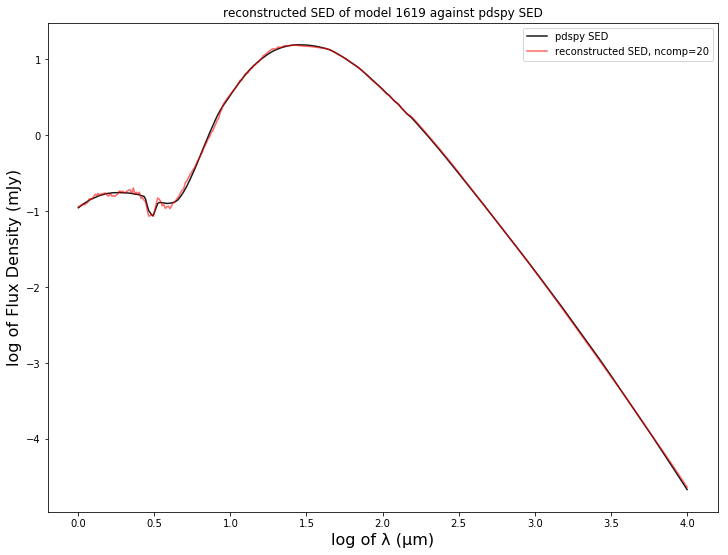

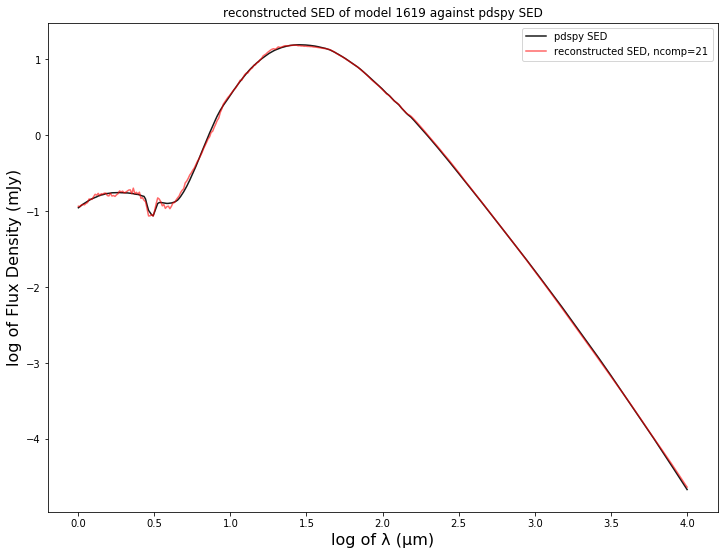

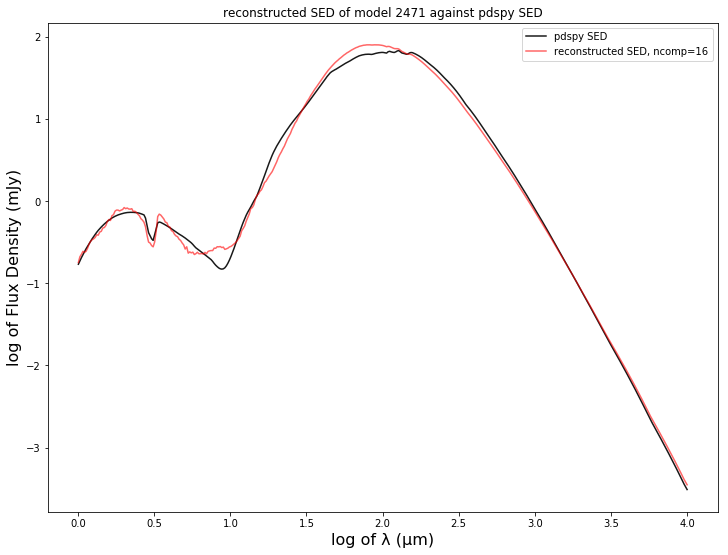

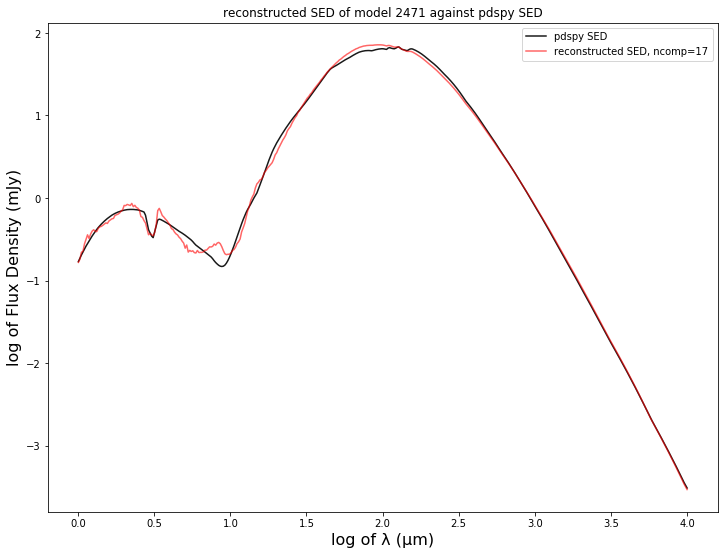

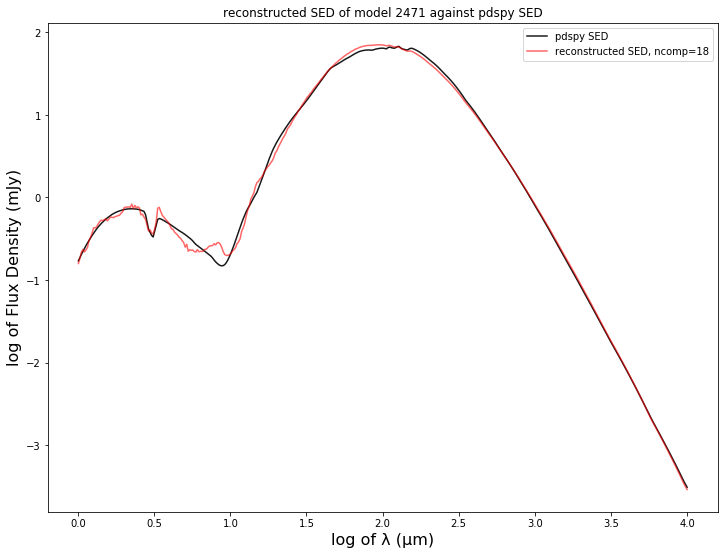

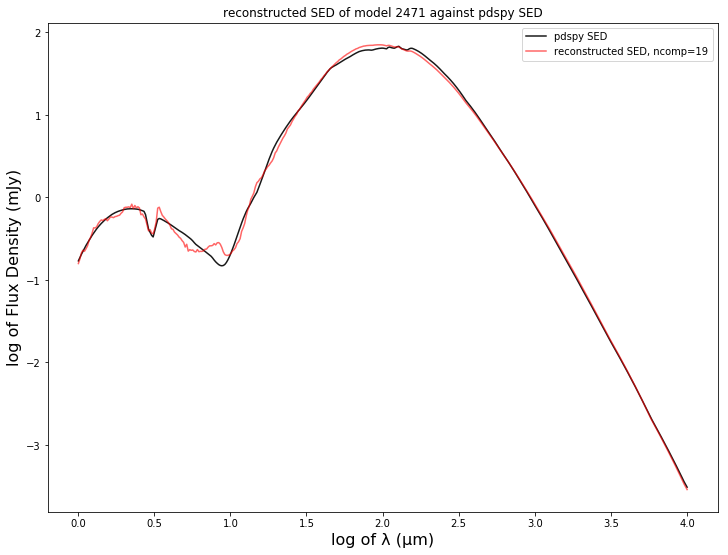

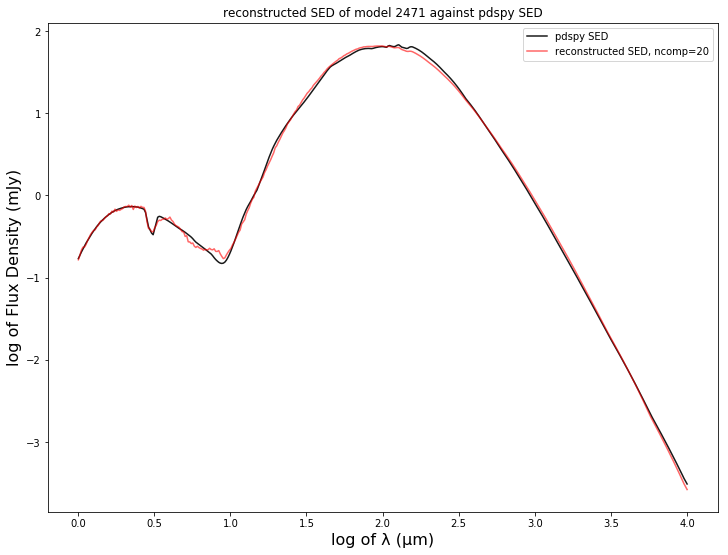

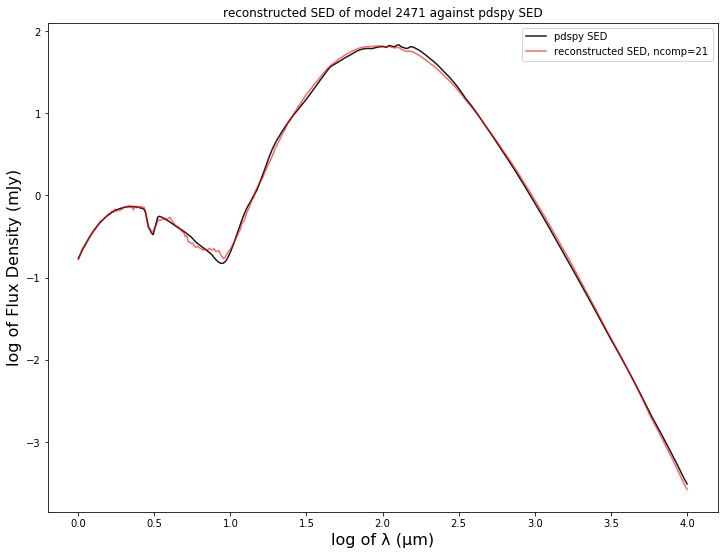

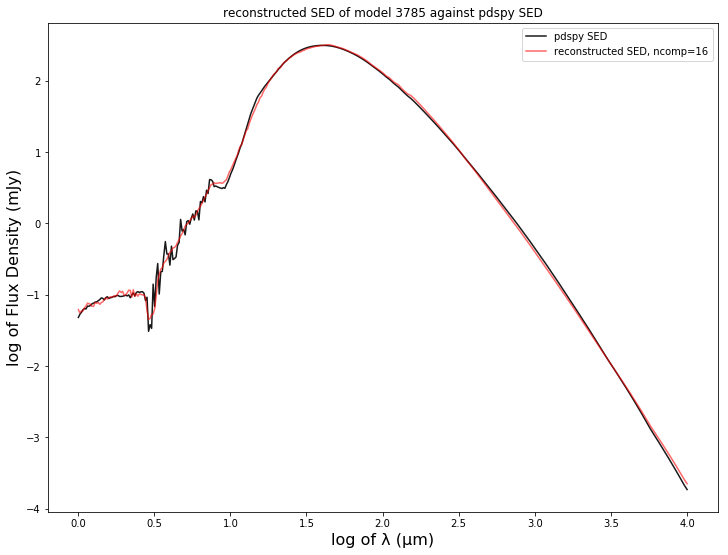

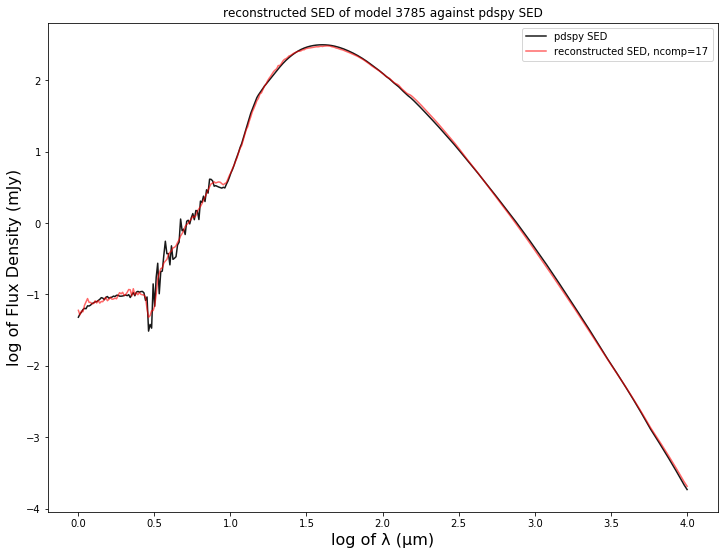

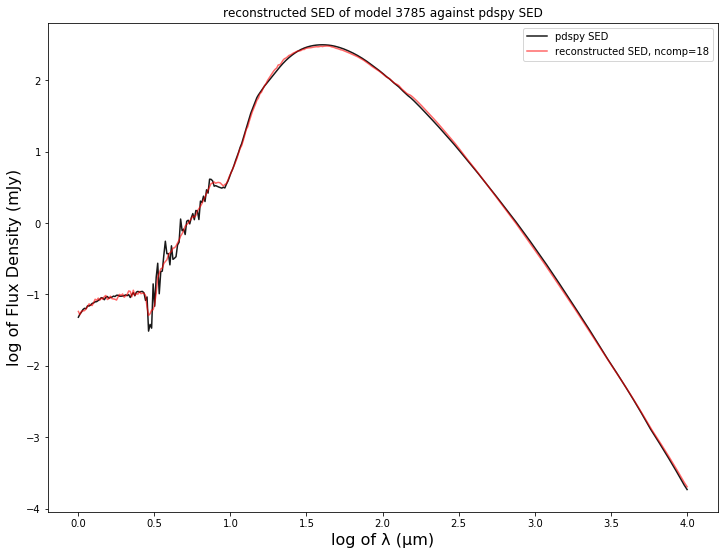

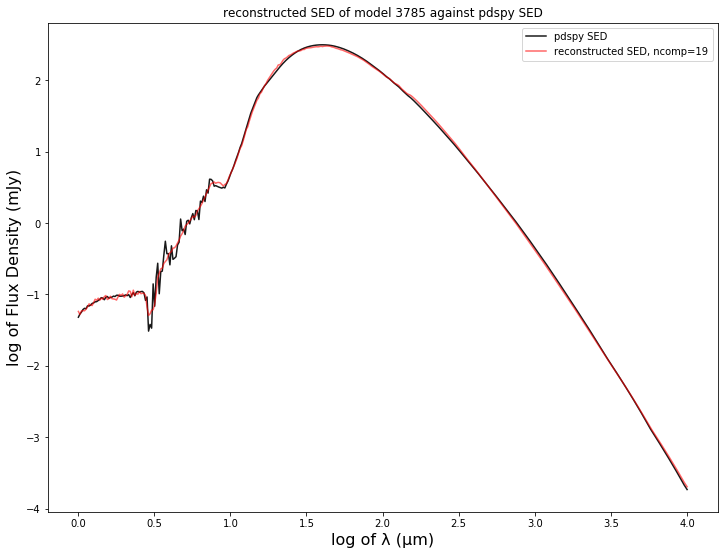

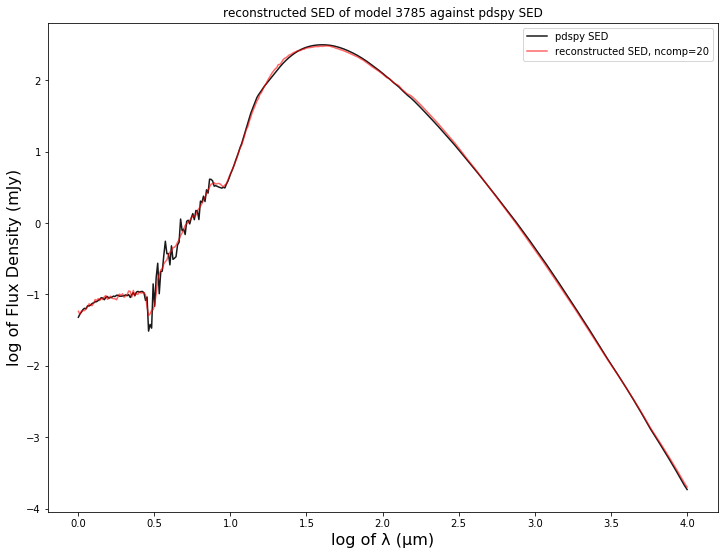

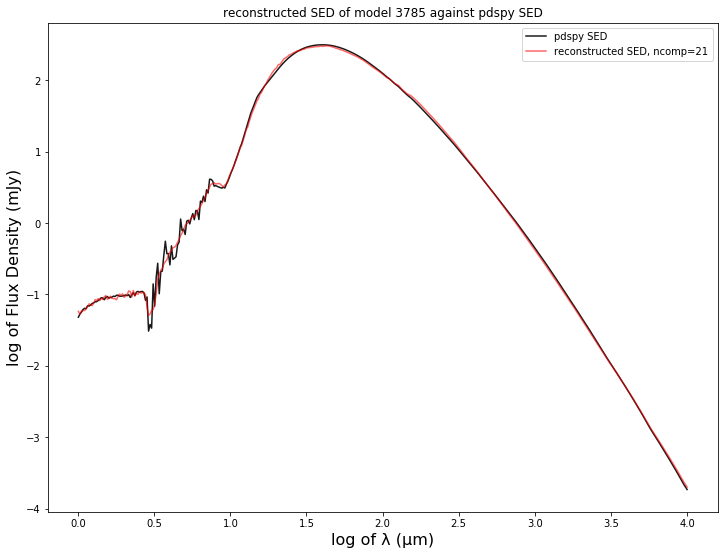

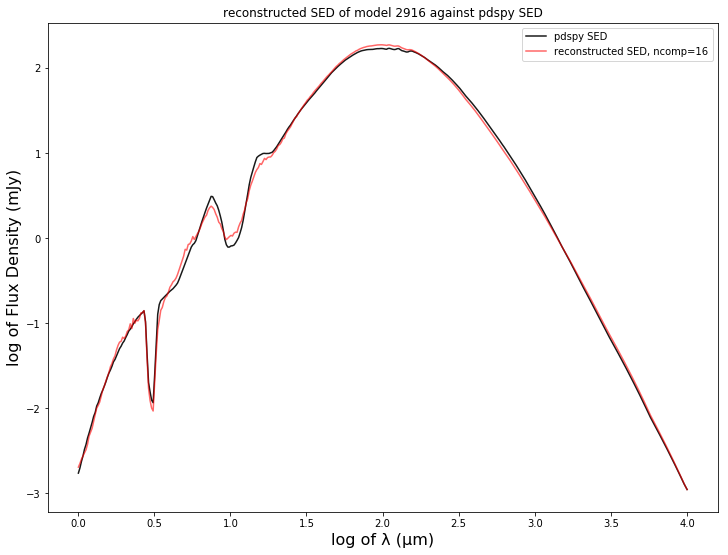

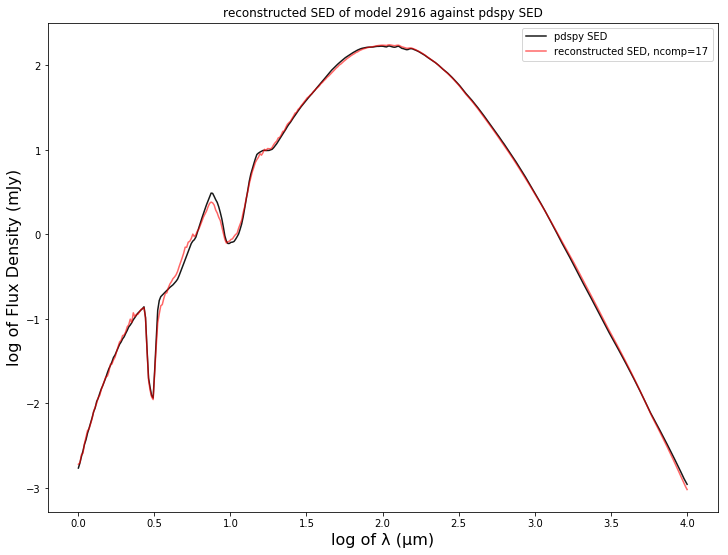

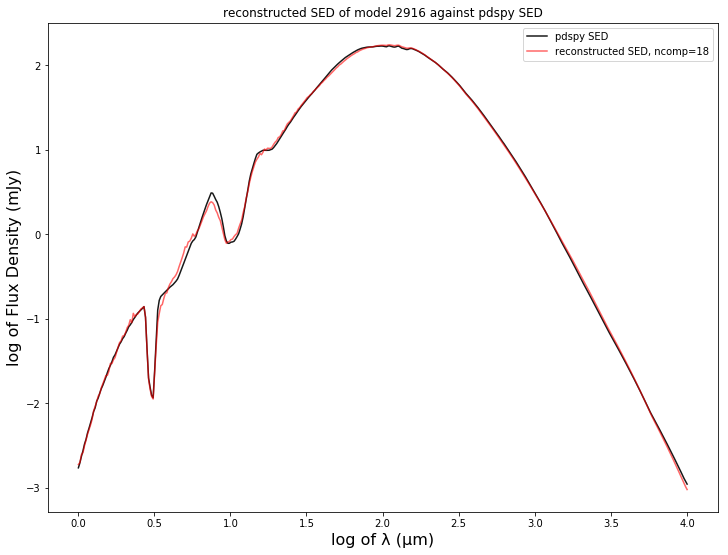

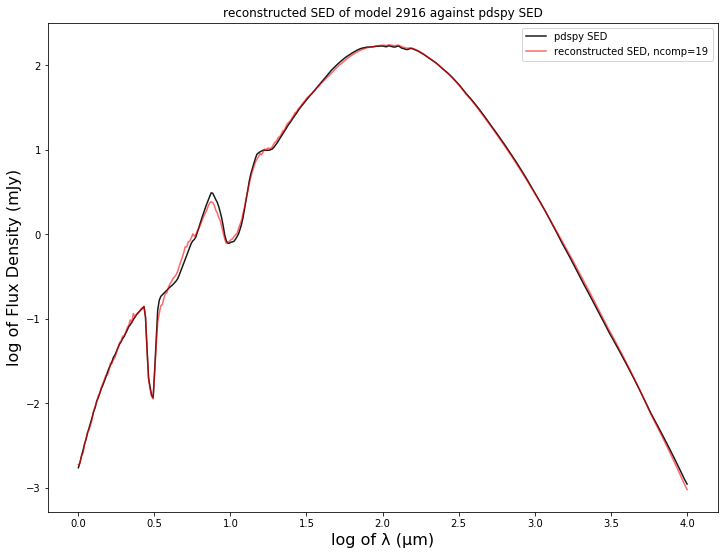

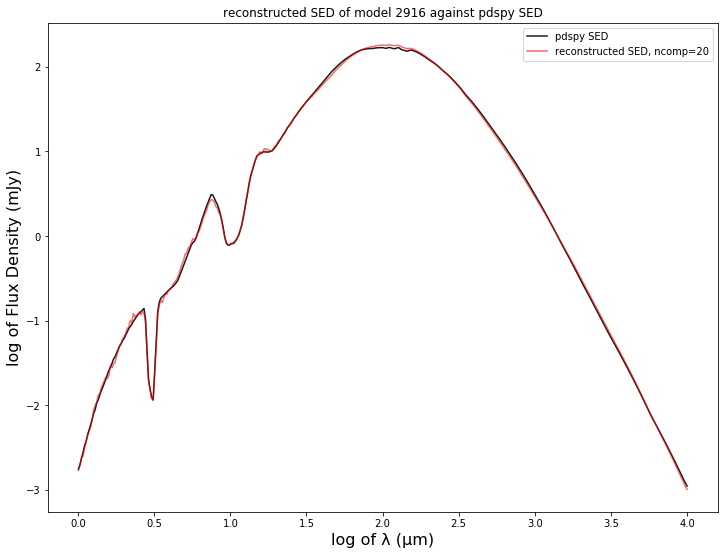

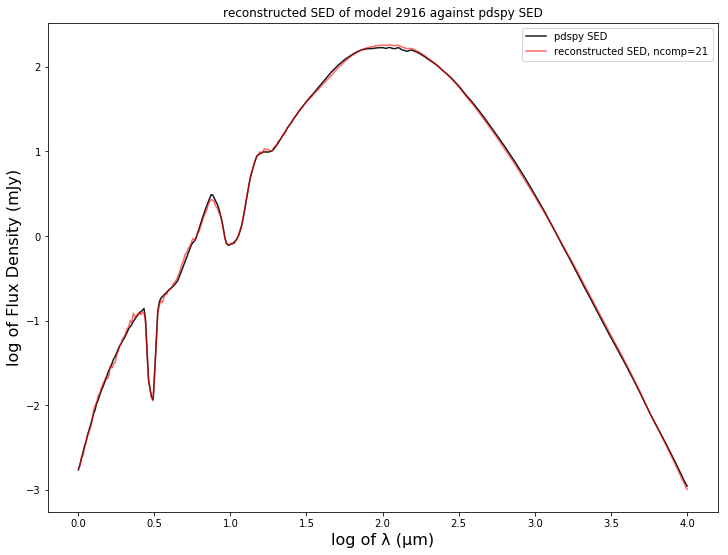

In [105]:
for i in range(len(smooth)):
    for j in range(16,22):
        sedcomp(smooth[i],j)

In [97]:
def residcomp(model, ncomp0,ncomp1,nfeat0=100,nfeat1=500):
    fig,ax=plt.subplots(1,figsize=(12,9))
    
    
    interval=np.linspace(0.1,1.,ncomp1-ncomp0)
    colors= plt.cm.viridis(interval)
    
    sed_msub=cube[model]-np.nanmean(nancube[model])

    for m in range(ncomp0,ncomp1):
        coeffs=pca.transform(sed_msub.reshape(1,-1))
        reconst=np.dot(coeffs[0][0:m],eigenseds[0:m,nfeat0:nfeat1]) \
                +pca.mean_[nfeat0:nfeat1]+np.nanmean(nancube[model])
        resids = reconst-(cube[model][nfeat0:nfeat1])
        ax.plot(np.log10(xvals[nfeat0:nfeat1]),resids, c=colors[m-ncomp0],label="ncomp="+str(m)) 
    
    plt.legend()
    plt.title("reconstructed SED of model "+str(model)+" against pdspy SED")
    plt.ylabel("log of Flux Density (mJy)",fontsize=16)
    plt.xlabel("log of λ (μm)",fontsize=16)
    plt.ylim(-.7,.7)
    plt.show()


done in 0.038s


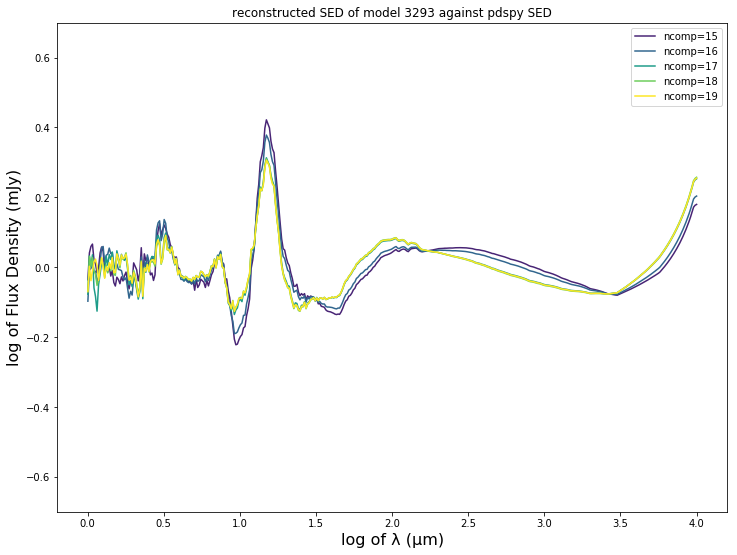

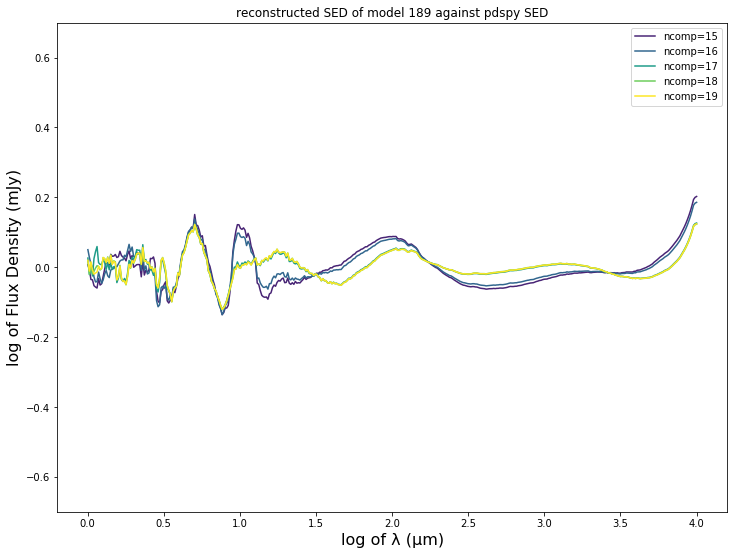

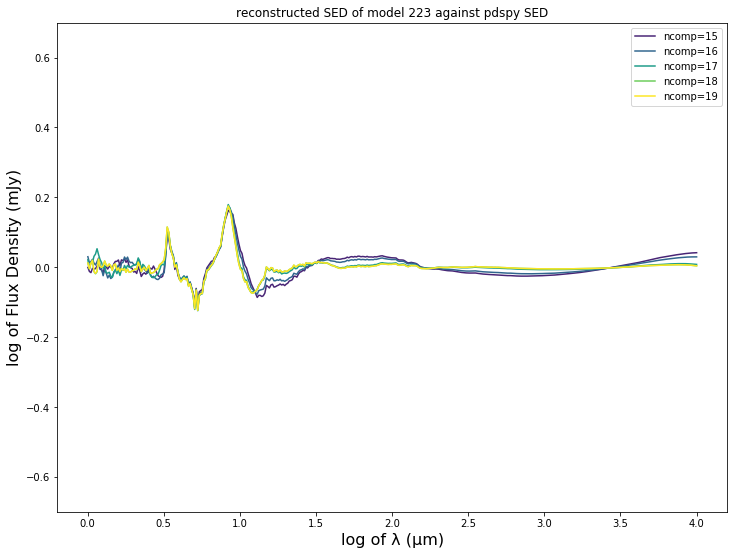

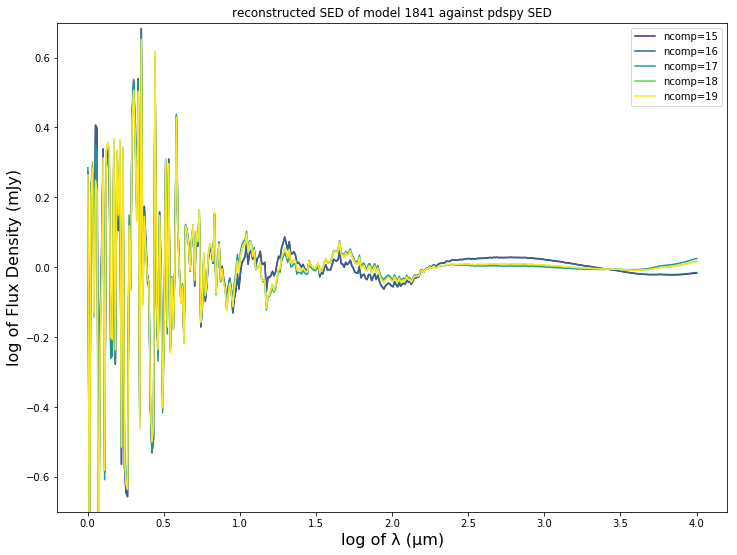

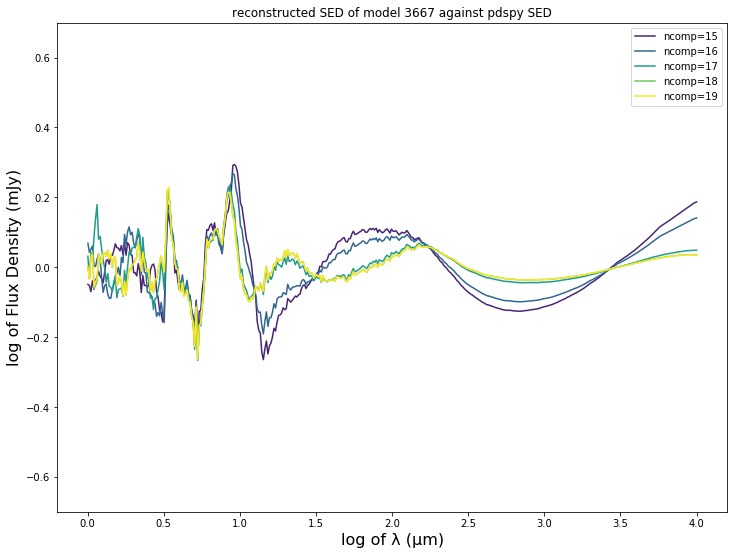

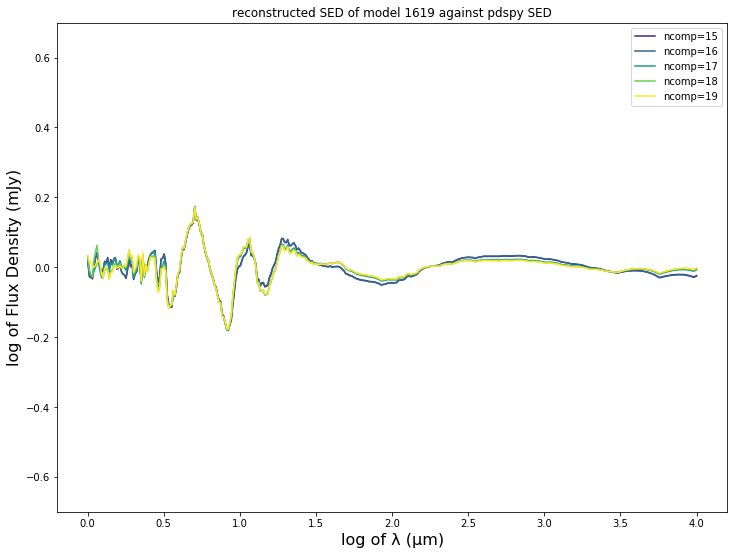

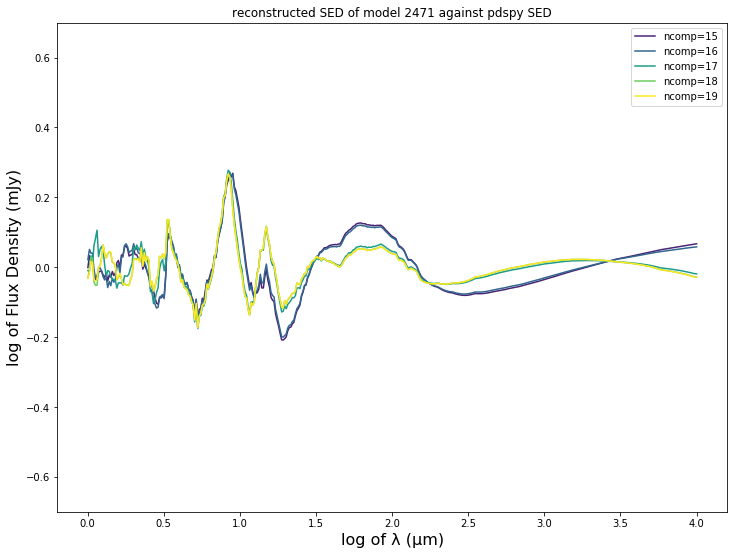

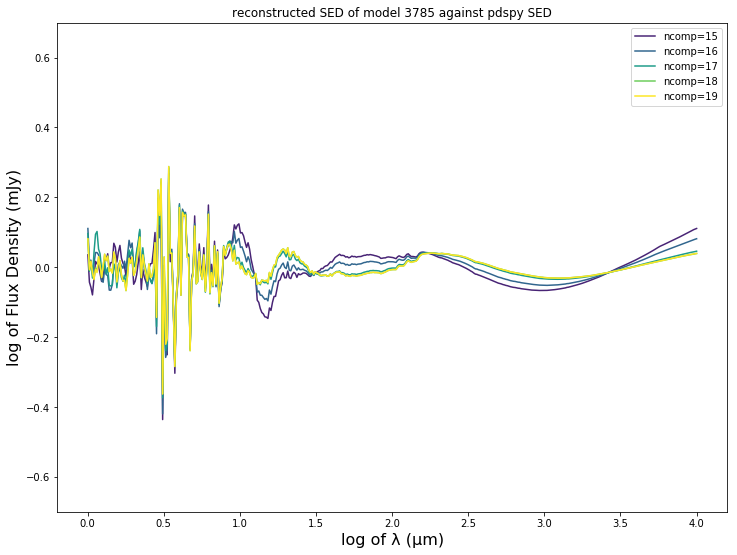

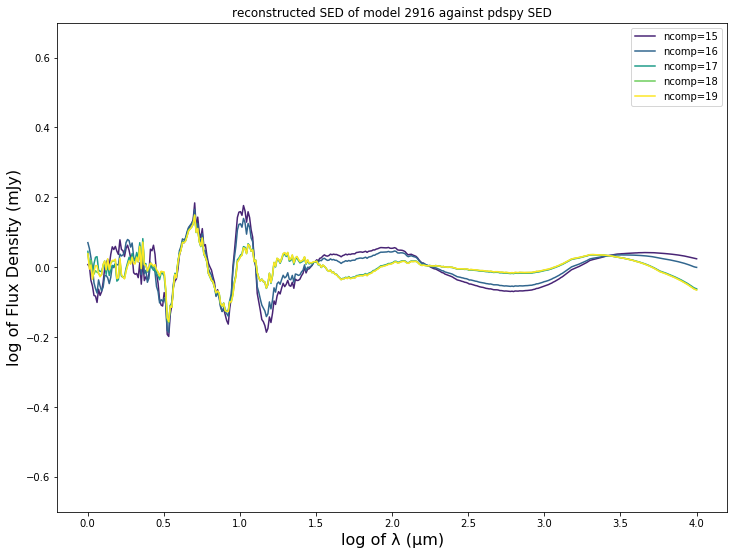

In [104]:
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    cube = np.array(pickle.load(fp))
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    nancube = np.array(pickle.load(fp))
    
    
# fix -infs: powerlaw cutoff
for i in range(len(cube)):
    if -np.inf in cube[i]:
        a = cube[i].tolist()
        a.reverse()
        ind = len(a)-a.index(-np.inf)
        x1 = xvals[ind]
        y1 = cube[i][ind]
        for j in range(ind):
            cube[i][j]=(100*(np.log10(xvals[j]/x1)))+y1
            
# nan cutoff for means            
nancube[nancube<-20]=np.nan

seds_msub = cube - np.nanmean(nancube,axis=1)[:,np.newaxis]

t0 = time()
pca = PCA(n_components=40).fit(seds_msub)
print("done in %0.3fs" % (time() - t0))

eigenseds=np.array(pca.components_)

for i in range(len(smooth)):
    residcomp(smooth[i],15,20)